# Classification of 1551 Requests

In [513]:
import os
import time
import re
import pickle
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm_notebook as progress
try:
    from cfuzzyset import cFuzzySet as FuzzySet
except ImportError:
    from fuzzyset import FuzzySet
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
import matplotlib as mpl

import langdetect
import tokenize_uk
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

In [232]:
download_data = False
download_embeddings = False

if download_data:
    !bash download_data.sh

if download_embeddings:
    !bash download_embeddings.sh

In [268]:
load_from_file = True

# Load data

*I manually fixed the dataset a bit by removing two replies in `Перевірка-дозвільної-документації--демонтаж-воріт--огорожі--паркану--забору.txt` (the line starts with `Відповідь`) since we should analyse requets only.

In [503]:
class Dataset(object):
    """1551 dataset class.
        Args:
            root -- path to data directory
            
        Main attributes:
            train_inputs -- list of requests for training
            train_targets -- list of corresponding categories for training
            val_inputs -- list of requests for validation
            val_targets -- list of corresponding categories for validation
    """
    def __init__(self, root, load_processed=False):
        self.root = root
        self.filepaths = sorted(glob('{}/*.txt'.format(root)))
        classes = [os.path.splitext(os.path.split(fp)[1])[0] for fp in self.filepaths]
        self.class_to_idx = dict(zip(classes, range(len(classes))))  # classset
        if not load_processed:
            self.__load()
            self.__split(random_state=42)
        else:
            self.load_processed()
        
    def __load(self):
        self.inputs = []
        self.targets = []
        for cls in progress(sorted(self.class_to_idx.keys())):
            with open('{}/{}.txt'.format(self.root, cls)) as f:
                inputs = self.__parse('\n'.join(f.readlines()[1:]))
                targets = [self.class_to_idx[cls]] * len(inputs)
                self.inputs.extend(inputs)
                self.targets.extend(targets)
        self.inputs = np.array([doc.replace('\n','') for doc in self.inputs])
        self.targets = np.array(self.targets)
        print('Dataset loaded')
        print('{} requests'.format(self.__len__()))
        print('{} categories'.format(len(self.class_to_idx.keys())))
    
    def __parse(self, text):
        emptiness_filter = lambda request: request.replace('\n','')\
                                                  .replace('”', '')\
                                                  .replace(' ', '') != ''
        lang_filter = lambda request: langdetect.detect(request) == 'uk'
        return list(filter(lang_filter, filter(emptiness_filter, re.split(r'\n\d{7}\n', text))))
    
    def __len__(self):
        return len(self.inputs)
    
    def __split(self, random_state=None):
        train_indices, val_indices = train_test_split(np.arange(self.__len__()),
                                                      test_size=0.3,
                                                      random_state=random_state,
                                                      stratify=self.targets)
        self.train_inputs = self.inputs[train_indices]
        self.train_targets = self.targets[train_indices]
        
        self.val_inputs = self.inputs[val_indices]
        self.val_targets = self.targets[val_indices]
        
        print('Split into train ({}) and validation ({}) data'.format(len(self.train_inputs),
                                                                      len(self.val_inputs)))
        plt.subplot(1,2,1)
        plt.title('Train data category distribution')
        plt.hist(self.train_targets)
        plt.subplot(1,2,2)
        plt.title('Validation data category distribution')
        plt.hist(self.val_targets)
        plt.show()
        
    def save(self):
        with open('dataset.pkl', 'wb') as f:
            pickle.dump({'train_inputs': self.train_inputs,
                         'train_targets': self.train_targets,
                         'val_inputs': self.val_inputs,
                         'val_targets': self.val_targets}, f)
        
    def load_processed(self):
        with open('dataset.pkl', 'rb') as f:
            data = pickle.load(f)
        self.train_inputs = data['train_inputs']
        self.train_targets = data['train_targets']
        self.val_inputs = data['val_inputs']
        self.val_targets = data['val_targets']
        
        self.inputs = np.hstack((self.train_inputs, self.val_inputs))
        self.targets = np.hstack((self.train_targets, self.val_targets))
        
        print('Dataset loaded')
        print('{} requests'.format(self.__len__()))
        print('{} categories'.format(len(self.class_to_idx.keys())))
        print('Split into train ({}) and validation ({}) data'.format(len(self.train_inputs),
                                                                      len(self.val_inputs)))
        plt.subplot(1,2,1)
        plt.title('Train data category distribution')
        plt.hist(self.train_targets)
        plt.subplot(1,2,2)
        plt.title('Validation data category distribution')
        plt.hist(self.val_targets)
        plt.show()

Dataset loaded
61821 requests
188 categories
Split into train (43274) and validation (18547) data


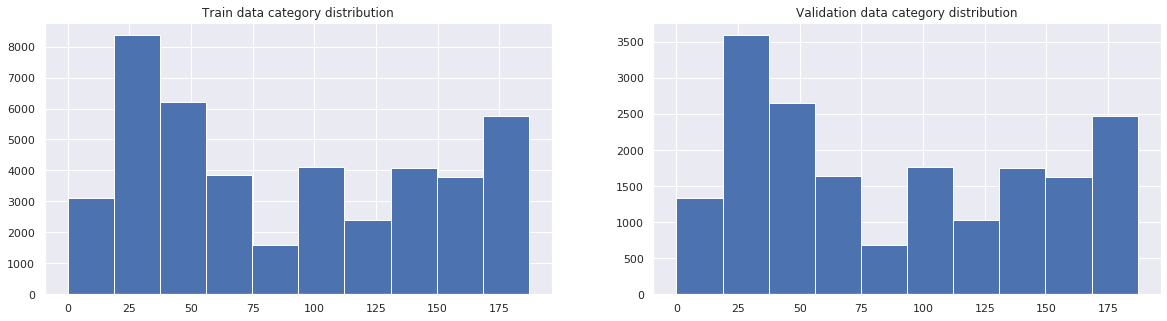

In [504]:
mpl.rcParams['figure.figsize'] = (20, 5)
dataset = Dataset(root='./data/1551', load_processed=True)

# Load embeddings

In [11]:
word2vec = KeyedVectors.load_word2vec_format('./embeddings/ubercorpus.lowercased.tokenized.word2vec.300d')
w2v_vocab = FuzzySet(word2vec.vocab)

# Filter words, find the closest words in the word2vec vocabulary to fix mistaken words

In [299]:
stopwords_uk = ['до', 'на', 'за', 'його', 'і', 'в', 'що', 'він', 'щоб', 'мій', 'про',
                'небудь', 'ой', 'я', 'те', 'з', 'тим', 'як', 'все', 'вона', 'ти', 'своїй',
                'її', 'того', 'від', 'ще', 'ніби', 'ви', 'там', 'де', 'вони', 'т', 'ін', 'д',
                'тощо', 'куди', 'всіх', 'о', 'через', 'ми', 'твій', 'наш', 'ваш', 'є', 'бути']

if not load_from_file:    
    word_to_idx = {}  # vocabulary of correct words
    word_fixes = {}  # vocabulary of mistaken words with fixes (fixed versions are stored in word_to_idx)

    print('Fixed words:')
    for doc in progress(dataset.inputs):
        tokens = tokenize_uk.tokenize_words(doc.replace('\n',''))
        for token in tokens:
            token = token.lower()
            parse = morph.parse(token)[0]
            if parse.tag.POS not in {'NUMR', 'NPRO', 'PREP', 'CONJ', 'PRCL'} and \
                   not 'UNKN' in parse.tag and \
                   not 'NUMB' in parse.tag and \
                   not 'PNCT' in parse.tag and \
                   not token.isdigit() and \
                   token not in stopwords_uk and \
                   parse.normal_form not in stopwords_uk:

                if token not in word2vec and token not in word_fixes:
                    candidate = w2v_vocab.get(token)
                    if candidate is not None and len(candidate) > 0:
                        word_fixes[token] = candidate[0][1]
                        print(token, '->', word_fixes[token])
                        token = word_fixes[token]
                if token in word2vec and token not in word_to_idx:
                    word_to_idx[token] = len(word_to_idx)

        with open('word_to_idx.pkl', 'wb') as f:
            pickle.dump(word_to_idx, f)
        with open('word_fixes.pkl', 'wb') as f:
            pickle.dump(word_fixes, f)
        
else:
    with open('word_to_idx.pkl', 'rb') as f:
        word_to_idx = pickle.load(f)
    with open('word_fixes.pkl', 'rb') as f:
        word_fixes = pickle.load(f)

Fixed words:


щебнем -> щебенем
господарськи -> господарський
об’єму -> об'єму
заасфальтоване -> заасфальтовано
асфальтуванню -> асфальтування
захаращує -> захаращують
демонтуйте -> демонструйте
шевченкiвського -> шевченківського
рахонок -> рахунок
приїнятих -> прийнятих
ненадану -> ненадані
регенераторна -> генераторні
роз’яснення -> роз'яснення
ціноукладання -> укладання
циркуляційної -> циркуляційного
системивідповідальний -> безвідповідальний
вирiшена -> вирiшено
локомотивним -> локомотивних
краснодонською -> краснодонської
рушникосушарок -> рушникосушки
гвпдоброго -> доброго
рушникосушарка -> рушникосушки
пробеми -> проблеми
осібвідповідальний -> відповідальний
цибульщак -> цибулька
перевіку -> перевірку
bcafe -> cafe
квітанція -> квитанція
опалювана -> опалювача
повинни -> повинний
суммі -> сумі
підвоз -> підвозу
300-т -> 300-ті
машинміж -> машині
зобов’язання -> зобов'язання
суб’єкта -> суб'єкта
з’ясувати -> з'ясувати
дев’ятиповерховому -> дев'ятиповерховому
під’їздів -> під'їздів
обов’язків 

гігіенічному -> гігієнічної
сміттєзбірника -> сміттєзвалища
прилагаються -> прикладаються
перевірит -> перевірити
вишукується -> вишукуються
пяниць -> п'яниць
подвальне -> повальне
під’їздом -> під'їздом
солом’янські -> солом'янській
солом’янська -> солом'янська
батиївське -> батьківське
зобовязати -> зобов'язати
винуватцягрязевих -> винуватцями
потіків -> потічків
періодичночистити -> періодичності
сміттєпровіду -> сміттєпровід
стоадіон -> стадіон
тепленьку -> тепленьке
опнратором -> оператором
підїзду -> під'їзду
зловонний -> злочинний
асфальне -> асфальтне
деревавнаслідок -> внаслідок
невідповідальних -> безвідповідальних
підїздних -> під'їзних
перешкоджае -> перешкоджає
пересуненню -> пересуванню
гарячоі -> гарячої
сплачуемо -> сплачуємо
колупається -> копається
числений -> численний
вмикнули -> смикнули
увартирі -> квартирі
колцентру -> кол-центру
приварити -> привабити
проохання -> прохання
дліною -> ліною
адмінапарату -> адмінарешту
http://kiev.pravda.com.ua/news/54f752377aa88/ 

розморожену -> розморожені
розморожена -> розморожені
воняє -> звонят
вонючої -> воюючої
голосіівську -> голосіївську
рдда -> радда
звїязку -> зв'язку
усуненя -> усунення
скількі -> оскількі
відбуваеться -> відбувається
дизенфекції -> дезінфекції
відкртивають -> відкривають
зараннє -> зарання
зв`язку -> зв'язку
сушник -> сбушник
романюкпорушує -> романюку
запитувалося -> записувалося
сусідному -> сусідньому
музальової -> базальтової
зобов’язані -> зобов'язані
діснянського -> деснянського
сиріють -> сирість
засипаемо -> засипаємо
ціеї -> ції
наврядче -> наврядчи
сподобается -> сподобається
http://dorservice.kiev.ua/node/29 -> pr-service
станціїї -> станції
небезпекуи -> небезпеку
перехіду -> перехідну
оптат -> оплат
переплта -> переплата
інформацю -> інформацію
попередньго -> попереднього
місяцячому -> місяцям
ячейка -> ячейки
зменьшення -> зменшення
опадення -> опалення
покритя -> покриття
напіпроти -> напроти
проіхати -> прохати
горяче -> горячей
тепломережи -> тепломереж
барєру -> ба

будівницто -> будівництво
звалищщя -> звалищ
сміттевих -> сміттєвих
прийома -> прийомах
жеківського -> жебрівського
диспетчерка -> диспетчера
з’являться -> з'являться
бойлерну -> бойлерна
відпоівідь -> відповідь
скаргабудучи -> скаргами
пов’язаних -> пов'язаних
залипанням -> налипанням
підтопленому -> підтоплено
тротуарними -> тротуарних
ідент -> іден
волокіту -> волокітін
обої -> обоїх
ремонтуватись -> ремонтуватися
київшановний -> шановний
об’їжджаючи -> об'їжджаючи
вулично -> вулично-
начальникапідгородецький -> підгородецький
ситаціїї -> ситуації
перелаштувалась -> перелаштуватися
обходится -> обходиться
світлофорана -> світлофорна
догорогу -> дорогу
двірніку -> двірнику
прибирае -> прибирає
підрядніх -> підрядні
вiдключення -> відключення
електроприладiв -> електроприладів
елекроживлення -> електроживлення
вiдключень -> відключень
труїня -> труїв
ліфтній -> літній
пародному -> народному
благоусторю -> благоустрою
гушкова -> глушкова
екставаторів -> екскаваторів
голосіївцям -> голо

експлуатуємий -> експлуатуємо
зобов`язують -> зобов'язують
з`ясувалося -> з'ясувалося
об`єкту -> об'єкту
під`єднано -> під'єднано
претензієй -> претензією
данкевича -> данькевича
важаю -> вважаю
попередженно -> попереджено
проінформованно -> проінформовано
куковенко -> ковенко
кріміногенної -> криміногенної
віришите -> вірите
світлофорахочу -> світлофорах
мигання -> змагання
чередуючи -> передуючи
светофор -> світлофор
проверял -> проверять
подскажите -> покажите
письменную -> письменницю
груднічком -> рудником
залишаємость -> залишаємось
звону -> дзвону
чесргу -> чергу
сміттєпровода -> сміттєпроводу
звонішне -> зловтішне
освітленя -> освітлення
валяеться -> валяться
бетоних -> бетонних
подвірью -> подвір'ю
заливів -> запливів
обїхати -> об'їхати
росписано -> розписано
перегорають -> переграють
електроприборів -> електроприводів
гідравлічноі -> гідравлічно
відрадненьске -> відрадне
відключеня -> відключення
скраргу -> скаргу
відраднинське -> відрадний
повідпадали -> підпадали
травмуват

внутрішньоквартального -> внутрішньоквартальні
дорожним -> дорожний
встановленно -> встановлено
вигояд -> вигод
невропотолога -> невропатолога
житево -> життєво
небхідний -> необхідний
припарат -> препарат
центер -> центнер
паціента -> пацієнта
неможу -> небожу
прочищено -> прочищення
привесмти -> привести
обов’язковою -> обов'язковою
дезїнфекцією -> дезінфекцію
зашпарювання -> заварювання
дар’я -> дар'я
діспетчерської -> диспетчерської
з’ясовувати -> з'ясовувати
водопостання -> водопостачання
отплата -> оплата
гярячі -> гарячі
перегружені -> перегороджені
міжквартирних -> міжквартирні
добігаються -> розбігаються
зявляться -> з'являться
стічна -> стічні
залишаєм -> залишаємо
полотенце -> полотен
скачек -> скаче
відключюсь -> відключають
теплопункту -> теплопункти
брудняться -> трудяться
брудниться -> бруднитися
заасфальтуйте -> заасфальтувати
роз’єднувача -> роз'єднувач
таяння -> паяння
згорівшу -> згорівши
тратимо -> втратимо
київкостянтинівська -> костянтинівська
києвабільше -> набіл

притягуватимете -> притягуватимуть
натиснутою -> затиснутою
іпідемії -> епідемії
найкоротчі -> найкоротші
вівторкам -> вівторка
червергам -> четвергам
вілсутня -> відсутня
гарячоо -> гарячого
змійовика -> змійовик
попратися -> поратися
міськрішення -> міськуправління
нідочого -> відомчого
невиправденими -> невиправданими
неводночасся -> неодночасно
шушилки -> глушилки
вичлухавши -> вислухавши
незнає -> незнал
конкретизовану -> конкретизовані
вдев’яте -> вдев'яте
зобов’язань -> зобов'язань
склільки -> скільки
відімкнене -> відімкнень
розв’язання -> розв'язання
осьонова -> аксьонова
вiдсутня -> вiдсутнi
адміністраціі -> адміністрації
спускаюсь -> спускаюся
учораншнього -> учорашнього
звєязку -> зв'язку
темонтом -> ремонтом
відустність -> відсутність
оголоношення -> оголошення
виправленим -> виправленими
грощу -> прощу
впарюванням -> випарюванням
наповнившись -> наповнивши
відписуватись -> підписуватись
невідповідає -> відповідає
адрессою -> адресою
генлану -> генплану
одніеї -> однії
буд

согодні -> сьогодні
засадимо -> заощадимо
розгермитизувалися -> розгерметизувався
всим -> вси
віддломфактично -> дипломатично
лук’янівська -> лук'янівська
деньвідсутнє -> відсутнє
копилівської -> копилівська
об’ємніше -> об'ємні
субмаринах -> субмарина
стричать -> стрибають
хилитається -> хитається
гордіну -> горіну
виделення -> виділення
лифтів -> рифтів
https://kievcity.gov.ua/news/27103.html -> kievcity
лифти -> рифти
неоднорозові -> неодноразові
зверенння -> зверення
попердньої -> попередньої
клоподанням -> клопотанням
якушкіна -> якушкін
ніколаева -> ніколаєва
додаеться -> додається
одого -> одного
любарськийадвокат -> любарський
ситуаціі -> ситуації
двінській -> двінськ
прозання -> прохання
київмісьбуд -> київміськбуд
ніхно -> міхно
засилився -> заселився
відреагуєте -> відреагує
зорганізуватись -> зорганізуватися
житу -> житлу
зломані -> зламані
підсадять -> посадять
прибиралось -> прибиралися
перекачці -> перекачує
ливнівка -> литвинівка
петллюри -> петлюри
gastro -> astro
toma

проконтрольовано -> контрольовано
докінця -> кінця
прогнуте -> просунуте
сполучує -> сполучає
розміткивідповідальний -> безвідповідальний
густєлєв -> гусєв
дератизаціївідповідальний -> безвідповідальний
ліфтувідповідальний -> відповідальний
п’ятому -> п'ятому
порушуют -> порушують
рухаются -> рухаються
гріємось -> надіємось
укрупняют -> укрупнити
https://1551.gov.ua/feedback/my/2990381/ -> feedback
організацієюпрацівниками -> організаційними
вавилових -> вавилов
жедові -> медові
оссіння -> осіння
позянки -> полянки
мафі -> мафії
людими -> людини
заставте -> заставне
полегшите -> полегшити
лифтами -> листами
віхідним -> вхідним
батькм -> батьком
скористатится -> скористатися
лифтом -> листом
остальних -> стальних
підойм -> підойми
етажах -> етапах
спричиням -> спричиняє
удушшя -> удушення
голдаєва -> голубєва
незаконо -> незаконно
воздушної -> воздушной
поряжд -> поряд
підїздні -> під'їзді
металобаза -> металошукача
застовування -> застосування
віирішенні -> вирішенні
цитадельною -> цит

жуть -> яжуть
бордюрного -> бордюрний
київодоканал -> київводоканал
міского -> міського
притягніть -> притягнуть
вольттекст -> вольтер
електропостачння -> електропостачання
обмуровку -> обмовку
покришилась -> покращилась
кількисть -> кількість
залізнодорожні -> железнодорожный
просадок -> посадок
забов’язати -> зобов'язати
жодо -> одо
скаргибільш -> загибіль
з`ясувати -> з'ясувати
перетелефонувала -> перетелефонував
батиівське -> батьківське
інфомацією -> інформацією
люб`язно -> люб'язно
діспечерська -> диспетчерська
пішодів -> пішоходів
нагроммадження -> нагромадження
створує -> створу
пішоходні -> пішохідні
з’ясував -> з'ясував
привеликий -> превеликий
найщирішу -> найщиріші
http://kievcity.gov.ua/news/15400.html -> kievcity
готуеться -> готується
візкамибудь -> візками
заздалегідьз -> заздалегідь
чиститься -> очиститься
посиділок -> посиділи
визбирає -> вибирає
карусельки -> карусель
повідпадала -> відпадала
постиралася -> постаралася
алкашами -> балканами
качель -> качелі
урнт -> у

скаргащодо -> скарга
халатної -> халатно
відстутності -> відсутності
взуттєвик -> взуттєвих
електролампна -> електроламп
поспільпослуги -> компослуги
колишнеюспівробітницею -> співробітницею
відповідальностіпетрової -> відповідальності
спотворюютьсята -> спотворюються
необ’єктивними -> необ'єктивними
малiй -> малi
наріжнiй -> наріжний
пiдпитку -> підпитку
жызнь -> жизнь
лихачева -> лихачев
http://www.gioc.kiev.ua/main/document/160/list/ -> opendocument
вимогищодо -> вимогливого
нормативнапри -> нормативна
прагаавто -> прага
газс -> газ
віднестись -> віднестися
светофоре -> светозар
вылаживаю -> вживаю
контурної -> контурного
безгосподарську -> господарську
легковушку -> легковику
безгосподарських -> господарських
пікати -> опікати
вісів -> відсів
практикер -> практике
оград -> огради
розкручуючись -> розкручуючи
напарковано -> запаковано
підьїзд -> під'їзд
в’їзди -> в'їзди
обгарбуд -> гарбу
захаращено -> захаращені
гаряги -> гаряга
крістерова -> крістера
пам’яткою -> пам'яткою
пам`ятка

німанською -> бірманською
ржава -> іржава
ржаві -> іржаві
тапцях -> капцях
дезинсекції -> дезинфекції
дезинсекція -> дезинфекція
вентканалів -> телеканалів
з’явится -> з'явиться
розкалені -> розвалені
іскрили -> відкрили
підкрутили -> відкрутили
розкалений -> розвалений
пожежонебезпечної -> пожежонебезпечного
подольскому -> подольському
оськільки -> оскільки
літьного -> літального
підїзди -> під'їзди
позортеся -> погодьтеся
полюбуйтеся -> полінуйтеся
прочистив -> почистив
тілки -> тільки
печерсьжитло -> печерський
страждаєм -> страждаємо
рорадили -> порадили
просверлити -> просвердлити
атинській -> латинській
39-г -> 39-го
експлуатцію -> експлуатацію
трануспотру -> транспорт
василевскої -> василевської
попереджуючих -> попереджуючи
іноди -> ноди
асфальтному -> асфальтовому
самоскидуфото -> самоскид
додаютьсяточна -> додаються
огорожені -> огороджені
розритим -> розкритим
малострумні -> малодоступні
субєктів -> суб'єктів
плпнам -> планам
зариття -> закриття
антисанітарійних -> антисаніт

крохмалюкушановний -> крохмальний
ствоюють -> створюють
криміногенний -> криміногенних
захаращуючи -> захаращують
прибудинковий -> прибудинкових
кацавеликів -> карликів
зазначаєте -> зазначає
електронагрівачі -> електрообігрівачі
скопненко -> скопенко
язківець -> язлівець
вп’яте -> вп'яте
іскрівській -> оскарівській
єтажного -> важного
неуплата -> несплата
клично -> лично
прив’язок -> прив'язок
лонгбордингу -> сноубордингу
лонгборді -> лонгфорд
відділомвідповідьусуваємо -> відповідаємо
отиса -> тиса
кракіській -> краківській
технохнологічної -> технологічної
подинно -> подлинно
обслуговувається -> обслуговується
будінвестсервіс -> трансінвестсервіс
внутрішньобудинкової -> внутрішньобудинкові
відвалилась -> відвалилася
приблиз -> приблизно
выдома -> вдома
виделені -> виділені
електроній -> електронній
зазанчених -> зазначених
доповести -> доповісти
неустаний -> неустанно
єкономії -> економії
подносом -> підносом
местних -> местных
начальничков -> начальников
воруються -> ворушиться
эдак

сутковий -> сутінковий
дем’янович -> дем'янович
унеможливленням -> унеможливлення
адесою -> адресою
сутковим -> сурковим
кожум’яки -> кожум'яки
подiльському -> подільському
дегтярна -> дегтяренка
кожум’яцька -> кожум'яка
http://podolgrad.com.ua): -> podolchak
порушеням -> порушенням
багатоповерхiвок -> багатоповерхівок
поверхiв -> поверхів
iсторичному -> історичному
київдержекспертиза -> держекспертизи
проектої -> проектної
чиннiй -> чинний
нормативнiй -> нормативний
мiкрорайон -> мікрорайон
гаражiв -> гаражi
паркiнгiв -> паркінг
паркiнг -> паркінг
дегтярнiй -> дегтяренко
звiдци -> звiдки
мiкрорайону -> мікрорайону
вiдбуваться -> вiдбувається
кожум’яцькiй -> кожум'яка
воздвиженськiй -> воздвиженський
андрiївська -> андріївська
кустів -> кутів
інцеденту -> інцедент
добого -> доброго
святошинскьго -> святошинського
жуткому -> чіткому
велосіпедах -> велосипедах
підїздами -> під'їздами
з’ясувала -> з'ясувала
фукціонующий -> функціонуючий
заїзжають -> заїжджають
пінобетоном -> пінобетон
пож

повернить -> поверить
пілставі -> підставі
соьгодні -> сьгодні
52-к -> 52-й
конктретної -> конкретної
житлорембудсервiс -> житлокомсервіс
табуляграмами -> телеграмами
ціею -> цею
вірішене -> вирішене
накернився -> накренився
непогоді -> непогодін
потолка -> потока
об’їжджали -> об'їжджали
тягучку -> тягучки
об’їжджають -> об'їжджають
вікрадений -> вкрадений
продути -> продукти
розуміюсь -> розуміюся
нащому -> нашому
обкрадаете -> обкрадати
всїх -> всіх
знущайтесь -> знущатись
турніків -> турнірів
наближча -> найближча
асфальтною -> асфальтного
напівболот -> напівколом
часне -> вчасне
диспетчерька -> диспетчерська
відвідуваів -> відвідувачів
палісадники -> палісадник
слідкуванням -> слідкування
промокання -> протікання
угловій -> вузловій
отписку -> розписку
додавалось -> додавалося
порушенння -> порушення
люверс -> флаверс
використанного -> використаного
наплювательский -> наплювати
территоріі -> територіі
господарей -> господарем
контантні -> контактні
цієй -> ціє
мокріти -> мокроти
д

проволока -> проволоки
перечепилася -> перечепився
викатали -> виказали
опаленн -> опалення
зварювали -> заварювали
поміняні -> порівняні
перемерзнуть -> перевернуть
прислів’я -> прислів'я
невмержицьким -> невмержицький
відсутьне -> відсуне
київенерг -> київенерго
протекла -> потекла
сканкопія -> скан-копії
розгряду -> розряду
другорядноі -> другорядної
зупиняютьсящо -> зупиняються
почайницькоі -> почайнинській
пропозиці -> пропозиції
зверненнядякуємо -> зверненням
зпускати -> запускати
неоднаразові -> неоднаразово
диспечирської -> диспетчерської
citylift -> cityliner
приватизованою -> приватизовано
об’єднані -> об'єднані
втиснута -> витиснута
аа3402ос -> а340
вонючим -> вонючий
евакуаціі -> евакуації
облагороджена -> облагородження
оссб -> осс
загородило -> загородили
вийняткова -> вийнятково
віїзд -> в'їзд
ропиттям -> розбиттям
боротиьс -> бороти
гомельскій -> гомельській
рециркуляція -> рециркуляції
асфальтно -> асфальтне
киїівкомунсервіс -> київкомунсервіс
віисить -> висить
причаст

річь -> річ
виріше -> вирішу
некомпенетності -> некомпетентності
рубленка -> рублена
рубленко -> рубченко
озелененій -> озеленені
експлутаційного -> експлуатаційного
шхяхово -> шляхово-
експлутаційне -> експлуатаційне
господарючого -> господарюючого
мойку -> мойки
покажимо -> покажемо
зловоння -> зливання
жлдної -> жодної
грязне -> грязные
найгрязніших -> найвиразніших
відфарбувати -> підфарбувати
зверненнря -> звернення
розгінній -> розгінні
розіганна -> розігнання
запаркована -> запакована
негатикно -> негативно
рильского -> рильського
бурмістренка -> бурмистенка
рискуєш -> ризикуєш
відніш -> відні
привісити -> привносити
кам’яним -> кам'яним
приглашал -> приглашает
самозамикальні -> праворадикальні
доводники -> довідники
задимляється -> задивляється
самозамикального -> праворадикального
доводника -> довідника
9-ому -> 5-ому
зазначенного -> зазначеного
вашой -> вашої
беспечного -> безпечного
прикріпленні -> прикріплені
відносимось -> відносимося
влаштовуе -> влаштовує
асфальтуйнавозн

зпил -> пил
подвірії -> подвір'ї
зпилу -> пилу
похабно -> нахабно
видповидають -> викидають
поставленне -> поставлене
зверненья -> звернень
сьгодни -> сьгодні
комунальные -> коммунальные
зовсим -> зосим
тоди -> тогди
подумаете -> подумайте
обслуговуванья -> обслуговування
срезанных -> связанных
похилене -> похилені
срезано -> сказано
аварийное -> аварійно
делись -> дерлись
далековато -> далекого
прилагается -> предлагается
креміногенної -> криміногенної
http://www.kreschatic.kiev.ua/art/1402598556.html) -> khreschatyk
неупорядкована -> невпорядкована
притяжіння -> притягання
адміністраціякбу -> адміністрація
http://1551.gov.ua/feedback/my/) -> feedback
зверутися -> звернутися
зернення -> звернення
відстність -> відсутність
вищезазначено -> вищезазначеної
контитуції -> конституції
інфроструктурою -> інфраструктурою
переповненні -> переповнені
сивашській -> синайській
хороського -> хорольського
зипинки -> зупинки
скопичення -> накопичення
фатографії -> фотографії
транформатором -> трансф

лапанькобилкін -> данилкін
лійцензії -> ліцензії
завозьте -> заводьте
клічка -> клічко
пішоходними -> пішохідними
майдвнчика -> майданчика
відсівом -> відсіком
крошкою -> брошкою
тарасівську -> тарасівська
останної -> останньої
добивибиває -> добиває
господарствокатегорично -> господарствами
счезли -> исчезли
амабуть -> мабуть
відхілено -> відхилено
розмежовуйте -> розмежовують
перерахунокза -> перерахунок
річча -> річа
взагали -> взагалі
сприяе -> сприяє
згорівших -> згорівши
визиваєм -> визиває
етажами -> етапами
уими -> ими
шрафуйте -> рахуйте
домофоні -> домофон
прослідкуйте -> прослідкувати
старовокзальну -> старовокзальна
маломобільні -> маломобільних
преважну -> переважну
передбачаючий -> передбачаючи
висвітленої -> висвітлено
червонозаводська -> червонозаводське
обьявляем -> об'являє
проилежній -> протилежній
103-им -> 103-й
антисанітарними -> антисанітарних
зобов’язувалися -> зобов'язувалися
киїаенерго -> київенерго
життєдіяльносності -> життєдіяльності
сезоної -> сезонної
под

пішоходну -> пішоходу
прем’ер -> премьер
перевіряеться -> перевіряється
унівеситета -> університета
всьома -> сьома
під’ъздом -> під'їздом
надісланодо -> надісланого
картіперерахунок -> перерахунок
газопостачанняза -> газопостачання
здійсніти -> здійснити
прибудінкової -> прибудинкової
скопиченко -> скопенко
прикорм -> прикорму
чумка -> чумака
гадять -> гладять
неогородженому -> огородженому
профбесіди -> професії
підскажить -> підскочить
2-тижневого -> тижневого
http://videoprobki.ua/uk/camera/133-vulitsya-olesya-gonchara?c=kyiiv -> literacki
складае -> склада
звертаешся -> звертаєшся
перекладае -> перекладач
платикові -> пластикові
пляшкі -> пляшки
запезпечити -> забезпечити
зв’язався -> зв'язався
корчуватська -> лозуватська
аорганізація -> організація
фундамен -> фундамент
курнатовська -> кураторська
перезвонив -> передзвонив
завонявся -> зайнявся
дирка -> нирка
валує -> валуєв
домофоном -> домофон
зломались -> зламались
приїзжали -> приезжали
внутрішньоквартальному -> внутрішньоква

несунітнеці -> несусвітні
повідомлюють -> повідомляють
школама -> школам
битонні -> бетонні
вирівняну -> вирівняні
дозвонилися -> додзвонилися
вулеці -> вулиці
вавілових -> вавілов
спичиняє -> спричиняє
дашавська -> варшавська
більшь -> більш
претворяти -> перетворять
гадюшник -> гадючник
євромійдані -> євромайдані
непрозумінням -> непорозумінням
вкрбицького -> вербицького
провдити -> проводити
прехресті -> перехресті
надальшого -> найдальшого
вибіїни -> вибоїни
тіждень -> тиждень
відновлеться -> відновляться
здолбуновської -> здолбунівської
огорожена -> огороджена
прохідпроїзд -> прохідної
жоднної -> жодної
водоканала -> водоканалам
ствержуе -> стверджує
корозіровать -> контролировать
примішенні -> примішення
лічільник -> лічильник
звичайнимидітьми -> звичайними
навсатися -> навчатися
незакриваються -> закриваються
холоднопрошу -> холоднокровно
доопалювального -> опалювального
сизону -> сизон
кнопочної -> кнопочку
пожежостійкі -> посухостійкі
ратуємо -> рахуємо
поремонтовані -> відрем

поверка -> проверка
метрологии -> методологии
метрологической -> методологические
усунить -> усунуть
першегуба -> трегуба
ярославпр -> ярослав
лошкарьової -> лошкарьов
радітор -> радіатор
розглядуваному -> розглядуваного
ьіля -> біля
сужб -> служб
украiни -> украни
своэчасно -> своєчасно
проїздний -> проїзний
подрожчання -> подорожчання
проїздні -> проїзні
траснпорт -> транспорт
расплонований -> районований
лук’янівську -> лук'янівську
з’явитися -> з'явитися
під’їжджає -> під'їжджає
проїздному -> проїзному
злиднем -> злидням
передвижних -> передвижники
паспортиста -> паспортистка
паспортистом -> паспортист
проставленні -> проставлені
зверненнянещодавно -> звернення
http://kiev.unian.ua/1036963-militsiya-zupinila-v-kievi-nezakonne-budivnitstvo-chotiroh-jitlovih-kompleksiv.html), -> klitschko
зупенено -> зупинено
сосновний -> основний
збудувоно -> збудувало
приїздать -> приїздять
пошируює -> поширює
спалчуємо -> спалюємо
киїіенерго -> київенерго
віжновлення -> відновлення
безпредел -> бе

піклуємось -> піклуємося
оплачивать -> оплачувати
ожидаю -> ожидают
абоноблік -> бухоблік
виагання -> вимагання
переритий -> перекритий
бочків -> очків
позаймав -> позаймали
обкрадувати -> обкрадати
відамуються -> відмахуються
батагоквартирний -> багатоквартирний
адрессу -> адресу
саксаганского -> саксаганського
парковаться -> паркуються
незаконности -> незаконності
соответсвии -> соответствии
заначено -> зазначено
документім -> документі
бстаття -> стаття
купапв -> купап
проговорює -> приговорює
циркуляційному -> циркуляційного
жеківських -> лемківських
монометри -> тонометри
потупово -> поступово
інформаціїї -> інформації
сточатку -> спочатку
перестроюватись -> перетворюватись
перехрещуваної -> перехрещувалися
прокапування -> прокачування
багатошарово -> багатошарової
ремонот -> ремонт
наближчення -> наближення
зупиняеться -> зупиняться
телефоній -> телефонній
чітки -> чіткий
чищенню -> очищенню
спроруди -> споруди
довгобудвже -> довгобуд
контактора -> контактор
ятильника -> стольник

геолокаційна -> геолокації
привязка -> прив'язка
https://old.maps.yandex.ua/-/cvcraaz -> yandex
https://old.maps.yandex.ua/-/cvcraemi -> yandex
відключеню -> відключенню
піотепління -> потепління
віікна -> вікна
перерозхід -> перехід
лоаються -> лопаються
під’їздна -> під'їзна
проїджий -> проїжджий
присипану -> присипані
ночний -> наочний
вімкнути -> увімкнути
патульної -> патрульної
тронуар -> тротуар
ночні -> наочні
вказанїй -> вказаний
вкопану -> викопану
нахромитись -> народитись
міжбудинковому -> міжбудинкових
провзді -> проїзді
зарощений -> зароблений
бур’янами -> бур'янами
рябущиць -> рябець
покриттядобрий -> покриттями
відремотувати -> відремонтувати
виконавцяшановний -> високошановний
вищвеказаного -> вищесказаного
недоброякісне -> недоброякісну
поінформуйте -> інформуйте
marchenkolp@gmail.com -> marchesa
петрівнавул -> петрівна
п’ятиповерхового -> п'ятиповерхового
підмитий -> підбитий
напружуйтеся -> напружуються
гипермаркету -> гіпермаркету
загерметизувати -> загіпнотизувати

компаннії -> компанії
замикано -> замикань
http://legal.outdoor.org.ua/ -> outdoor
негайдо -> негайно
благоутроя -> благоустрою
сдираєте -> обираєте
зверненнящодо -> звернення
автодорогивід -> автодороги
колесовідбійників -> далекобійників
виліту -> виліт
повагоюкарнаух -> повагою
протiкання -> протікання
сантехнiки -> сантехніки
увiмкнути -> увімкнути
зазделегiдь -> заздалегiдь
вдяний -> вдячний
тормозні -> тормозок
зверається -> звертається
оруч -> поруч
п’ятисот -> п'ятисот
сміттезвалще -> сміттєзвалище
сааму -> саму
пртягувати -> притягувати
плануеться -> планується
перегнити -> перегнати
перемішатися -> переміщатися
заходівпо -> заходів
станціі -> станці
несанкціонованне -> несанкціоноване
під’єднання -> під'єднання
самокати -> самокат
маломобільної -> маломобільних
невраховують -> враховують
дві фотографії -> фотографії
непідключення -> підключення
протермінованого -> протермінованої
інформации -> информации
облаштовувався -> облаштовуватися
спиляно -> спиляні
гараяча -> гаряча
т

оновленній -> оновленій
усзн -> упсзн
огрнану -> огрядну
http://kyiv.ridna.ua/2014/10/kartku-kyyanyna-vzhe-otrymaly-bilshe-100-tysyach-zhyteliv-stolytsi/ -> art-kyiv
метрополітенівцями -> метрополітенів
підстві -> підставі
тяганин -> тяганина
моральніих -> моральних
богатоквартирних -> багатоквартирних
приладний -> прикладний
будинкове -> будинкові
ремонтувались -> ремонтувалися
відмостка -> відростка
відмостки -> підмостки
проблєма -> проблєми
ремонтувлати -> ремонтувати
міжбудинковий -> міжбудинкових
невказаний -> вказаний
теоритичний -> теоретичний
безлліч -> безліч
черезз -> через
прйшов -> прийшов
проведана -> проведена
дератизаційну -> дератизаційні
зруйнованна -> зруйнована
мастрів -> майстрів
заасфальтованою -> заасфальтовано
вишгородскій -> вишгородській
невідшкодовних -> невідшкодованих
бечерська -> печерська
несплаченими -> неоплаченими
постачальком -> постачальником
елетронному -> електронному
жахливам -> жахлива
горячій -> горячий
жартики -> жарти
посадоюнеправдивість -> н

зповагою -> повагою
розгерметезації -> розгерметизації
плісняв -> пліснява
оплочую -> оплачую
обшарпано -> обшарпані
буцигарні -> буцегарні
займетесь -> займетеся
нижчя -> нижче
посадоавих -> посадових
ливневі -> липневі
яшками -> пляшками
реверсивну -> реверсивні
вимкненого -> вимкнено
доржнього -> дорожнього
дооблаштування -> облаштування
надсилалось -> надсилались
відповідаючі -> відповідаючи
збиткі -> збитків
допоповненнями -> доповненнями
недожити -> недобитий
відподність -> відповідність
асфальтованій -> асфальтовані
10-хвилиного -> 10-хвилинного
прицює -> працює
посторонні -> двосторонні
підъзду -> під'їзду
річковик -> річкових
відхиленій -> відхилені
реєстраці -> реєстрації
отриав -> отримав
пустишки -> пустушки
блюзнюки -> близнюки
проглядуються -> проглядаються
нагрівав -> нагріває
пропажою -> пропажею
сушилки -> сушили
телокалорії -> кілокалорій
відновленя -> відновлення
хотідлося -> хотілося
водопостаання -> водопостачання
членороздільної -> роздільної
взвязку -> звязку
неє

нромадського -> громадського
пенсіонеока -> пенсіонерка
вїзд -> в'їзд
нете -> нетер
відстуній -> підступній
диячі -> дитячі
поліклінкою -> поліклінікою
візкамиколи -> візками
відремонтуюють -> відремонтують
катужку -> катушку
омел -> омела
прередачі -> передачі
тепломережам -> тепломережами
присипано -> присипані
підіищені -> підвищені
коментаріїв -> коментарії
об’єднану -> об'єднану
підміталися -> підмітали
підмітатися -> підмітати
пнчерської -> печерської
ввжажати -> вважати
жовтені -> жовтень
деревстаном -> деревостанів
розсихається -> розсипається
провод -> проводу
грушковське -> грушківська
теплотрассу -> теплотрасу
визивала -> вишивала
звонила -> дзвонила
наповерхню -> поверхню
дипетчера -> диспетчера
устимівський -> устинівський
назбиране -> незбиране
зєднувались -> з'єднувались
відбувается -> відбувається
сухостої -> сухостою
подвірї -> подвір'ї
праціаники -> працівники
адміністраціястатус -> адміністрація
невідповыдність -> невідповідність
гіоцем -> гінцем
одниницю -> одиницю


перегорівшою -> перегорів
підізда -> підійде
мокріють -> мріють
поцвіли -> посивіли
боліе -> болі
удушливий -> задушливий
ідальні -> ідеальні
санвузлах -> санвузла
тістомісилка -> тістола
картоплечистка -> картоплярства
овочерізка -> білоберізка
копірувальне -> копіювальні
пред’являти -> пред'являти
двiрника -> двірника
двiрникам -> двірникам
цівочка -> півочка
являеться -> является
внутрішньодворовій -> внутрішньоігрові
опаленняв -> опалення
днівсьогодні -> насьогодні
громадянинам -> громадянина
фінаннсування -> фінансування
зруйнован -> зруйновано
заасфальтованим -> заасфальтовано
проїзжей -> проїзний
сталанграду -> сталінграду
http://map.1551.gov.ua/ -> http
розвочався -> розпочався
щонічний -> конічний
якомогаскоріше -> якнайскоріше
відровідає -> відповідає
аі2669ах -> 2669
вибігают -> вибігають
біжуть -> ріжуть
підприйнято -> прийнято
упаравління -> управління
халабуд -> халабуди
протиснення -> притиснення
гігієнічно -> гігієнічної
продовжеє -> продовжує
ливневої -> липневої
крети

сходях -> сходах
екплутувати -> експлуатувати
ухаби -> хаби
незабепечував -> забезпечував
гарбецький -> гардецький
теріторій -> теріторії
стандартіввласники -> співвласники
вімагаю -> вимагаю
максимальніх -> максимальні
сусиль -> зусиль
про’їзджої -> проїжджої
єфектиіних -> ефективних
користуются -> користуються
сміттєвід -> сміттєві
аварі -> аварії
автозаправочної -> автозаправочних
нещодавну -> нещодавно
богаторазові -> багаторазові
позитивнмх -> позитивних
обїжджати -> об'їжджати
повимивало -> повибивало
перекотитися -> переконатися
крартира -> квартира
віталіївнаконт -> віталіївна
заставленно -> заставлено
кожої -> кожної
поклеїли -> поклеїти
обклеюванням -> обклеювання
послугна -> послуга
грн11коп -> прокоп
беззаперечній -> беззаперечні
общадбанку -> ощадбанку
виконаця -> виконавця
побілому -> по-білому
припущену -> припущень
flax -> fla
pey -> pe
моэю -> мою
неврегулюються -> регулюються
безперечній -> безперечні
спрстує -> спростує
гшоц -> гоц
неодноразовості -> неодноразово
трі

позрізали -> розрізали
водонакачної -> водонапірної
вісіли -> вісли
сипеться -> сиплеться
вісять -> місять
починаются -> починаються
радунка -> рахунка
автомобилів -> автомобілів
зафотографувати -> фотографувати
відвідувачи -> відвідувачки
їзжають -> їжджають
фундоментальну -> фундаментальну
пікників -> пікніків
вищерблена -> вироблена
використувати -> використовувати
кротщо -> крот
стикі -> стиків
состиковані -> синдиковані
виключатель -> виключать
об`єм -> об'єм
насаджаняя -> насадження
вітковському -> вітовському
івановичузаявапрошу -> івановичу
утрамбується -> утримується
резуьтаті -> результаті
балкі -> балк
виросшу -> виросту
розвелась -> розвелася
їхньоому -> їхньому
посилють -> посилюють
rhaphidophoridae -> rhinolophidae
виникшої -> виниклої
всійц -> всій
розчахнутий -> розвинутий
визвав -> визнав
непризвичаєного -> незвичайного
обідране -> обідрані
обписане -> описане
гробові -> гробов
дисонували -> виконували
владивін -> владикіно
вляпаю -> ляпас
перебор -> перебору
гіркафото

тургенєвської -> тургенєвська
пристегнуті -> пристебнуті
позамерзаємо -> позамерзали
повмираємо -> помираємо
повирішуються -> вирішуються
циркуляційне -> циркуляційні
зобов’язане -> зобов'язане
оставлена -> поставлена
напб -> нап
ограждения -> награждения
заехать -> залежать
скорые -> скорый
инвальдные -> инвалид
пожарная -> пожарные
пешеходной -> переходом
припаркованые -> припарковане
процитирую -> процитую
пешеходная -> перехода
отсутствию -> отсутствие
отмазки -> обмазки
припаркованными -> припаркованими
нарушается -> нарушает
описаное -> описано
процитировали -> процитували
описаные -> описане
стоються -> стаються
додерженя -> додержання
івса -> вівса
повино -> повинно
встановлювач -> встановлював
альвард -> альвар
зочих -> зодчих
розгляднуто -> розглянуто
відфудболити -> відфутболити
закоксован -> зафіксовано
спіробітники -> співробітники
визивались -> виривались
звернння -> звернення
пеіод -> період
зідрати -> гідрати
розвіває -> розвиває
асвальтне -> асфальтне
http://map.1551.g

вивезенняконтейнерів -> контейнерів
роздільногозбору -> роздільного
зобслуговування -> обслуговування
дислокацієюрозташування -> місцерозташування
русінпарубець -> яструбець
профессійних -> професійних
вичірпували -> вичікували
чоловійк -> чоловік
прохлорували -> проторували
спущенні -> спущені
просинаються -> прогинаються
завоздушивание -> завоевание
батареи -> батареї
ледяными -> верными
горячими -> горячим
врем -> время
благодарна -> благодарны
стоякудобрый -> добрый
выключено -> включено
воздушную -> воздушная
образуется -> обращается
головацкая -> головацький
парканчику -> парканчик
ппроблему -> проблему
дощеприймача -> дощоприймачі
іізді -> гнізді
стісняютьс -> витісняються
отраву -> траву
наілись -> надіялись
ступенькам -> студенткам
нестало -> настало
збільшуєтьсясьогодні -> збільшується
листлпада -> листопада
кровельщика -> ковельщини
відпповідає -> відповідає
козирьком -> козирком
заперечууаати -> заперечувати
урядого -> урядового
колибуде -> колибу
досипаюсь -> посипають
жах

достатньоі -> достатньо
п’ятим -> п'ятим
днясьогодні -> насьогодні
порушеннь -> порушень
pjato4kin@gmail.com -> kingdom
виришена -> вирішена
київенрго -> київенерго
перекладючи -> перекладаючи
кровельщіка -> ковельська
відвовіді -> відповіді
2-гому -> 2-ому
вішкодування -> відшкодування
нанесенної -> нанесеної
прохальні -> провальні
електрощита -> електрощитову
маючим -> маючи
електророзетки -> електрофізики
покрілля -> покрівля
слідуюче -> слідуючи
гнойові -> гнойовий
підїіздах -> під'їздах
клібта -> клінта
пергшого -> першого
поикладаю -> покладаю
віпочиває -> відпочиває
розтикування -> розстикування
колихається -> коливається
втикнутий -> втиснутий
прорізь -> проріз
вкрадеться -> крадеться
потсановою -> постановою
псевопослуги -> медпослуги
перехоестя -> перехрестя
поміченому -> помічено
перекрийте -> перекрите
розпчали -> розпочали
початну -> почату
опальвального -> опалювального
навяних -> навіяних
хрустять -> хрестять
пітарди -> петарди
напитання -> запитання
підзвітній -> підзві

червонозоряним -> червонозоряний
щодекадно -> щоденно
koko -> kok
шільного -> шкільного
першлму -> першому
пілставу -> підставу
випоачуємо -> виплачуємо
помному -> повному
сумми -> сумами
необхідносі -> необхідності
предбачена -> передбачена
отсаннім -> останнім
застрягати -> застрягти
проізвол -> произвол
застрягав -> застрягає
застрягань -> застрягання
газопровідній -> газопровідні
завіряння -> звіряння
стравлюванню -> стравлювати
пушиноі -> пушиної
каражі -> гаражі
металобрух -> металобрухт
бурмістенка -> бурмистенка
оббльовані -> дубльовані
прибудинникової -> прибудинкової
сходови -> сходових
рубільником -> рубильником
робюітничої -> робітничої
лексикоюу -> лексикою
ннаши -> наши
зломана -> зламана
розїяснення -> роз'яснення
cадочка -> садочка
покалічать -> калічать
київжитлоспецексплуатації -> київжитлоспецексплуатація
зреагуйте -> реагуйте
пломбує -> пломбу
спеціолістів -> спеціалістів
спускаю -> спуска
плиточна -> поточна
торцями -> творцями
плиточної -> поточної
розмiтку -> роз

перевищуе -> перевищує
можеть -> может
понабудовував -> добудовував
знакодиться -> знаходиться
оградою -> облрадою
впорядкуйте -> впорядкують
магнитиків -> магнатів
будт -> будто
дикунськи -> дикунський
міясці -> місці
андрейчик -> андрейчин
дніпрвського -> дніпровського
поповнитись -> поповнитися
свертаю -> вертаю
корчуватської -> хорватської
корчуватому -> корчуватого
адресоюпрохання -> лист-прохання
нмподачу -> подачу
вiдсутній -> відсутній
грязний -> грозний
направляючі -> направляючи
шумопоглинаючий -> поглинаючи
реконстурції -> реконструкції
вцілілій -> вцілілі
здоровезних -> здоровенних
прогодують -> прогнозують
прасуванні -> прасування
налишковий -> надлишковий
ігратись -> гратись
відповідли -> відповідали
асфальтуй -> асфальту
диспетцер -> диспетчер
морозитись -> морозити
будть -> будуть
хочите -> хочте
цетрі -> центрі
реклнструкцію -> реконструкцію
зветрались -> звертались
углами -> уграми
проходящих -> приходящих
токаож -> токож
реконструкія -> реконструкція
балансоотримувач

розмазування -> розмахування
неистих -> нечистих
горгадзе -> георгадзе
темперетура -> температура
вдсутнє -> відсутнє
рдаганьба -> ганьба
переброшене -> перекошене
зкинути -> закинути
вимагаювизнати -> вималювати
бардюру -> бордюру
звільненння -> звільнення
ідоброго -> доброго
обраащению -> обращение
ответадміністрація -> обладміністрація
температруному -> температурному
київенергопрошу -> київенерго
температурный -> температурний
плюєте -> малюєте
попереджуються -> попереджують
6-полосну -> голосну
над’ярної -> надмірної
дорожному -> дорожньому
клітиній -> клітинній
приэднуюся -> приєднуюся
срібнокільска -> срібнокільська
нелінь -> велінь
інфлрмацію -> інформацію
огорожою -> огорожею
предславинською -> предславинської
предславинську -> предславинська
наслідом -> наслідком
непопа -> непоп
протухшого -> простішого
торгуючі -> торгуючи
отелефону -> телефону
звенення -> звернення
повагоюшехет -> повагою
віднутнє -> відсутнє
деспетчерська -> диспетчерська
надісланно -> надіслано
аргуметува

трохі -> трохін
віддсутнє -> відсутнє
відвідувчів -> відвідувачів
звертулось -> звернулось
жижі -> жижа
258-навряд -> навряд
залишатся -> залишатися
припиненої -> припинено
становіть -> встановіть
зкалічився -> залучився
перемерзнемо -> перевернемо
будинкувже -> будинку
під’їзджають -> під'їжджають
щляхом -> ляхом
дріжок -> доріжок
виришують -> вирішують
стехійного -> стихійного
коррупція -> корупція
повідриваються -> відриваються
голосіївскього -> голосіївського
афсвальтне -> асфальтне
коррупціі -> коррупции
огранізацій -> огранізації
вскопали -> вкопали
осташевська -> осташевський
плановик -> лановик
поломане -> поламане
торговлею -> торговле
проїжджїй -> проїжджій
житньоторзька -> житомирська
парадномубуд -> парадному
недоремонтований -> відремонтований
повагоюінна -> повноцінна
почасове -> почасової
нагрузка -> нагрузки
стороник -> сторонник
громадян»прошу -> громадянку
головій -> головній
немаючи -> знімаючи
дорішки -> горішки
внікуди -> нікуди
розмежує -> розмежовує
ймовірніст ->

слідуючу -> слідуючи
сміттєзбиральні -> сміттєзвалищі
сміттєзбиральний -> сміттєспалювальний
плануватись -> плануватися
вельмишановним -> вельмишановний
невиконнання -> невиконання
обо’вязків -> обовязків
сміттєприймальниках -> спецприймальника
сміттєприймальника -> спецприймальника
зазначалась -> зазначалася
помету -> пометун
виновні -> чиновні
наказання -> наказания
прогрунтовані -> необгрунтовані
ґрунтовкою -> ґрунтовою
антигрибкових -> протигрибкових
ревуцкого -> ревуцького
вішняківської -> вишняківська
товстенного -> товстого
наверз -> наверх
екпоцентру -> експоцентру
розкришиться -> розкриється
проржавіє -> іржавіє
виправіть -> виправить
картівідновлення -> самовідновлення
сміттєбак -> сміттєва
цирюльня -> цирюльник
адресоюлiквiдувати -> лiквiдувати
пiсочницю -> пісочницю
збираются -> збираються
матерним -> материним
скляння -> скління
близке -> близьке
офiсiв -> офiсi
пиякам -> пияка
слiдуючий -> слідуючий
пiклуються -> піклуються
пiсочок -> пісочок
пiсочниця -> пісочниця
7-г ->

перенапруга -> перенапруг
техникі -> техника
винекненню -> винекнення
сутттевою -> суттєвою
небезбекою -> небезпекою
прошлої -> прошло
подачії -> подачі
калюжи -> калюжки
самовільновстановленої -> загальновстановленого
дообрий -> добрий
наврд -> навряд
непередбачувальною -> непередбачуваною
вывешивается -> увеличивается
отключили -> включили
платные -> платне
обьявления -> объявления
крупногабаритним -> габаритним
простонародді -> простонародні
закопчена -> закопчені
обухівську -> обухівська
навалів -> навалі
крилюку -> пилюку
швиденку -> швиденко
синєозерне -> озерне
владиславівни -> владиславівна
вонапообіцяла -> пообіцяла
відкручування -> відкачування
татрський -> татарський
розвелись -> розвелися
терассу -> терасу
http://102kiev.com.ua/index/php?n=301255374533314 -> 30.12.57
афальтового -> асфальтового
чмсленні -> численні
імуносупресивних -> експресивних
підзїзді -> під'їзді
тягається -> потягається
пiдприемство -> пiдприємство
дирекцiя -> дирекцiї
захістіть -> захистіть
покос -> 

київенего -> київенерго
диспетчерску -> диспетчерську
метановка -> метанові
прийомне -> прийомні
богговутівська -> багговутівська
серьезних -> серьезных
невідомська -> невідома
видмовилась -> відмовилась
неприпустимой -> неприпустимо
захистним -> захисним
зрушної -> зручної
продивитись -> продивитися
визначен -> визначено
постірати -> постати
перекидування -> перекодування
деражавної -> державної
вімкнено -> увімкнено
28-к -> 28-
зверненьг -> звернень
газозбутовою -> побутовою
вознюккравченко -> кравченко
заборговали -> заборгували
міжсобойчики -> міжсобойчик
актується -> трактується
викорстанням -> використанням
перплачені -> переплачені
прогрмам -> програмам
виколи -> вишколи
коллапс -> колапс
змінусують -> мінують
мінусував -> мінував
алеею -> алею
теплотрасса -> теплотраса
территорій -> територій
підприемців -> підприємців
дякуем -> дякуємо
потравили -> потрапили
вимилася -> вилилася
жіттям -> віттям
залішала -> залишала
втановлені -> встановлені
розгорненої -> розгорнено
дорожньог

невідновленими -> відновленими
багну -> збагну
утрамбований -> требований
завалитись -> завалитися
огороджування -> обгороджування
накривання -> закривання
легализация -> реализация
страхование -> страхования
bessarabov -> basarab
функційовання -> функціювання
заростаючи -> зростаючи
вишняківську -> вишняківська
густозаселеного -> густонаселеного
несврєчасного -> несвоєчасного
неодноразаво -> неодноразово
неодноразазово -> неодноразово
бользака -> бальзака
електропостачальниками -> газопостачальниками
відобразитись -> відобразитися
здоров’ї -> здоров'ї
об’єктивності -> об'єктивності
прибарання -> прибирання
кліьтни -> клінтони
лежачій -> лежачі
швидкістного -> швидкісного
зобезпечення -> забезпечення
саетехніка -> сантехніка
приїзжджати -> приїжджати
напрацюючої -> непрацюючої
залались -> залишались
промешкання -> помешкання
провулці -> провулків
регенераторній -> генераторні
кмдата -> кмда
електропроводу -> електропроводку
під’єднанні -> під'єднані
прововим -> правовим
зламаються -> л

попродавали -> розпродавали
укріпіть -> укріпить
зпилені -> запилені
саміа -> саміра
присилаєте -> присилає
мартинчуком -> мартинчук
обрізкою -> різкою
домовій -> домові
будиинку -> будинку
перекопане -> перекопано
затоплюєтся -> затоплюється
незрозумілго -> незрозумілого
тухле -> тухля
розібратисячому -> розібратися
медецини -> медицини
зтикнулась -> стикнулась
насамперд -> насамперед
пелинальний -> поминальний
дискомфортні -> дискомфортно
mail’ом -> mail
випробуваннь -> випробувань
фанарний -> фанерний
продатованій -> проектованій
ввчері -> ввечері
контрукцію -> конструкцію
бетоннна -> бетонна
покриттязвернення -> лист-звернення
квартіри -> квартири
заізду -> заїзду
майданчіка -> майданчика
відреагуватии -> відреагувати
вліпити -> виліпити
https://1551.gov.ua/feedback/check/?callcode=%d0%af-1815&callyear=2015 -> feedback
конктейнерів -> контейнерів
неорганіки -> органіки
тулизи -> тулузи
кпгіоц -> гіоц
довнар_запольського -> довнар-запольського
нагрівачами -> нагрівача
16-ть -> 6-ть


зупинковим -> зупинкових
бризкального -> брутального
повітрозбиральної -> зернозбиральної
вузівській -> вузівські
рагяча -> рача
пломбірують -> полірують
накиданий -> закиданий
заасіальтувати -> заасфальтувати
поибудинкової -> прибудинкової
марїнському -> мар'їнському
дипетчерської -> диспетчерської
иого -> ого
максімум -> максимум
немалому -> невдалому
непланове -> планове
дражже -> драже
ефірбудинок -> адмінбудинок
напівметровий -> півметровий
вогненебезпечним -> вогненебезпечно
нормипрохання -> прохання
горищного -> горищному
визивається -> виливається
дев’ятої -> дев'ятої
погладьте -> порадьте
безхозні -> безодні
виникнутни -> виникнути
пражська -> поважська
прокопала -> прокопали
огромні -> розгромні
вищеприведеною -> вищенаведеної
розпліднення -> запліднення
звоним -> звонит
пляжки -> пляшки
незробили -> зробили
дожу -> дож
заілюються -> зцілюються
бльзько -> близько
затратнішими -> затратним
стояком -> стоком
переварював -> переварювати
9-пасажирського -> пасажирського
почерзі -

камерповинні -> серповидні
невивезення -> вивезення
колишнею -> колишне
співробітницеюоболонської -> співробітницею
наки -> накип
адміністрайії -> адміністрації
питанняале -> питання
поблище -> поближче
відкидного -> підкидного
зварщик -> зварник
швейлери -> швелери
асфальтоукладчиків -> асфальтовані
демонтуєтся -> демонтується
кри­мінальну -> кримінальну
передба­чену -> передбачену
кквартиріоксана -> квартирна
набігаєшся -> намагаєшся
коллекторна -> колекторна
небреж -> небе
зізді -> зіді
беспритульними -> безпритульними
торігвлю -> торгівлю
вивалються -> вивалюються
кладовок -> складовою
вірівняти -> вирівняти
володимировичувул -> володимировичу
заявашановний -> шановний
водомереж -> водомережі
бездарі -> бездарні
намірений -> намічений
бесповоротньо -> безповоротно
зарєєстрована -> зареєстрована
вищезазначини -> вищезазначених
скрогу -> строгу
київмісьадміністрації -> київміськадміністрації
замуважити -> зауважити
багговутівської -> багговутівська
мусорозбірні -> розбірні
бридоту ->

рипнувся -> ринувся
встановлють -> встановлюють
пояслення -> пояснення
прихоті -> приході
чуєшь -> чуєш
отреагували -> реагували
часково -> частково
тратуарній -> тротуарній
вказаноі -> вказано
новопечерського -> новопечерські
2-ашановниий -> шановний
вищеадресою -> адресою
розпилюванню -> розпилювання
створююють -> створюють
пролітаючі -> пролітаючи
розпилюються -> розпалюються
страджають -> саджають
здоровох -> здорово
ночну -> наочну
организація -> организації
райому -> райкому
девятої -> дев'ятої
ставля -> ставлю
передзвонюю -> передзвоню
допублічної -> публічної
правозвертатись -> повертатись
наданняпублічної -> непублічної
наступнідокументи -> фотодокументи
цільовепризначення -> сільгосппризначення
розташованоїбіля -> розташованої
всихала -> висихала
жерносєкова -> жернова
зачиняєш -> зачиняє
опвлення -> опалення
садочкх -> садочках
навчальнихю -> навчальних
замивання -> намивання
лічильникии -> лічильники
кухн -> кухні
бідівель -> будівель
згаданними -> згаданими
бурмістенко -> 

комп’ютерний -> комп'ютерний
0-ої -> 10-ої
експлуатуватись -> експлуатуватися
записуватиму -> записуватиме
ввімкнулось -> ввімкнули
дозвонився -> додзвонився
скористаюсь -> скористаюся
внутрішньобудинкове -> внутрішньобудинкові
росташовано -> розташовано
лишаеться -> лишаться
расташована -> розташована
тзрдр -> єрдр
необхідніст -> необхідність
дадаткові -> додаткові
навколлишні -> навколишні
поперджають -> попереджають
поосвітленню -> освітленню
спарямовуються -> спрямовуються
самоправно -> саморано
розтошованого -> розташованого
тижння -> тижня
відновется -> відновитися
теріторіі -> теріторії
тробо -> неробо
накуреному -> накурено
дяких -> деяких
східових -> сходових
розiбрати -> розбрати
дидячому -> сидячому
пiдключення -> підключення
поверхiвки -> 9-поверхівки
коналiзацiйних -> каналізаційних
бiлоруська -> білоруська
пыдключений -> підключений
необноразові -> неодноразові
диспедчерької -> диспетчерської
номерування -> оперування
нерегульоване -> неврегульоване
піїзду -> поїзду
щоден

зтикаюся -> стикаюся
населен -> населені
повернется -> повернеться
шевченковского -> шевченківського
відмства -> відомства
получаеться -> получается
сварщик -> сварник
ствоює -> створює
замилюйте -> намалюйте
прибудинкови -> прибудинкових
відштукатурити -> штукатурити
облицювати -> обливати
юзжд -> южд
прониклись -> прониклися
автовишкою -> автовишки
розрадили -> розрадити
навішуванням -> навішування
більшость -> більшості
внятно -> понятно
чогоу -> чого
придомовой -> промовою
зараженные -> зараження
омелой -> омелою
прилагаю -> предлагаю
відкулючення -> відключення
роз’ясненнящодо -> роз'яснення
додаку -> додатку
003-к -> 003
повстановлювали -> встановлювали
непотрібу -> непотрібну
лук’янівський -> лук'янівський
застроюється -> настроюється
обстроюється -> обстрілюється
розплодження -> розходження
перекупщиків -> перекупників
активн -> активно
зврнення -> звернення
дійсномсті -> дійсності
водонагрівання -> водонагрівач
встановлени -> встановлений
надйішла -> надійшла
_________________

батерея -> батарея
телефонамивони -> телефонами
відповідаютьдякую -> відповідають
почтовій -> поштовій
втбраний -> вбраний
встановлю -> встановлює
розвязки -> розв'язки
зїжджають -> з'їжджають
розїхатись -> роз'їхатися
комнаті -> комнате
задавольнили -> задовольнили
висиленням -> виселенням
сосідніх -> сусідніх
відповідаемо -> відповідаємо
посезонно -> сезонно
парканчиків -> парканчик
довій -> довгій
вімагаємо -> вимагаємо
видмови -> вимови
джанашія -> джана
стронння -> стороння
посилаючить -> посилаючись
тягле -> тягли
вирлицької -> волицької
колекторну -> колекторна
автоцентром -> автоцентр
відводитись -> відводитися
перераховуватись -> перераховуватися
велосипедістів -> велосипедистів
існуююча -> існуюча
пішеходна -> пішохідна
винушені -> вимушені
відірвавшийся -> відірвавшись
сильномі -> сильному
будівний -> будівник
недострою -> недоброю
ххочу -> хочу
пропогандою -> пропагандою
нижчевикладеного -> вищевикладеного
шкварить -> шкварчить
http://zakon4.rada.gov.ua/laws/show/80731-10/p

приміщеннні -> приміщенні
напвподвальному -> напівпідвальному
утеплив -> утеплити
вищезгадувані -> вищезгадані
опалювані -> опалювальні
розтрусивши -> розтрощивши
поверхахі -> поверхах
уторилося -> утворилося
близкьо -> близко
неодноразоваво -> неодноразово
величесзний -> величезний
стаканіва -> стаканів
доборий -> добрий
відчахнулись -> відмахнулися
змиванні -> змивання
рушникосушаркою -> рушникосушки
кадировцем -> кадировцями
кадировця -> кадировці
ліфтузнову -> ліфтову
ліфтунеисправности -> несправності
дисперчером -> диспетчером
устройству -> устройств
функционирует -> функционирования
роботісегодня -> сегодня
заасфальтують -> заасфальтувати
вплинуту -> вплинути
утеплюються -> утеплюють
бамперу -> бампер
каляску -> аляску
центальній -> центральній
ускладний -> складний
таріфів -> тарифів
гивгаз -> київгаз
енрджи -> енерджи
літовка -> литовка
svetlana.litovka@kyivgaz.com -> svetlana
льготним -> льотним
обсяці -> обсязі
неодноразі -> неодноразові
пенсінерки -> пенсіонерки
захистударн

обвгрівати -> обігрівати
медучилищем -> медучилище
півметри -> півметра
прибудикових -> прибудинкових
парковочно -> паркового
контінєнт -> континент
проїхать -> проїхати
точу -> точку
фінансуваннявідповідьна -> фінансування
залатами -> палатами
проступитись -> поступитись
вмудряються -> умудряються
секондом -> секонд
бритвами -> битвами
чебуреками -> чебуреки
поліетелен -> поліетилен
підступі -> підступів
вісутне -> відчутне
потьоки -> потоки
лінолеумні -> лінолеум
томупод’їзд -> під'їзд
щильно -> сильно
передаварійному -> передавальному
грохоче -> охоче
розсипеться -> розсиплеться
ліфтовіх -> ліфтові
відповідити -> відповідати
з’ясується -> з'ясується
перекр -> перекур
общому -> обкому
боржуйками -> буржуйками
обігріватіляии -> обігрівати
нихдніпровського -> дніпровського
києвапрошу -> запрошу
фіча -> фінча
https://vk.com/bug_vs_feature) -> feature
розповсюджуеться -> розповсюджується
відутсутність -> відсутність
чоколівский -> чоколівський
виізді -> виїзді
гостомельского -> гостомель

исполком -> исполкома
капремонта -> капремонт
андріївно -> андріївною
інбуд -> мінбуд
поватюначальник -> постачальник
вахнюкколомісць -> коломієць
атинская -> латинская
деревьях -> деревья
закрепить -> закріпить
надлежащим -> надлежит
всановити -> встановити
засохнути -> сохнути
квартиридуже -> квартири
каляскої -> калуської
незмогла -> незмога
боровік -> борові
моент -> момент
швиряє -> ширяє
зничать -> зичать
літфі -> літі
київенергодопоможіть -> київенергохолдинг
ліскіській -> лисківській
ярмрок -> ярмарок
дрпгоманова -> драгоманова
http://map.1551.gov.ua/index.php/main/request/%d0%a1-28244 -> xmlhttprequest
https://1551.gov.ua/feedback/my/3014531/ -> feedback
опламбувати -> опломбувати
ладуба -> ладу
буддинок -> будинок
внутряшнього -> внутрішнього
зовняшньості -> зовнішності
рембудексплуатація -> експлуатація
http://municipal.kiev.ua:8080/kiev/ -> municipalities
бастіонному -> бастіонної
бабічева -> бабічев
виулючився -> включився
електропиборів -> електроприводів
бойлерами -> бой

архітекткрних -> архітектурних
6-під’їзд -> під'їзд
счаст’я -> счастья
верхів’ї -> верхів'ї
адресо -> адресою
виноградарь -> виноградар
експлуатуючою -> експлуатуючої
рощу -> прощу
шиномонтажа -> шиномонтаж
цюрюпінська -> цюрупинська
вулицьовручька -> улицька
промена -> променад
мацуй -> мацу
https://kievcity.gov.ua/news/29292.html -> kievcity
призматрону -> призматичні
призматрон -> призматичні
ремонтуванні -> ремонтування
прорізавши -> порізавши
квітацію -> аквітанію
квітанцї -> аквітанії
їжою -> їжею
конфіскуйте -> конфіскують
севастопольска -> севастопольская
тижняі -> тижня
потворить -> спотворить
оговорювалось -> обговорювалось
виїзджати -> виїжджати
обговурювати -> обговорювати
іздить -> їздить
ентузіастов -> ентузіастом
пеньком -> пеньков
заасфальтувать -> заасфальтувати
шістнадцятиповерховий -> шістнадцятковий
ноьму -> ному
обірванню -> розірванню
каліцтву -> каліцтв
кірпічу -> кірпі
даєж -> дає
стройці -> тройці
смттія -> матія
нехтуючі -> нехтуючи
жівіть -> живіть
васильк ->

міжбудинковим -> міжбудинкових
фаталь -> фаталі
українифото -> україни
тротуарного -> тротуарної
поїжджій -> проїжджій
цвяхових -> шляхових
електрощитки -> електрощитових
виділенних -> виділених
києвадах -> києва
дахяк -> дахк
інжернером -> інженером
анансовано -> анонсовано
звязалися -> зв'язалися
диспетчерськой -> диспетчерської
керівницкто -> керівництв
триччі -> тричі
погрілися -> погрітися
сантехниками -> сантехніками
віміто -> відміток
заметяно -> заметно
пов’язаною -> пов'язаною
чоколывського -> чоколівського
прікріплений -> прикріплений
яверської -> тверської
івашківського -> іванківського
хамському -> ханському
самозверненням -> радіозверненням
яверська -> тверська
завниця -> заявниця
плази -> плазми
облупилася -> вилупилася
ґсуть -> суть
впитул -> впритул
необзідних -> необхідних
палаткову -> палатку
автостоякою -> автостоянкою
торговисько -> торговицької
исправно -> справно
беременная -> современная
цитирую -> цитую
вознаброновицька -> вороновицький
раздувать -> роздувають
п

проголусували -> проголосували
осмд -> рсмд
мазурков -> мазурком
батарії -> татарії
n°n -> nn
машканці -> мешканці
холодильною -> холодильної
гайкоротший -> найкоротший
newsoboz -> newsone
obshchestvo -> orchestra
otoplenie -> peoplenet
nakonets -> nakane
vsem -> vse
kievlyanam -> vietnam
sluzhba -> slug
kgga -> kuga
аварійці -> аварійні
закорочення -> скорочення
перегорівших -> перегорів
метробудіська -> метробудівці
перенощиками -> переносниками
здолбуновській -> здолбунівській
відкрить -> відкриють
пощадки -> площадки
пчікли -> посікли
киевміськбуда -> київміськбуд
добавляе -> добавляет
словянька -> слов'янська
встановиили -> встановили
понаставили -> понаставляли
будочок -> булочок
прибарає -> прибирає
посились -> носились
загальнокорисної -> загальнокосмічної
разрыто -> разрыв
заасфальтированная -> заасфальтована
декларируют -> декларують
вычетом -> учетом
разрытой -> разработкой
заваленной -> завалення
обломками -> оболонками
прилагаемом -> приладом
дающих -> даних
отвечающие -> 

полугода -> полгода
затруднительно -> сравнительно
создаёт -> создает
эксплуатацией -> эксплуатации
ямочный -> мощный
проведённых -> проведены
зовнішної -> зовнішньої
димарня -> димаря
вонь -> вон
тагне -> агне
сиростю -> сирості
квадратурою -> квадратури
реестру -> реестр
будиинок -> будинок
сітілайт -> сітілайти
їдучий -> їдучи
приклеєно -> приклеєні
шістнадцятиповерховому -> десятиповерховому
постійниою -> постійною
єлектромеханіка -> електромеханіка
vinsanto -> monsanto
необхідніх -> необхідні
півного -> рівного
проїзджають -> проїжджають
місціх -> місці
вистачая -> вистачає
населенною -> населеною
перебігаєш -> перебігає
http://kievcity.gov.ua/news/20669.html -> kievcity
06-го -> 106-го
ливньовки -> литовки
незаконную -> незаконну
механніками -> механіками
звязуватися -> зв'язуватися
розмежувальний -> розмежувальних
кількісь -> кількість
деньповторное -> неповторно
напоминаю -> напоминают
ороку -> щороку
своевренное -> военное
подрядчикудальше -> підрядчика
умышленно -> мысленно
п

кими -> кимир
сміттезвалищща -> сміттєзвалища
неестетичним -> естетичним
обявлено -> об'явлено
5-місячна -> 4-місячна
виглядае -> вигляда
відсутнне -> відсутні
дссззіу -> дссззі
наглістю -> наглість
розклеєння -> розклеєні
ненадається -> надається
опорх -> опорах
київавтошляхмосту -> київавтошляхміст
переадресуйте -> переадресувати
стиком -> штиком
ржавіти -> іржавіти
понижалась -> понизилась
лампоочки -> лампочки
стрільнула -> стрельнула
звертавсвя -> звертався
спрвді -> справді
одій -> подій
мешканцівю -> мешканців
кииївенерго -> київенерго
стаєвсе -> стаєте
дружеской -> дружечки
перевірявсься -> перевірявся
викликалась -> викликалася
моча -> мочар
бутилкою -> булкою
гусарової -> гусаров
сіровини -> сировини
пред`явити -> пред'явити
влиця -> вулиця
атотранспортних -> автотранспортних
перекривайте -> перекривати
пломбуйте -> пробуйте
роздовбана -> розбудована
розприділяє -> розподіляє
частковоі -> частково
їржавий -> іржавий
повтрно -> повторно
ваого -> вашого
торівельний -> торгівель

слівни -> лівни
музальовою -> базальтовою
синюли -> сингли
можите -> можете
приглашаю -> приглашают
відлічаєтесь -> відмічається
пов’язаний -> пов'язаний
самоусунувшись -> самоусунувся
відповідаюсть -> відповідають
експлуатційного -> експлуатаційного
порушенни -> порушення
щітові -> бітові
массових -> масових
пожилі -> ожилі
замаяться -> заманеться
звуковідеозаписи -> звукозаписи
video0006 -> video
кращоїя -> кращої
кільканадцятого -> кільканадцять
кільканадцятий -> кільканадцяти
напрвлавлено -> направлено
адміністативне -> адміністративне
статт -> статті
оргнізації -> організації
домофонного -> доменного
відключитись -> відключитися
міфічні0борги -> міфічного
онулювати -> анулювати
палиться -> валиться
пожежонебезпечно -> пожежонебезпечна
єкономлять -> економлять
надіі -> надіті
нестеровацим -> нестеровим
нархозу -> наркозу
дізнавалась -> дізнавалася
немовлятою -> немовлят
разливайки -> наливайки
запохом -> запахом
тратуарі -> тротуарі
освятлення -> освітлення
еффект -> ефект
звериаєт

навить -> навчить
холодильникиках -> холодильниках
періодичністтю -> періодичністю
занє -> заднє
аварійнонебезпечний -> аварійно-небезпечних
їого -> ого
з`ясування -> з'ясування
кінец -> кінець
бикiвня -> биківня
київміськсвітлу -> київміськсвітло
подчеркнуто -> подчеркнуть
фонаряи -> фонарь
сорувати -> сортувати
екологичної -> екологічної
питані -> питанні
пятачки -> п'ятачку
сміттєприбирача -> сміттєпровід
сім’ями -> сім'ями
віключення -> відключення
клопотанняпрошу -> клопотання
гарязи -> грязи
темература -> температура
розбіту -> розбиту
цьвяхи -> цвяхи
вилезет -> лезет
увязнет -> ув'язнені
підготовленний -> підготовлений
топило -> топили
калюкуляцію -> калькуляцію
http://municipal.kiev.ua/ -> municipalities
звя’зок -> звязок
розсувати -> роздувати
зверталісь -> звертались
з’являлася -> з'являлася
боняк -> боняка
сагайдакуефірв -> сагайдак
притик -> притика
дослідно -> дослідно-
07-дп -> 07
дашивця -> даівця
самооргізації -> самоорганізації
буковскийчлен -> жуковский
посвітити -> п

рухуються -> рухаються
полосам -> полосами
тянучок -> онучок
11-д -> 11-
місьа -> міська
троещині -> троєщині
явах -> ява
контрольной -> контрольно-
картой -> карто
13060041-пч -> 1306
обязательствами -> обязательства
9-г -> 9-го
висаджувать -> висаджувати
розьяснено -> роз'яснено
вулий -> вулик
провальля -> провалля
фундаментними -> фундаментами
проїзджали -> проїжджали
участком -> участков
находите -> знаходите
дарничанки -> царичанки
емонтувать -> демонтувати
встановленна -> встановлена
транспорутвали -> транспортували
співпадаті -> співпадати
адміністраціїадреса -> адміністрації
поспособствувати -> пофілософствувати
викличіть -> викличуть
алфальті -> асфальті
звалитись -> звалитися
водозабезпечені -> водозабезпечення
опалюваному -> неопалюваному
територійзвалище -> територіальне
усладнює -> ускладнює
волгорадська -> волгоградська
непланові -> надпланові
законопослувнша -> законослухняна
нежалежно -> незалежно
крало -> вкрало
пройшлоо -> пройшло
повязуючи -> пов'язуючи
іхньому -> їх

засіювалися -> замінювалися
рестраном -> рестораном
під’їзі -> під'їзді
сифонить -> сифони
дозволення -> дозволено
админістрації -> адміністрації
дегтярівське -> дегтярівська
втеплено -> утеплено
головдерженергонагляду -> держенергонагляду
вищенеаведене -> вищенаведене
примушенням -> примушення
недолікі -> недоліків
відремонтованою -> відремонтовано
прогнившими -> прогнозними
стропілами -> стрілами
приходьтся -> приходится
керивництво -> керівництво
завіряло -> завіряли
недолик -> недолік
сриву -> зриву
почайнинський -> почайнинській
недополучені -> недоплачені
новополевая -> новополтавка
соломенский -> соломенський
проверяют -> доверяют
пригодность -> природності
употреблению -> употребление
київводофонд -> київводфонд
майданчина -> майданчика
зникае -> зникає
мойже -> мойжес
устелена -> встелена
прблема -> проблема
мостозагону -> мостозагін
мостозагоном -> мостозагін
відключилось -> відключилося
надзичайної -> надзвичайної
руйную -> руйнує
міждомовому -> домовому
відкючили -> відключ

поверховой -> поверхово
знищенна -> знищена
звукопідсилювального -> звукопідсилювальної
хращатик -> хрещатик
звукопідсилювальне -> звукопідсилювальну
податники -> подразники
гучномовними -> гучномовному
викриків -> викликів
лоджіях -> лоджія
звуковідтворюючу -> звукопідсилюючу
атомобілей -> автомобілей
відключіть -> підключіть
службав -> служба
есплуатації -> експлуатації
ріним -> різним
налічник -> наплічник
вттчерез -> через
електроприбори -> електроприводи
освіщення -> освіження
кодидоріпрошу -> коридорі
сумліне -> сумлінне
коллцентрі -> колл-центрі
гідравличні -> гідравлічні
жеек -> жек
відмічаємо -> відмічає
мікрораййону -> мікрорайону
вімкнуть -> увімкнуть
длилися -> ділилися
закінчуєтьсяотже -> закінчується
демонтувавши -> демонтував
відгризли -> відгриміли
сталево -> сталевої
об’єднувати -> об'єднувати
пд’їзді -> під'їзді
дового -> нового
лівнєстоків -> зливостоків
оскаджував -> оскаржував
замисник -> захисник
займать -> займають
зомбірують -> зомбують
магісталі -> магістралі
к

гіганським -> гігантським
автомобiлів -> автомобілів
калюжахусі -> калюжах
n008 -> 008
прлхання -> прохання
бялковському -> волковському
крупногабаритних -> малогабаритних
світлофорабіля -> світлофора
уложені -> зложені
засіпані -> заспані
бюджнтні -> бюджетні
доброходова -> доброхотова
звіринецької -> звіринецькому
переадресовувати -> переадресувати
андрійовичтеодора -> андрійовича
знаружі -> снаружи
змілось -> змінилось
голоеіївській -> голосіївській
бакинскька -> бакинська
протягнення -> притягнення
неогородженою -> огороджено
остннім -> останнім
картири -> квартири
кидают -> кидають
автмосферу -> атмосферу
моживо -> можливо
автомолі -> автомобілі
подальш -> подальше
прочистці -> очистці
нависаючого -> наростаючого
дакуємо -> даруємо
молоі -> молоді
секретріаті -> секретаріаті
капітаоьного -> капітального
дякумо -> дякуємо
передзвонять -> передзвоніть
неможожливо -> неможливо
охайному -> охайно
антисанітаріі -> антисанітарія
пішхідного -> пішохідного
світильникв -> світильників
сиси

вирішути -> вирішити
озелененої -> озеленені
мілького -> мілкого
англійскої -> англійської
кмдадобрий -> добрий
запрпопоновано -> запропоновано
коментару -> коментар
стовбичики -> стовбичили
сусудніх -> сусідніх
террирорії -> территорії
найменьше -> найменше
задовільнило -> задовільнили
прибутинкової -> прибудинкової
лиівенерго -> львівенерго
житоловму -> житловому
марєнко -> мар'єнко
праціввникі -> працівників
лайтбоксу -> лайтбокси
коробу -> коробку
приведеному -> проведеному
вимкнеш -> вимкне
прибл -> прибл.
випорожнюють -> виповнюють
вишгородьска -> вишгородська
відповідко -> відповідно
фіннансуванні -> фінансуванні
єксплуатації -> експлуатації
спецжитлофонда -> спецжитлофонд
автобусник -> автобусних
утеплюється -> затоплюється
http://map.1551.gov.ua/index.php/main/request/%d0%a1-25333 -> xmlhttprequest
пережарюєте -> переживаєте
опалюєте -> опалює
запланування -> планування
прив’язати -> прив'язати
призводе -> призведе
взаголом -> заголом
пішоходівна -> пішоходів
щонеодноразово ->

сухостоем -> сухостою
проржовіли -> прорвали
київмівськсвітлозвернення -> київміськсвітло
зовнішньго -> зовнішнього
прийня -> прийняв
велосипидістів -> велосипедистів
гострономчик -> гостроносий
тютюними -> тютюновими
нарушують -> зрушують
слабоалкогольных -> слабоалкогольних
протічок -> потічок
подождете -> подождать
пандусоммені -> пандусом
являємося -> являлося
вузбкого -> вузького
облаштувти -> облаштувати
мгістраль -> магістраль
поливалки -> поливали
поливалок -> поливали
небеспечно -> небезпечно
асоціально -> асоціальної
облаштувані -> облаштуванні
прибирані -> прибиранні
позлазила -> позлазили
будякі -> будяків
зобов’язався -> зобов'язався
сміттєприймальної -> приймальної
сміттєприбиральних -> снігоприбиральних
сміттєприбиральної -> снігоприбиральної
концейнери -> контейнери
недодання -> недоїдання
лампочокна -> лампочок
електрлампочок -> електричок
відділомвідповідькомунальне -> відповідальне
номінантівз -> номінантів
жєків -> жуків
відмосткою -> відміткою
неущильнену -> неухил

сміттєпровод -> сміттєпроводу
безповідальному -> безвідповідальному
всже -> всж
прив’язан -> прив'язані
знаходться -> знаходиться
влючити -> включити
продувку -> продувки
3-кімн -> 3-кімнатні
зэднувала -> з'єднувала
заварення -> завірення
допомогало -> допомогали
лінивому -> мінливому
шаурмой -> шаурмою
можутьсказати -> сказати
некрасівська -> некрасовська
боярською -> боярської
горупа -> гоупа
064-с -> 064
некрасівською -> краківською
львівськи -> львівський
нормальтних -> нормальних
єксплуатац -> експлуатації
неосвітленна -> неосвітлені
тяниться -> сниться
беспечні -> безпечні
крутілку -> круті
попередього -> попереднього
станіями -> станціями
асфальтівсе -> асфальтове
смузівсе -> смузі
небезпечновулиця -> небезпечному
в’іхати -> вітати
смажуть -> мажуть
малочисленні -> малочисельні
пепелища -> попелища
вигулюються -> вилуплюються
розтаскали -> розпускали
осипались -> посипались
брущатку -> бруку
доложили -> положили
деревцев -> деревце
висохшими -> високими
даете -> дает
взато -> за

производится -> производителя
припиненння -> припинення
посути -> пости
наименовании -> наименование
прописа -> прописав
грівень -> рівень
вывозится -> вивозиться
бакачерт -> бакар
невідкланої -> невідкладної
червонопартизанської -> червонопартизанськ
прорізання -> прорізування
незробленою -> зробленою
зхідці -> східці
осушка -> сушка
кровяного -> кров'яного
блювотного -> блювотні
пересовуватись -> переховуватись
алколіки -> алкоголіки
перегружати -> переграти
обсуговувачів -> обслуговував
протоколзагальних -> протокольних
рокурозглядалися -> розглядалися
озеленювальних -> роз'яснювальних
20-років -> років
скатного -> мускатного
зтравлено -> заправленої
світломаркування -> світовідчування
аероруху -> велоруху
витаптане -> витоптані
огороджували -> обгороджували
підвальчику -> підвальну
незміг -> незбіг
послугшановний -> послідовний
47-к -> 47-й
роботівідповідьза -> лист-відповідь
биковголовний -> екс-головний
інженеркравченко -> кравченко
спростуйте -> спробуйте
фомулювання -> формулюв

выдписку -> відписку
паспортому -> паспортному
показчиків -> показників
одопостачання -> водопостачання
приближених -> приближения
складаэться -> складається
безхатніх -> безхатьків
хозяїв -> хозяев
ганяте -> ганяти
торгівлюз -> торгівлю
розклеюються -> розклеюють
крайнюченко -> крюченко
емоціональне -> нераціональне
хрешатик -> хрещатик
дорргу -> дорогу
проіжджій -> проїжджій
льодьона -> льодяна
двостороньою -> двосторонньою
одностороньою -> односторонньою
обьявою -> облавою
дегтярвській -> дегтярівській
роботівідповідьшановний -> безвідповідальний
слов’янській -> слов'янській
рекламене -> рекламне
судвоого -> суднового
хозяін -> хозяин
багатотарифного -> багатоквартирного
архимед -> архімед
http://forums.gioc-kmda....opic.php?f=12&t=4201 -> forums
страховая -> страхова
порушуючих -> порушуючи
загрожою -> загрозою
примудрятимуться -> примудряються
дніпровскому -> дніпровському
зобовьязати -> зобов'язати
чорнобільскій -> чорнобильскій
приліфтова -> ліфтова
прослуг -> послуг
сантехнічно

пожвійні -> подвійні
брижик -> рижик
трьохкімнатній -> трикімнатній
http://map.1551.gov.ua/index.php/main/request/%d0%a1-29702 -> xmlhttprequest
чубарю -> чубар
викидувати -> викрикувати
цепа -> цеп
абрикадабру -> абракадабру
висасували -> висаджували
грубовато -> грубувато
територіальный -> територіальній
проволочною -> прохолодною
торговельно -> торговельно-
надземною -> надземної
дозвонившись -> поклонившись
громацьких -> громадських
микитська -> микитинська
неможлиме -> неможливе
температіра -> температура
проїздного -> проїзного
укаладання -> укладання
за’їзд -> заїзд
затуляю -> затуляє
зловоний -> зловісний
http://zakon3.rada.gov.ua/laws/show/630-2005-%d0%bf): -> a330-200
http://zakon3.rada.gov.ua/laws/show/529-2009-%d0%bf): -> 30.09.2009
калітка -> каліка
станов -> станові
бідівельним -> будівельним
шкварніцький -> квасницький
приїджала -> приїжджала
мефодіївській -> авдіївській
користуватисясь -> користуватися
зимовийй -> зимовий
голольоду -> голоду
східцівз -> східців
тротуарн

засинхронізувати -> синхронізувати
знизитить -> знизитись
їзжджати -> їжджати
вулочками -> булочками
грушківське»солом’янського -> глинсько-солохівського
припасували -> приписували
асвальтоване -> асфальтована
ухабини -> рабини
супроводжувальний -> супроводжувальних
безгосподарного -> безгосподарно
кінаті -> кімнаті
ускладниось -> ускладнилось
починіть -> почніть
вжек -> вже
розтринькуванням -> розтринькування
обігріваючи -> розігріваючи
вредітєльство -> предательство
тринькають -> тринькати
об`яви -> об'яви
рницька -> дарницька
відсуттнє -> відсутнє
нівкого -> нікого
старобориспільська -> бориспільська
неприбраною -> неприбраного
дубовый -> дубовий
дашавскій -> варшавській
необлаштований -> облаштований
впритик -> спритник
встаноалену -> встановлену
звернею -> зверне
прискають -> пристають
полотенцесушителя -> повелителя
тепленький -> теплинський
коммунальної -> комунальної
смітття -> сміття
музальовагоспожа -> мальована
роз’ясняли -> роз'яснили
соответствуєть -> соответствует
сторои 

тремінового -> тренінгового
вимився -> вмився
тонесеньким -> тоненьким
київміськубуду -> київміськбуду
правоустановчі -> правоустановчих
зданому -> здатному
невыдкладно -> невідкладно
вирышити -> вирішити
проізволом -> проколом
набережноі -> набережно-
стінови -> стінових
днозначно -> однозначно
обмжена -> обмежена
прохдити -> проходити
дорогожицькою -> дорогожицької
двохстороннього -> двостороннього
оранжерейну -> оранжерейна
нежтлових -> нежитлових
співласник -> співвласник
житлорембутсервіс -> житлокомсервіс
складцького -> складського
приміщенння -> приміщення
переввірити -> перевірити
пожарну -> пожару
долинный -> длинный
выписка -> выпуска
насправність -> несправність
хображенному -> зображеному
богданіська -> богданівська
підмиття -> підбиття
вiримо -> віримо
пiдступають -> підступають
обладнанно -> обладнано
настольгую -> настолько
зміщається -> заміщається
ризинових -> ризикових
сапог -> сапоги
заноном -> каноном
підвищюється -> підвищується
смещканці -> мешканці
ганону -> кано

вимкнулі -> вимкнули
наявностю -> наявності
відсутносі -> відсутності
жотня -> жовтня
помитим -> помити
під`їхати -> під'їхати
вывезен -> вивезено
муссор -> муссо
запарковану -> запаковані
покриттяпроїзд -> покриття
ппохання -> прохання
багатоповерховою -> багатоповерхової
вирішитти -> вирішити
вмотивати -> вмонтувати
момен -> момент
затвірниками -> затвірника
добружська -> добринська
рагсом -> райсом
штопані -> стоптані
суходольский -> суходольський
святошиньского -> святошинського
яруна -> ярун
знашої -> нашої
підтверджувального -> підтверджувальні
обігрівався -> обігрівалися
3-відносно -> відносно
домком -> сомком
корнеєва -> корнеєв
останньго -> останнього
водовідні -> родовідні
автопокришками -> автопокришки
сепрень -> сирень
витратьте -> втратьте
ніяки -> ніяких
новоленню -> оновленню
пішеходний -> пішохідний
домоуправіння -> самоуправління
перепідключати -> переключати
сміттевим -> сміттєвим
несанітарну -> санітарну
поломався -> поламався
забаргованність -> заборгованість
залиша

насадженя -> насадження
паркоміць -> паркомісць
підїзної -> під'їзної
підасфальтом -> асфальтом
розмивало -> розмивали
латковий -> лаковий
бетоновози -> бензовози
віповідальності -> відповідальності
нахилено -> нахиленою
електрдроти -> електродроти
регенераторною -> регенеративної
виконенно -> виконано
миліть -> милість
врешть -> верешть
горячох -> горячо
мокла -> мокли
іанінвна -> панівна
ремоні -> кремоні
заздлегідь -> заздалегідь
роз’яснила -> роз'яснила
невикористовується -> використовується
відповідаючої -> відповідаючи
середньостельовими -> середньостроковими
києвського -> київського
витіку -> витівку
очікуючих -> очікуючи
імейли -> імейл
такористування -> користування
кловській -> кловський
вiдсутнicть -> вiдсутнiсть
розвалинам -> розвалин
перериють -> перекриють
закапають -> закопають
мариновано -> маринованої
вляпатись -> вляпатися
виженіть -> виженуть
заранні -> зарані
облаштовуванні -> облаштуванні
колору -> кольору
двоголосної -> одноголосної
сьогоднішного -> сьогоднішнього

трьохповерховий -> трьохповерхового
сраній -> драній
ідалі -> сідалі
майбудтє -> майбутнє
майданчикутьют -> майданчику
вілповідальність -> відповідальність
отртмували -> отримували
балатувався -> балотувався
вирішиьи -> вирішили
зочяб -> зоя
рнмонтують -> ремонтують
ресторанові -> рестораном
свый -> святый
лытный -> опытный
іллінською -> іллінської
київдорсевіс -> київдорсервіс
підвищую -> підвищує
переставленого -> представленого
позкидано -> розкидано
заглушок -> глушок
владиславівні -> владиславівна
преріоду -> періоду
клоі -> клоді
друго -> другої
отдже -> отже
сприє -> сприяє
поміняно -> поміняємо
виконувату -> виконувати
разібратися -> розібратися
київодоконал -> київводоканал
допримається -> дотримається
родинанаскільки -> бозна-скільки
арендують -> орендують
невіломі -> невідомі
нарахованим -> нарахованими
шкребуть -> гребуть
кахельною -> кабельною
екскріментів -> екскрементів
перестелать -> перестать
ваній -> ванній
клекотання -> клопотання
чінушам -> чінук
дозвоненного -> доз

клвського -> кловського
додзвонившись -> додзвонитись
герметиків -> генетиків
намокла -> намокли
невівкладних -> невідкладних
сьогоднні -> сьогоденні
свторює -> повторює
прсеред -> посеред
колокольчиків -> колокольни
просіданання -> просідання
звертался -> зверталися
оргінізувати -> організувати
щотиждневе -> щотижневе
поржавілі -> заіржавілі
недодастє -> недодали
клевері -> клеверлі
відсутрість -> відсутність
алєксеєнко -> алексеєнко
відхиляєте -> відхиляє
всечому -> дечому
прикриваєте -> прикривайте
ліцо -> ліц
кражі -> куражі
вкутовій -> кутовій
калясок -> колясок
покриваєте -> покриває
терер -> тертер
днвпровській -> дніпровській
сухостоями -> сухостою
добринінській -> добринінська
непроїздна -> непрохідна
роз’їхатись -> роз'їхатися
київспецжитлоексплуатація -> київжитлоспецексплуатація
вкентиляції -> вентиляції
забеспечений -> забезпечений
ремонтзовнішніх -> зовнішніх
згыдно -> згідно
киъвенерго -> київенерго
навть -> навіть
гіравлічні -> гідравлічні
вимкнуної -> вимкнуто
киїхвене

xгенеральному -> генеральному
директорукомунальної -> теплокомунальної
корпорації«київавтодор»береговому -> київавтодору
каменева -> каменєва
скіцько -> скілько
патрушевшимон -> патрушевим
зеленоі -> зелено
телпа -> тела
повнястю -> повністю
благоутстрій -> благоустрій
недлпущення -> недопущення
швидкостіефір -> швидкості
нижчевказаної -> вищевказаної
їдучі -> їдучи
запарковане -> запаковані
запланувано -> заплановано
підмели -> підвели
no17 -> no
no1 -> no
no20 -> no2
під’їздбудинку -> дитбудинку
горілаквартира -> квартира
кіптяві -> кіптяви
впотворному -> потворному
no416 -> 416
no79 -> no
досінічого -> доклінічного
оскількибільшість -> більшість
відкриааеш -> відкрита
опіктись -> опікуватись
зясував -> з'ясував
неоднорозово -> неодноразово
погрішує -> погрожує
комфорто -> комфортом
зовсіх -> зовсім
нажимається -> наживається
нажати -> бажати
мусорных -> мусонних
баков -> басков
гуляют -> гуляють
переместили -> перемістили
дворницкую -> дворник
гениальный -> генеральный
двірницьку ->

насаджен -> насаджень
сплачивалась -> сплачувались
стверджуют -> стверджують
законим -> законним
вчинають -> вчиняють
прорушення -> порушення
золотоустівськата -> золотоустівська
почтовими -> поштовими
накрапає -> накрапав
вхідніпарадні -> парадні
вкручують -> викручують
будівлєю -> будівлю
захистного -> захисного
згніє -> згниє
обнесло -> обнесли
пропхатись -> проїхатись
опавше -> попавши
пікнікову -> пікніку
мангалами -> мангала
текучої -> пекучої
голосііїсвького -> голосіївського
холоднюща -> холоднюк
відшеплена -> відщеплення
заробляе -> заробляє
замялися -> затялися
ефірпитання -> питання
http://vodokanal.kiev.ua/ua/page-povirka-lichilnikiv). -> wallichiana''
абонентськийоблік -> абонентський
числідемонтаж -> демонтаж
облікупроводяться -> супроводяться
встановлентй -> встановлений
обслуговуюсь -> обслуговують
козелецькій -> козелецкій
ескаваторами -> екскаваторами
бабьєго -> гальєго
колонни -> колонний
посажений -> посаджений
дегтярiвська -> дегтярівська
телиіги -> теліги
зрізанно

перенаповнений -> переповнений
попереламують -> попереджують
недобратися -> добратися
скрин -> скрині
ател -> пател
солом`янського -> солом'янського
дитячоіі -> дитячості
нашоіі -> нашої
циркуляцiєю -> циркуляцією
лiчильнику -> лiчильник
рiзному -> рiдному
якiсну -> якiсно
сьогоднiшiй -> сьогоднiшнiй
циркуляцiї -> циркуляції
гнiдаш -> гнєдаш
погодинним -> погодинний
двосторонньго -> двостороннього
благоустроюстатус -> благоустройство
необхоідно -> необхідно
дробині -> дробин
бебих -> бебик
вжетривалий -> нетривалий
надходитьтакий -> надходить
поверхпрошу -> поверхову
оказує -> показує
негоразду -> негаразд
йщла -> йшла
роботівідповідьдепартамент -> держдепартамент
інспекціїа -> інспекції
ефірмешкаю -> мешкаю
деінсектизацію -> дератизацію
лохвицькій -> лохвицький
зазадалегідь -> заздалегідь
шкодиться -> шкодить
голосіїївському -> голосіївському
асфаольтового -> асфальтового
полльової -> польової
прстойного -> пристойного
ясільної -> весільної
прибрату -> прибрати
поламались -> поламалис

русанівськоої -> русанівської
незаізольована -> ізольована
мовче -> мовчи
вимкнуті -> вимкнути
поновіть -> поновить
піитора -> півтора
укрбакалія -> бакалія
вищенаведеній -> вищенаведені
покрівельники -> покрівельних
залагодьте -> залагодити
м’ясоєденкова -> мясоєдова
натиснутих -> натиснути
відкиває -> відкриває
квартплат -> квартплату
ларківдоброго -> харківського
4-зонних -> сезонних
многотарифный -> митно-тарифної
предназначен -> предназначение
потребляемой -> потребления
счётчики -> датчики
измерительной -> избирательной
батереях -> батареях
протирається -> простирається
решенаневерно -> наверно
класификатор -> класифікатор
неправдивую -> неправдиву
фотографиями -> фотографіями
должностное -> должностных
гніє -> гнів
ржавчини -> ржавчик
мес’є -> месьє
утепена -> утеплені
їнійкомпетенції -> компетенції
мастилопаливо -> мастилами
європейске -> європейське
газона -> газонах
стовбчиками -> стовпчиками
квітівшинами -> вітринами
збудованною -> збудованою
п’янки -> п'янки
злополучна -> б

достатього -> достатнього
вічірній -> вечірній
диспеччерам -> диспетчерам
реєструванню -> реєстрування
поїдте -> поїдете
зеленішим -> зеленим
рокуживу -> рокув
дадаю -> дада
перегріваються -> перегрівається
просочуванню -> просочування
заходишь -> заходиш
3-кімнатній -> 3-кімнатні
якнайшвидші -> якнайшвидшій
dmytro.gunenko@gmail.com. -> dmytro
відсуність -> відсутність
поличити -> позичити
совбес -> совет
громадяная -> громадянам
гарячоії -> гарячої
штучнозробленного -> розробленого
підпалюванню -> підпалювання
бугалтерія -> бухгалтерія
бугалтерію -> бухгалтерію
допишіть -> опишіть
ітого -> того
нещільне -> нещільно
неопалювальними -> опалювальними
вихолоджуеться -> охолоджується
поідомляє -> повідомляє
прокледені -> прокладені
голубенкотм -> голубенко
неповинно -> повинно
втановила -> встановила
буловзято -> заповзято
рзглянути -> розглянути
терміноіво -> терміново
дощеприймач -> дощоприймачі
блисько -> лисько
відповідалього -> відповідального
межканця -> мешканця
cafeпроблема -> проб

острянкодо -> остракод
отоплюватися -> оголюватися
адмiнiстрацiєюуправлінням -> адмiнiстрацiя
22-поверхового -> 2-поверхового
скоординуватись -> скоординувати
вікерм -> вікер
сьановить -> становить
винакають -> виникають
непоразуміння -> непорозуміння
вдмітки -> відмітки
сдано -> содано
http://ru.tsn.ua/ukrayina/v-kievskoy-mnogoetazhke-upala-kabina-lifta-pogib-muzhchina.htmlhttp://interfax.com.ua/news/general/62923.html). -> internatinal
дякуєможителька -> довгожителька
шосенаталія -> наталія
нормальніім -> нормальні
повiрки -> повірки
рaхунок -> рахунок
дезiнформує -> дезінформує
ефірпросимо -> просимо
закрти -> закрити
причальну -> причальні
відправдяє -> відправляє
закуповування -> скуповування
відповіжальної -> відповідальної
будинку2г -> будинку
викачала -> викачали
завонюватись -> замінюватись
елекричні -> електричні
вмого -> мого
перегоряння -> перегортання
нанокосмічною -> космічною
вкручується -> викручується
реконструція -> реконструкція
площаді -> площадці
великогогабаритног

неустановленому -> невстановленому
вхолостую -> вхолосту
надвисокому -> надвисокої
охоронятись -> охоронятися
20-поверхової -> 4-поверхової
відразливої -> вразливої
вистоки -> истоки
микитасем -> микитась
златоустовская -> златоустівка
депатаменті -> департаменті
архітактури -> архітектури
жидко -> жидков
перекрестя -> перехрестя
саксаганськлго -> саксаганського
запарковатся -> запаковані
алокоголіків -> алкоголіків
борщагівька -> борщагівська
замальована -> замальовані
обємі -> об'ємі
перевіриті -> перевірити
нарозі -> наразі
знімаютб -> знімають
прехрестя -> перехрестя
розтошованой -> розташовано
чердака -> чердак
сінцовим -> сенцовим
межевій -> межовій
письмовой -> письмово
запитзгідно -> запитано
обїзд -> об'їзд
русанівським -> русанівський
захапало -> запало
мельничуквегера -> мельничука
притульський -> трипульський
економять -> економлять
невивезенне -> вивезене
відповиться -> відмовиться
скирги -> скарги
пражської -> празької
антиестетика -> анестетика
доброгл -> доброго
водопгс

відношння -> відношення
розрушена -> разрушена
порайонно -> районної
повідмлення -> повідомлення
патріотов -> патріотові
заявля -> заявляє
16-г -> 16-го
пасажиських -> пасажирських
калориферами -> калорифери
об’єднанної -> об'єднаної
споживань -> споживана
утеплював -> утеплювач
зачиняю -> зачиняє
змінилу -> змінили
замірював -> замінював
відповсти -> відповісти
воняя -> звонят
краченка -> кравченка
заощаджується -> запроваджується
возиками -> позиками
абсрлютно -> абсолютно
приудинкової -> прибудинкової
територійі -> територій
162-х -> 62-х
контролююче -> контролюючі
киїського -> київського
відповідалтності -> відповідальності
санобробка -> санобробку
розкисають -> розкидають
відреагівати -> відреагувати
інтитут -> інститут
доріжек -> доріжок
менга -> менг
розщищуються -> розміщуються
розщищує -> розміщує
ожеледеці -> ожеледиці
ящіки -> ящірки
bakpol01 -> stackpole
https://1551.gov.ua/feedback/my/2818996/) -> feedback
дозвонювались -> зідзвонювалися
розпломбовувати -> розблоковувати
р

спрати -> спрайти
залітаючу -> літаючу
припарковати -> припаркувати
незалезності -> незалежності
надієюмельниченко -> мельниченко
доїзжаючи -> доїжджаючи
адміністранивної -> адміністративної
аа2295ні -> 2295
обладнанного -> обладнаного
вітділку -> відділку
забруднювача -> забруднювач
іпорушника -> порушника
діевіх -> дітріх
зазаначену -> зазначену
реестрував -> реєстрував
літнью -> літньою
стовбом -> стовпом
літньї -> літньої
вечырньою -> вечірньою
задовбав -> задовбали
досклити -> доскочити
sunnet -> sunset
каплями -> краплями
змивного -> зливного
кипячена -> кип'ячену
лікуюсь -> лікуюся
никольской -> никольский
слободке -> слободка
картінанесення -> нанесення
розміткив -> розмітки
усиливается -> увеличивается
отражательным -> обязательным
ободком -> ободом
левобережная -> левобережной
фінансуваннявідповідьусіковій -> питання-відповідь
феліксівно -> феліксівна
світлоповертаючих -> світлоповертаючі
занятість -> зайнятість
підпорякованої -> підпорядкованої
непривітну -> непривітно
підпо

соломенській -> соломенський
зігрити -> зіграти
відкладна -> відкладена
залізобетоною -> залізобетонною
прилипаєш -> прилипає
питяння -> питання
пiтерська -> пітерська
дсутня -> відсутня
сусидних -> оксидних
міждворова -> дворова
пісьмові -> письмові
міждворової -> дворової
щонадшвидше -> щонайшвидше
прилудна -> прилучена
повідмляти -> повідомляти
відповідалного -> відповідального
виконавцяза -> виконавця
київенеро -> київенерго
опресування -> пресування
вимивом -> вимислом
руйнаціі -> руйнації
брвківки -> бруківки
годони -> кодони
приїхади -> приїхали
пожарів -> пожалів
притулили -> притулила
промокало -> промовчало
сонмище -> сонм
вигдяд -> вигляд
мафоподібні -> ракоподібні
заявана -> заявлена
двіелектричні -> діелектричні
буливипадки -> випадки
провестиосвітлення -> просвітлення
опрах -> опорах
згідночинного -> злочинного
дооблаштуванню -> облаштуванню
роціі -> році
залізобетоні -> залізобетонні
гойдаєтьсята -> гойдається
перевищенню -> перевищення
нелеквідацію -> ліквідацію
01-го -

сплаченій -> сплачені
виключилося -> включилося
затисне -> натисне
висмикнеш -> висмикнув
спотикнутися -> стикнутися
дайсно -> дай-но
несправностях -> несправностями
додаькову -> додаткову
підпорках -> підпорах
відповівні -> відповідні
інтерстрой -> інтерсоно
місцеи -> місце
опалаленя -> опалення
обя’ви -> об'яви
пiдiздних -> пiдземних
колiно -> колiна
внаслидок -> внаслідок
щопід -> попід
мастікою -> ластівкою
купілі -> купівлі
місцевіх -> місцеві
звенулась -> звернулась
утепленння -> утеплення
подякамешканці -> помешканні
тирасполський -> тираспольський
шпновні -> шановні
новострой -> новостей
козачоквул -> козачок
необноразово -> неодноразово
проіформавані -> проінформовані
ігроруються -> ігноруються
зложбовими -> службовими
часна -> вчасна
39-к -> 39-й
тягучці -> тягучі
поданой -> подано
водоемульсійними -> емульсійних
антисептування -> анкетування
посчитайте -> почитайте
нужных -> нужны
оценили -> оценил
ефірхочу -> ефірному
западинська -> кабардинська
районнне -> районне
драженко

провелися -> повелися
майданчикиобладнують -> майданчики
ударопоглинальним -> поминальним
ясельного -> чисельного
требаприймати -> приймати
м’які -> м'які
ущільнене -> ущільнень
наґрунтовій -> ґрунтовій
гравійній -> гравійні
м’яке -> м'яке
требапередбачати -> передбачати
пов’язанихз -> пов'язаних
улаштовуватитверді -> улаштовувати
доріжкидо -> доріжки
м’яким -> м'яким
обов’язковий -> обов'язковий
майданчикуповинен -> майданчику
поверхнімайданчиків -> спортмайданчиків
освітлювальнеобладнання -> освітлювальне
http://dbn.at.ua/_ld/10/1033_dbn_b.2.2-5-201.pdf) -> 10.10.2011
засфальтуйте -> заасфальтувати
забов’язанням -> забов'язання
якомо -> яком
колоровими -> кольоровими
прода -> продаж
воінів -> воїнів
захищающих -> захищаючи
получають -> сполучають
распечатаю -> запечатав
блокирование -> планирование
безответственных -> ответственных
уволят -> уводять
несоответствие -> соответствие
напора -> напору
струей -> струс
градусоввідповідальний -> відповідальний
роботівідповідьгалкин -> відпов

відсутнья -> відсутня
стеклу -> стекла
заповненний -> заповнений
протікаючу -> протікаючи
http://youtu.be/ckz_joqxywk -> youtube_
витат -> витати
забетонований -> забетоновані
прохворіти -> перехворіти
кастрюльках -> каструльку
льодані -> льодяні
передзимовий -> передкризовий
мусорозбірнику -> розбійнику
чекаете -> чекайте
з’ясують -> з'ясують
ефір»бажано -> бажано
шибкою -> шибко
користуютєся -> користуються
зобов’язаннь -> зобов'язань
16-д -> 16-
дишать -> кишать
расшатані -> сатані
аа1284ві -> 1284
старокиївськой -> старокиївської
пріміть -> прийміть
розміщеня -> розміщення
напроті -> напроти
тростянецкій -> тростянецькій
тершторії -> території
розрохунків -> розрахунків
виплачуюють -> виплачують
скоротшують -> скорочують
пам’ятайте -> пам'ятайте
майданчинку -> майданчику
згрібать -> згрібають
забруднюватися -> забруднювати
китаївськи -> китаївська
гаступної -> наступної
найблищих -> найближчих
цидулка -> цидулку
починаяється -> починається
отрумуємо -> отримуємо
займаємої -> займає

сіткати -> спіткати
зобов’язалися -> зобов'язалися
тодого -> точного
підї’зд -> під'їзд
нефункціонування -> функціонування
накиданого -> наданого
сонячу -> сонячну
прибирата -> прибирати
обмежувачах -> обмежувача
шашличниками -> наличниками
кусючої -> кусючі
висянити -> висвятити
еуропейська -> европейська
https://www.dropbox.com/s/frwzbui86z2wda8/vid_20131124_002643.3gp -> dropbox
теперіщній -> теперішній
будінкив -> будинки
посги -> посли
фікальної -> фіскальної
трійниках -> трійника
заставленний -> заставлений
їдкому -> рідкому
повивозити -> повивозили
діточнок -> діточок
розширяли -> розширили
розбаляти -> розбавляти
пробему -> проблему
гвпу -> гвп
додумалась -> додумалася
немлжливо -> неможливо
необхідністі -> необхідність
памятає -> пам'ятає
віжповідний -> відповідний
заздагегідь -> заздалегідь
неприбиранням -> прибиранням
паскудити -> засудити
відсутністя -> відсутність
видатим -> видатним
српава -> пава
дніпровськийвулиця -> дніпровський
дадаються -> надаються
роботівідповідьго

благодеятєлями -> благодатними
послугстаном -> послугам
аа5570оа -> 5570
сміттєприбиральні -> снігоприбиральні
знаходятьсялюки -> знаходяться
електропатроні -> електроні
диспетчесрської -> диспетчерської
отключено -> включено
перенесенення -> перенесення
іхніх -> іхні
вглуб -> вглиб
встеновлено -> встановлено
проходний -> прохідний
органанами -> органами
бікова -> білкова
водиу -> води
зношуватися -> знижуватися
гостах -> гостад
неагресивного -> неагресивно
шепельова -> шевельова
жаливому -> жахливому
киівхліб -> київхліб
зборк -> зборки
свідотства -> свідоцтва
укрметтестстандарт -> укрметртестстандарт
невіконання -> невиконання
невиконують -> виконують
административні -> административный
сдачі -> дачі
заміню -> замінює
заміняю -> заміняє
некажучи -> кажучи
петанням -> метанням
зроблдена -> зроблена
київтеплоенерго -> севтеплоенерго
зігрієш -> зігріє
робялть -> роб­лять
прийміт -> прийміть
заваження -> зауваження
швидкіть -> швидкість
обзиватися -> обливатися
цієє -> ціє
підміли -> під

ямів -> ямі
рішеннявід -> рішення
місціях -> місцях
периодично -> періодично
электрики -> електрики
повторялось -> повторилось
бескінечно -> безкінечно
стояці -> стоянці
обогріваю -> обігрівач
скоси -> скосив
електречним -> електричним
найбліжчій -> найближчій
інтересує -> інтересу
срібнокільською -> срібнокільська
гіганська -> гігантська
набрибло -> набридло
счетовпредполагаемые -> предполагает
поставщиков -> постников
сервисов -> сервис
сенволя -> неволя
сенгіоц -> сенгор
чюдово -> чудово
майоріла -> майоріли
мемовля -> немовля
виршенні -> вирішенні
примщення -> приміщення
перероботки -> переработки
вищеозначена -> вищезазначена
самосійні -> самостійні
піскозмет -> віскозиметр
жюлянської -> жилянської
таможні -> заможні
отписаловки -> описало
адмінистративного -> адміністративного
нарахувення -> нарахування
обєми -> об'єми
убезпечувати -> забезпечувати
каплю -> каплюк
розтавлені -> розставлені
господарствоповторно -> господарство
решітчатий -> решітками
авідправте -> відправте
відход

багаточиселні -> багаточисельні
skyparky -> skylark
зявлятися -> з'являтися
гогяча -> горяча
колтовану -> котловану
кипятити -> кип'ятити
зявииться -> з'явиться
вулецею -> вулицею
узбіччах -> узбіччях
п`ятницю -> п'ятницю
дизінфекцію -> дезінфекцію
парковщиків -> наркотиків
прикаркована -> припаркована
вповноважених -> вповноважений
пропозіциею -> пропозицію
пишохідний -> пішохідний
частіні -> частині
кинотетру -> кінотеатру
потребеми -> потребами
швідкості -> швидкості
атомобільних -> автомобільних
дошкуляючм -> дошкуляють
враховучи -> враховуючи
температнурний -> температурний
сонюк -> соню
шепельський -> лепельський
стосовнорушникосушарки -> рушникосушки
приникнути -> проникнути
освіттлення -> освітлення
підроку -> підробку
переїзжати -> переїжджати
тріпає -> тіпає
хазяіна -> хазіна
срамота -> грамота
відмостках -> підмостках
саецжитлофонд -> спецжитлофонд
кожнем -> кожне
огородженою -> огороджено
кушнірського -> кушнірський
відремонтувани -> відремонтувати
штегдер -> штегер
ведёт -

звову -> вову
шістнадцятиповерхівки -> шістнадцятипроменеве
дюже -> дюжев
вдстані -> відстані
змож -> зможе
весіннього -> осіннього
вельмишановному -> вельмишановного
скамійка -> соломійка
висидить -> всидить
лавочке -> лавочки
инвалиду -> инвалид
пенсионерам -> пенсіонерам
скамейка -> сімейка
спинкой -> спинкою
оперется -> оперет
київької -> київської
найдёнову -> наднову
знаходятиться -> знаходяться
травмобезпечне -> безпечне
використвують -> використовують
підлогову -> підлогові
олексанра -> олександра
батареіюї -> батареї
вікнама -> вікнам
закройте -> закрийте
ресурсидоброго -> ресурсного
витягуе -> витягу
глосіївське -> голосіївське
розтавляють -> розставляють
відрийте -> відкрийте
бцде -> буде
стихійнийй -> стихійний
113-ад -> 113-а
соколовій -> соколові
укрбіоекологія -> радіоекологія
райадміністріцією -> райадміністрацією
енергозаощадженню -> енергозаощадження
тордойа -> дордой
прокрамно -> програмно
кокарєву -> кокарду
допоги -> дороги
скотенко -> котенко
київеенерго -> київен

позаліплював -> закріплював
ддякую -> дякую
буланжері -> буланже
сдайте -> сідайте
пантелеєвим -> пантелеєв
щостаном -> станом
бкдинку -> будинку
раннішні -> ранішні
результативнішою -> результативніше
меньшим -> меншим
елктропроводки -> електропроводки
зазраз -> зараз
водиколи -> водили
перекладенно -> перекладено
проставок -> поставок
підмінного -> відмінного
http://www.ukrcsm.kiev.ua/index.php/ru -> ukraine
проливных -> проливних
идентификационный -> ідентифікаційний
заказчик -> заказник
метрологическая -> гидрологическая
выставочный -> виставочний
троллейбусом -> тролейбусом
маршруткой -> маршруткою
информируем -> формирует
приостановке -> постановке
перегружает -> переграв
временная -> современная
приостановка -> постановка
зя’язку -> з'язку
п’янь -> янь
гадить -> гладить
дернове -> дернові
трав’яних -> трав'яних
многодетная -> многочлена
бесплатным -> бесплатно
проездом -> проїздом
удостоверению -> удостоверение
налило -> налила
усуненняу -> усунення
повиннівиконуватися -> позиці

кikвiдзе -> кіквідзе
розпиляються -> роздивляються
аваріне -> аварійне
григорена -> григоренка
зустічний -> зустрічний
григоренкадане -> григоренка
розчистіть -> розчистять
проїжжу -> проїжджу
шеду -> шеджу
врайоні -> районі
переходупо -> переходу
транспортнихзасобів -> транспортників
ізшвидкістю -> швидкістю
зупинкатранспортних -> авіатранспортних
напішохідних -> пішохідних
зобох -> обох
даімвс -> даі
розгялянути -> розглянути
вулпо -> вул.
предславінська -> предславинська
опізнаванльних -> опізнавальних
шусева -> гусева
теріторіїпрошу -> теріторії
казачої -> козачої
голосіїівському -> голосіївському
викатані -> катані
ужасна -> ужасно
запалювались -> запалювалися
метрополітенпрошу -> метрополітену
потоківз -> потоків
перебіями -> перебоями
зараня -> зарання
роздріблена -> роздроблена
запізнє -> запізно
освітлюючих -> освітлюючи
https://vk.com/bug_vs_feature -> feature
прошудопомогти -> допомогти
ініцітиві -> ініціативі
потребуючої -> потребуючи
горвиця -> горовиця
стрілочкою -> стріл

відшкрябавши -> відрубавши
получену -> сполучену
будинкую -> будинку
вадомо -> вагомо
засфальтованої -> асфальтованої
відгородило -> відгородили
вигнулося -> витягнулося
смердяча -> смердюча
телефонуючти -> телефонуючи
дев’ятнадцятої -> дев'ятнадцятої
мірському -> гірському
оскаровичу -> оскарович
утепливши -> утеплити
нестроєвий -> настроєний
влючено -> включено
надземно -> надземної
крутогірною -> крутого
проработал -> работал
нажимал -> нажила
лифтовое -> рифтової
смогло -> могло
станцию -> станции
дублирует -> планирует
нажимает -> занимает
керувать -> керувати
взятом -> взятому
керевництво -> керівництво
прдібної -> подібної
маленьк -> маленькі
розпорчядження -> розпорядження
вихованиці -> вихованці
розродилось -> розрослось
пісульку_на_дверях -> дверях
вийнятнком -> вийнятком
і’мя -> імя
златопільскої -> златопільської
кліменка -> кліменко
деформовано -> деформованої
надуюсь -> радуюсь
продуюлюю -> продули
вонючки -> вонючий
нубудь -> небудь
спять -> сплять
фондуе -> фонду
виріші

освітлювались -> освітлювалися
неодноразов -> неодноразово
вв5552вс -> вввс
зафікосвано -> зафіксовано
автомобільной -> автомобільної
пантєлєєв -> пантелєєв
стрижеться -> стрінеться
з’явлись -> з'явились
трещинах -> тріщинах
отвалились -> обвалились
выселять -> виселять
развалится -> розвалиться
стройкой -> стройки
остановлена -> встановлена
возобновилась -> возобновить
затрамбована -> затребувана
пердипуповці -> перестановці
замухосранського -> замостянського
пішоход -> пішохода
доберись -> берись
впомацки -> помацки
ушкодженими -> неушкодженими
сантехнічна -> сантехнічні
водопроводного -> водопровідного
неодноразаово -> неодноразово
преступної -> преступной
мошеничество -> мученичества
поспішки -> посмішки
паркинг -> паркінг
скаргувже -> скаргу
унітаздуже -> унітазу
огородіть -> огороді
небепеки -> небезпеки
попердження -> попередження
всевдо -> псевдо
жох -> жо
колобаха -> колобка
зауважил -> зауважила
перекреслювання -> перекреслював
щодення -> щоденно
автокав’ярень -> автокав'ярен

прикручені -> приручені
дотягувачі -> дотягував
рециркулярні -> циркулярні
починан -> починань
аскарга -> скарга
онуфрійчуком -> онуфрійчук
доллари -> долари
найближчіх -> найближчі
зблоковано -> заблоковано
зупинковий -> зупинкових
зблокованим -> заблокованим
дссзі -> дссззі
візівської -> вузівської
перекритта -> перекрита
олександовський -> олександрівський
повідлущувалася -> відгукувалася
неходяча -> ходяча
аа5587ос -> аао
мимрите -> мимрить
умнічайте -> кінчайте
вживіть -> живіть
мудрицька -> удрицьк
повкручуйте -> порушуйте
зам’ялась -> засміялась
проінформувать -> проінформувати
убирати -> збирати
разташувати -> розташувати
лютеранськоі -> лютеранської
відреаговоно -> відредаговано
перечіпаючись -> переміщаючись
кївенерго -> київенерго
винесем -> винесемо
діючему -> діючому
квартрирі -> квартирі
вікторовна -> вікторова
шістьнадцять -> шістнадцять
невідремнтованим -> відремонтованим
шаблоними -> шаблонами
шталт -> кшталт
шаблоних -> шаблонних
жкпослуги -> послуги
зложено -> заложе

докладена -> докладено
піскосоляною -> підсоленою
перетворюєте -> перетворюйте
зекономите -> зекономити
розкидаєте -> розкидає
жекг -> жек
однопарадному -> однопалатному
помінял -> поміняли
пройомі -> прийомі
корочше -> короче
європорт -> євроспорт
звалку -> валку
засолі -> засохлі
відповідповіді -> відповіді
єлекторату -> електорату
святошенського -> святошинського
громадскький -> громадський
весит -> вест
отрапартовали -> потрактували
тракторця -> тракторець
відлущити -> відлучити
тракторцем -> трактором
з’їдає -> з'їдає
картіполив -> картаполов
тощоне -> тощо
виконанонасправді -> насправді
поливалась -> коливалась
жорских -> жорстких
доколі -> околі
плямисто -> плямистої
побілкою -> мобілкою
проспек -> проспект
зролено -> зроблено
небезкоштовно -> безкоштовно
заблокирована -> заблокована
заявителям -> правителям
регистрировать -> зарегистрировано
заявкойитак -> заявкою
eugeniy -> eugenio
levitsky -> levitt
e.levitskiy@gmail.com -> elevation
выставляет -> оставляет
киевводоканалом ->

ліквідовувались -> ліквідовувалися
відрадним -> відрадний
порушенному -> порушеному
ввулиці -> вулиці
плогового -> пологового
відрізняеться -> відрізняться
приїджаають -> приїжджають
магдебурського -> магдебурзького
розбирайтесь -> розбирайтеся
погаситься -> согласиться
заначити -> зазначити
поспект -> проспект
людима -> людина
сопртивного -> супротивного
пожарна -> пожара
спиляє -> пиляє
водосточної -> восточной
позамазують -> змазують
найблища -> найближча
невжеж -> невже
становитиметь -> становитимуть
необладнання -> медобладнання
всановлено -> встановлено
чотити -> отити
нарозлив -> розлив
цьоу -> цьому
читкого -> хиткого
відключеного -> підключеного
вітсуднє -> вітсон
розібратіся -> розібратися
серитифікати -> сертифікати
гіпа -> гіп
протоплені -> потоплені
маршр -> марш
пракьтично -> практично
вантажорозвізників -> вантажоперевізників
великогабаритними -> великогабаритних
кломпетентним -> компетентним
виришіть -> вирішіть
інформуючої -> інформуючи
соломянки -> солом'янки
обличах 

внесенно -> внесено
прибуденкову -> прибудинкову
назначте -> зазначте
мвпі -> мавпі
повітрофлотськийпрошу -> повітрофлотський
об’єми -> об'єми
забудовибудь -> забудови
болерів -> бойлерів
чугуєвський -> чугуївський
колодяз -> колодязь
наліпів -> наклепів
нестепний -> нестерпний
пропахли -> пропали
захворюваннь -> захворювань
каналізацийної -> каналізаційної
забрудненна -> забруднена
прибудиткової -> прибудинкової
теплоїзоляцію -> теплоізоляцію
вимагаюзробити -> вимагати
сантиметровий -> сантиметром
дошова -> кошова
відломана -> відкликана
підключалось -> підключалися
приступало -> приступали
хтож -> хто
винаймать -> винаймають
поштовоі -> поштової
питаням -> питанням
присвоеня -> присвоено
ранше -> франше
зибрати -> вибрати
довас -> дова
отписують -> описують
секретари -> секретарки
касаеться -> касается
дила -> ходила
прийті -> прийти
виталию -> витали
отпише -> опише
гидно -> огидно
щому -> ому
порхання -> порання
високоповерховому -> двоповерховому
8-під’їздному -> підводному
диспет

кнопи -> кнопки
запрохав -> запродав
вщеп -> вщент
вилягають -> витягають
вивалитися -> визволитися
чатину -> частину
ганябть -> ганять
бідинок -> будинок
вдомі -> відомі
2-кімнатній -> 2-кімнатні
пiд’iздом -> під'їздом
темперетару -> температуру
рециркуляційної -> рециркуляції
відімкнуло -> відімкнули
одарённых -> данных
метрологию -> метрологію
метрологическую -> методологические
повірочні -> порочні
письменное -> письменно
счётчиков -> чичиков
діспечером -> диспетчером
збірає -> збирає
позгрібали -> розгрібали
релігйним -> релігійним
зістрічаємо -> зустрічаємо
бруднотою -> брудною
пройомів -> прийомів
з’являюся -> з'являюся
величенний -> величезний
обпісяне -> обіцяне
шабельникова -> шабельника
громадьский -> громадський
скупчувалася -> скупчувалися
просіданню -> просідання
з’явлення -> з'явлення
http://amap.1551.gov.ua/). -> http
єрліфт -> ліфт
відремонувати -> відремонтувати
дверіліфта -> дверцята
злишаються -> залишаються
наглядний -> наглядовий
цветаєва -> цвєтаєва
підвищуте -> 

дефектувального -> фехтувального
несакціоновану -> несанкціоновану
адміністраціїколи -> адміністрації
територрії -> території
громадьські -> громадські
обіжджають -> об'їжджають
обок -> бобок
замобами -> засобами
зсуватись -> зсуватися
довколішній -> довколишній
булинками -> будинками
пеерсування -> реверсування
вопрота -> ворота
сортуємо -> стартуємо
виликого -> великого
повертатить -> повертатись
ввмикання -> вмикання
київводоканаду -> київводоканалу
підогрітої -> підігрітої
асфальтобетонною -> асфальтобетонного
лапаньлеган -> делеган
назначенною -> назначено
хододні -> холодні
щомісця -> щомісяця
числв -> числ
залишаєтьс -> залишається
шлакбаум -> шлагбаум
попереджаючу -> попереджаючи
перерозрахунок -> перерахунок
поскажитись -> поскаржитись
номеро -> номером
сніпов -> антіпов
пiдключенний -> підключений
перекидае -> перекидає
болярну -> полярну
пiдвищенна -> пiдвищена
вологiсть -> вологість
самосівом -> самосів
відремонтюють -> відремонтують
6-місячна -> 4-місячна
7-мий -> 7-ми
кип

віділенної -> віділення
лініїї -> лінії
мінусовими -> мінусових
фотосвідчень -> освідчень
об’єднавши -> об'єднавши
доб’ємося -> доб'ємося
ознаймитися -> ознайомитися
http://1551.gov.ua/feedback/check/?callcode=%d0%91-17150&callyear=2014http://1551.gov.ua/feedback/check/?callcode=%d0%91-10135&callyear=2014http://1551.gov.ua/feedback/check/?callcode=%d0%91-11637&callyear=2014 -> ''callophrys
http://1551.gov.ua -> http
відмовлених -> відновлених
з`їздити -> з'їздити
пятнадцятого -> п'ятнадцятого
освітлюванного -> освітлювального
передліфтові -> передлітті
вирішен -> вирішено
кієві -> дієві
відбуваєтьсяз -> відбувається
жодни -> жодних
пояснеень -> пояснень
порушний -> порушений
асфальтого -> асфальтного
посерд -> посеред
нгебудь -> небудь
падлючій -> палаючій
глухонема -> глухоніма
сплятьбезпосередньо -> безпосередньо
гниючого -> гнітючого
єксплуатаційної -> експлуатаційної
єнергосервис -> енергосервіс
єлектроєнергії -> електроенергії
літяють -> літають
втигаю -> встигаю
аврійного -> авар

5-их -> 50-их
нычепорук -> нечипорук
ивановнавул -> ивановна
верховинца -> верховинці
подьезде -> поезде
квртире -> квартире
коммунальній -> комунальній
київськлю -> київською
кмдароз’яснити -> роз'яснити
деню -> ден
пісьля -> після
категорино -> категорично
зззззззз -> зз
отруйному -> потрійному
кактастрофа -> катастрофа
райноу -> райнов
порушенний -> порушений
нижчешановна -> шановна
декілья -> декілька
додакових -> додаткових
9-до -> -до
поремонтувать -> поремонтувати
привселюдна -> привселюдно
https://1551.gov.ua/feedback/my/3247701/ -> feedback
аваріййка -> аварійна
проплачую -> проплачує
самочинство -> судочинство
роздавленими -> розставленими
перепливання -> переливання
пошкодшується -> пошкоджується
санкційовано -> санкціоновано
попиляної -> популярної
переходівпрошу -> переходів
затрудняло -> затруднення
розрахуеться -> розрахується
ковбвса -> ковбаса
кондитека -> кондитера
багто -> багато
звротній -> зворотній
ремонтуасфальту -> ремонтувати
доріжного -> дорожного
посгул -> по

актальне -> актуальне
зробленні -> зроблені
491-ша -> 41-ша
чекаючих -> чекаючи
ятихвилинні -> п'ятихвилинна
нравиця -> правиця
автомобільзаздалегідь -> заздалегідь
альфаторів -> алігаторів
вигружають -> виграють
декілкьох -> декількох
каналізаціонної -> каналізаційної
опасатися -> запасатися
укргмі -> укргмц
уцнм -> унм
заїздувиїзду -> в'їзду-виїзду
вказіні -> вказівні
архутектурно -> архітектурно
гооворити -> говорити
джерал -> джералд
загальносуспільним -> загальносуспільні
вимагатаи -> вимагати
контейнрів -> контейнерів
неперевірене -> неперевірену
сниження -> зниження
3-провулок -> провулок
виглядаючими -> виглядаючи
електрошкаф -> електрокар
відмикають -> відмирають
опвлювального -> опалювального
грабін -> грабіна
рершому -> першому
нікудии -> нікуди
липкожитлосервіс -> житлосервіс
недотримуються -> дотримуються
маряненка -> мар'яненка
грузити -> грузии
негосподарського -> господарського
вказазати -> вказати
фркутів -> беркутів
стацонарні -> стаціонарні
перетвоюється -> перетворю

сміттепроводі -> сміттєпроводу
дизенфекцію -> дезінфекцію
обходть -> обходить
зароблюються -> заробляються
незаконноі -> незаконно
фаутні -> фауні
молжливість -> можливість
надиктували -> диктували
покосилася -> покотилася
пеерехрестя -> перехрестя
навкооприягаючій -> приймаючій
зпиюють -> плюють
слаломно -> слаломний
сзаді -> заді
останьнього -> останнього
криминогененій -> криміногенній
асфальтують -> асфальтувати
проложили -> положили
міжпанельного -> панельного
конктерно -> конкретно
незалагоджену -> налагоджену
паклюжать -> паплюжать
http://hmarochos.kiev.ua/2015/03/13/kioski-na-volodimirskiy-hochut-obkleyiti-estetichnoyu-plivkoyu/ -> sulimierskiego
ушиби -> шиби
ірпіньській -> ірпінській
цейне -> гейне
http://www.ktto.com.ua/norm/param_tep -> comparative
либедської -> либідської
залишиити -> залишити
водовозом -> водовозов
персічних -> пересічних
проїзжжій -> проїзній
взлому -> злому
доречного -> доричного
прокоф’єва -> прокоф'єва
небодобство -> неподобство
відповіь -> відповідь


календрану -> календарну
віддомо -> відомо
вілодіє -> володіє
проігнорованні -> проігноровані
вулічному -> вуличному
інсувала -> зіпсувала
постажанні -> постачанні
якійсть -> якість
непонятним -> непонятно
єнергозбуту -> енергозбуту
проблемею -> проблеме
наплавляє -> направляє
підпримки -> підримки
дирекора -> директора
эврореконструкції -> реконструкції
фудболяють -> футболять
євтореконструкцію -> реконструкцію
більшию -> більший
сім»я -> сім'я
душом -> душком
кажути -> кажуть
справдя -> справді
вищезазначеног -> вищезазначеного
дякаую -> дякую
прикрипилось -> припинилось
цьюму -> цьму
мілької -> мілько
инфоромаційне -> інформаційне
розгалуженнях -> розгалуження
вусиках -> вусика
наружкі -> наружки
відримонтований -> відремонтований
дипетчер -> диспетчер
сдала -> сідала
приоїзд -> проїзд
скаргой -> скаргою
ранкупідвал -> напівпідвалі
опко -> гопко
відчинняти -> відчиняти
зачинняти -> зачиняти
ясиноватському -> ясинуватському
мінулого -> минулого
ведикого -> великого
плесняви -> плісня

квалфікувати -> кваліфікувати
завертаючи -> навертаючи
http://youtu.be/stnkkw3olia -> youtube
невікладну -> невідкладну
щакривається -> закривається
обдиралово -> обдирали
мйбутнє -> майбутнє
негосподарюючих -> господарюючих
напіввідкритими -> напіввідкритих
затерта -> затерти
об’єктивним -> об'єктивним
тредій -> третій
захлох -> заглох
плиточній -> поточній
стососно -> стосовно
реєстрацю -> реєстрацію
поспівчуває -> поспівчував
шлакоблок -> шлакоблоків
порозвалювалися -> розвалювалися
відпадали -> відпадала
кучугуги -> кучугури
відшарувалась -> відбувалась
винонувати -> виконувати
сходахсвітла -> сходах
відзвітовано -> відзвітувало
судово -> судово-
стрептиз -> стриптиз
красние -> красний
мазурчаку -> мазурчак
кмдазверненнятривалі -> зверненнями
дезінформаії -> дезінформації
діяльість -> діяльність
уточнювальними -> уточнювальне
роіт -> робіт
комментирую -> комментируя
нудистском -> нудистському
пляже -> пляжем
отписалось -> писалось
xкомунальне -> комунальне
києва«плесо»вул -> велесо

ненадаєте -> надаєте
претензіі -> претензії
своеєчасних -> своєчасних
чищений -> очищений
прооблеми -> проблеми
сльозаться -> сльозяться
приспособлення -> пригноблення
2-під’їзд -> під'їзд
повех -> поверх
зверненяг -> зверненням
шматами -> шматками
вищевказанох -> вищевказаної
будинуку -> будинку
подачити -> побачити
ольгамати -> ламати
будиноек -> будинок
номеном -> доменом
знесеним -> занесеним
інтайм -> кінтайр
воскресенская -> воскресенська
київвугілля -> макіїввугілля
невідвкладним -> невідкладним
найблищим -> найближчим
віфліємську -> віфлеємську
совєтьсякий -> совєтський
дезинфікували -> дезінфікувати
електопостачання -> електропостачання
просіввсі -> просів
підпригуютьце -> підписують
наружній -> напруженій
моглиб -> могли
перекладанню -> перекладання
беспечний -> безпечний
ящикам -> ящиками
murchacha -> murchad
миколаівні -> миколаївні
робітницям -> робітницями
гігакалоріях -> гігакалорія
обвалилосясподіваюсь -> обвалилося
довелется -> доведеться
лаврухінапрошу -> лаврухіна
ін

будин -> буди
начніть -> почніть
себи -> серби
призидента -> президента
печерськи -> печерський
використовуется -> використовується
авотобілів -> автомобілів
диину -> дитину
стоянті -> стоянці
запрацюва -> запрацював
кординально -> кардинально
сигналізацїї -> сигналізації
нашествии -> нашествие
крыс -> крысы
дератизации -> дератизації
отписками -> розписками
повторной -> повторно
бездействия -> воздействия
коллективная -> колективна
бездействии -> действии
попустительстве -> попечительства
дарницкого -> дарницького
синцова -> синцов
_2917_на -> 2917
кирпичеву -> кирпичов
сарафоноввиконавець -> співвиконавець
севастьяновтел -> севастьянов
благоуст -> благовіст
милуємся -> милуємося
бігаютьу -> бігають
викошена -> скошена
осокоркі -> осокорків
боімося -> боїмося
повідключали -> відключали
неоформленням -> оформленням
багаточисельну -> багаточисельні
внутришньобудинкові -> внутрішньобудинкові
прип’ять -> прип'ять
об»єднання -> об'єднання
прип»ять -> прип'ять
конопкін -> конопка
покошене -

водомагістралі -> автомагістралі
єпідеміологічні -> епідеміологічні
натри -> натури
25-им -> 25-и
укрзолота -> укрзолото
спікулянта -> спекулянта
галімих -> галімов
кримінальноі -> кримінально-
чиій -> чий
ліфтм -> ліфтом
полаглдити -> полагодити
велмке -> велке
виборська -> виборзька
заняло -> зайняло
вваджаэте -> вважаєте
выдповыдю -> відповіддю
язавшись -> язавши
відновляння -> відновлення
вирішщення -> вирішення
є не -> єн
бо кп -> бок
уклали з -> уклали
посилається п -> посилається
призначина -> призначена
незавершили -> завершили
смітезвалищем -> сміттєзвалищем
каналізаціна -> каналізаційна
сміттєвозу -> сміттєвоз
нестирпимого -> нетерпимого
брилля -> бриля
всію -> всією
севастопільскій -> севастопольській
латалося -> ламалося
ушкодженного -> ушкодженого
ясуйте -> з'ясуйте
вторсировина -> вторсировини
болотюк -> болот
змітилося -> змістилося
вішалками -> вішалка
поновите -> поновити
невскька -> невська
обов’зуів -> обовязків
переселіть -> переселять
гостинку -> гостинки
сирістью 

неодноразовао -> неодноразова
бенонні -> беноні
навість -> навіть
неотрібної -> непотрібної
заштукатурили -> штукатурити
формувані -> формуванні
касающееся -> касающиеся
нелегальной -> нелегально
прицепа -> прищепа
отмазка -> мазка
курятавик -> курятник
нахождения -> вхождения
старогоьвхода -> старого-нового
едущие -> ведущие
броваров -> броварів
исчезнет -> исчезает
понадобятся -> понадіявся
уберете -> берете
нелегальную -> нелегальну
лежачиш -> лежачи
згоріле -> горіле
эскаватором -> екскаватором
оцинкованому -> оцинкованої
поіржавів -> іржаві
безопасном -> безопасности
передвижении -> передвижники
отписывать -> подписывать
рокладом -> розкладом
побутого -> добутого
гігієничні -> гігієнічні
продмагазин -> зоомагазин
огорожувальні -> огороджувальні
неосвітленої -> освітленої
діляці -> ділянці
вуляці -> вулиці
предславенській -> предславинській
позволяє -> позволят
маршевих -> марлевих
мікрорайоного -> мікрорайоном
проживаютьв -> проживають
відстрелює -> відстрілює
унемодливити -> унем

осветлення -> освітлення
зсилку -> розсилку
кондіционерів -> кондиціонерів
єднанено -> єднане
шкребіт -> шкреба
утеплила -> утеплили
теплозбереженню -> теплозбереження
здоровезним -> здоровенними
підсвічуйте -> підсвічують
роз’вязкою -> розв'язкою
спускань -> спускання
отрадненське -> пострадянське
вовтузимо -> вовтузився
ввімкнемо -> ввімкнено
http://newsoboz.org/obshchestvo/bez-kartochki-kievlyanina-lgotnikov-v-metro-puskat-ne-budut-07112014071039;http://www.ukrinform.ua/ukr/news/vidzavtra_deyaki_pilgoviki_iizditimut_u_metro_lishe_za_kartkoyu_kiyanina_1989362;http://telegraf.com.ua/ukraina/mestnyiy/1565224-s-9-noyabrya-lgotniki-budut-ezdit-v-metro-po-kartochke-kievlyanina.html, -> namestnichestvo
упереджувальні -> упереджувальний
дубам -> дубами
єксплуатуеться -> експлуатуються
комбинату -> комбинат
залищила -> залишила
стравлене -> ставлень
перетелефонувавши -> перетелефонував
хододної -> холодної
замулено -> замулені
проволка -> провулка
обплели -> плели
непофарбованість -> непоінф

rn16 -> n16
rnпри -> при
rnдопоможіть -> допоможіть
завертаю -> завертає
вирішеннням -> вирішенням
наказових -> наказовий
дублуючих -> дублюючих
рехресть -> перехресть
організовного -> організованого
вуліцямі -> вулицям
кліентьским -> клієнтським
нарожденні -> нарождення
примають -> приймають
працівніки -> працівники
вказаніх -> вказані
комерційніх -> комерційні
своечасного -> своєчасного
нецільвого -> нецільового
вікорістання -> використання
недобропорядними -> добропорядними
громадяним -> громадяни
некорректна -> некоректна
вмкнутому -> замкнутому
колорифері -> калорифер
телефонучи -> телефонуючи
опаленняза -> опалення
будинкузазначити -> зазначити
сплочена -> сплощена
водовідведень -> водовідведення
заключень -> заключен
дротину -> дротяну
частко -> часткою
рабентолог -> палеонтолог
ошейників -> олійників
гайдукова -> гайдуков
обмотування -> розмотування
новмисно -> навмисно
сменят -> сменить
адекватных -> адекватних
сочинил -> почини
зв’язкуіз -> зв'язку
котельная -> котельна
днепр

msl647@ukr.net -> soccernet
днядосі -> досі
трикілометрової -> трикілометрова
легковаговий -> легковаговик
вибарами -> виборами
неплановим -> плановим
увіменути -> увімкнути
заасфальтовують -> заасфальтовано
пеоехожим -> перехожим
закриванням -> закривання
дерев’януі -> дерев'яну
удпз -> удппз
скрябіної -> скрябін
починаеться -> починається
тягненться -> тягнеться
голосіївскому -> голосіївському
пртягти -> притягти
взагалом -> загалом
наружної -> наріжної
плісніва -> пліснява
нечого -> дечого
наружноі -> натужно
віремо -> віримо
поважаемо -> поважаємо
роз’яснює -> роз'яснює
під’єднаних -> під'єднаних
майбітньому -> майбутньому
молвляв -> мовляв
звязаттся -> зв'язатися
водоввідведення -> водовідведення
нараховуює -> нараховує
несплачувати -> сплачувати
парткування -> паркування
гідрометричних -> астрометричних
привідом -> приводом
незакріплена -> закріплена
рушникошник -> рушникосушки
непердбачуваних -> непередбачуваних
шулявскій -> шулявській
захопишни -> захопили
горонкова -> воронков

автопарках -> автопарк
запізнюєшся -> запізнюється
приїздиш -> приїзди
екомен -> комен
післязимовому -> по-зимовому
листапрошу -> листоношу
оховлено -> охоплено
замальваних -> намальованих
євроректонструкція -> реконструкція
ефірмайже -> майже
перемикнути -> перемкнути
нараховане -> нараховані
ірпіньська -> ірпінська
погнутого -> покинутого
відламся -> відламав
деформаціїї -> деформації
цьомунашого -> монашого
обслуговуваннюбудинку -> обслуговуванню
заразтрапляються -> трапляються
внутрішньодомові -> внутрішньоігрові
інструменів -> інструментів
потребеє -> потребує
жилмасиві -> житломасиву
внутрішньодомового -> внутрішньом'язового
купаємось -> купаємося
купаємо -> купуємо
бананастані -> ананаса
засиби -> засоби
сплачувалася -> оплачувалася
замінялось -> зайнялось
провалюєшся -> провалюється
косместичний -> косметичний
горгосадминистрации -> облгосадминистрации
упорядочении -> упорядкований
госжилкоммунхоза -> коммуна
госжилкомунхоза -> гостиному
примерный -> примерно
макушинська -> куш

двірей -> дверей
відкриваюсь -> відкривають
деверей -> дверей
лампочокволгоградская -> волгоградська
побудових -> побудови
засфальтували -> заасфальтували
воздухофлотського -> повітрофлотського
переходячу -> переходячи
впусту -> пусту
хвілює -> хвилює
крижов -> крижова
дроразово -> одноразово
полотенцесущитель -> повелитель
робітниківґ -> робітників
опалюютьтя -> опалюються
указаній -> указані
спромована -> спрямована
вдивлюватися -> підживлюватися
розгледить -> розгледиш
аварійнонебезпечно -> аварійно-небезпечних
завантажаться -> завантажується
средньої -> середньої
світлорозсіювання -> розсіювання
з’їздами -> з'їздами
автопотоці -> автопромі
розмежованої -> розмежовано
будинкуяке -> будинку
закриваеться -> закривається
шашличну -> шашличної
лінній -> ліній
капаючи -> хапаючи
взламувати -> зламувати
мшканці -> мешканці
відчинятимуть -> свідчитимуть
підїзжі -> під'їзді
гаячи -> гасячи
наполягать -> наполягають
брущаткою -> ґраткою
дмитриєвською -> дмитрівської
втре -> вітре
відрегулюва

пофутболили -> футболили
фізкультурну -> фізкультурні
прїзжої -> проїзної
залишино -> залишено
тротуарівповідомляю -> повідомляю
повный -> повний
теплообмінне -> теплообмінник
воздвиженьска -> воздвиженка
топочні -> точні
ідкий -> рідкий
можутьне -> можуть
прибраноневже -> прибрано
біличи -> білич
необхідих -> необхідних
умавах -> умовах
п’ятою -> п'ятою
інформіцієй -> інформаціє
анологічну -> аналогічну
зміннено -> змінено
розрівнював -> зрівнював
заливаннями -> заклинаннями
трубчанінова -> турчанінова
заливань -> заливання
сантехобладнання -> спецобладнання
пашутинський -> пашинський
незадовльної -> незадовільної
рнкові -> ринкові
пранспортне -> транспортне
ззателефонував -> зателефонував
поліклінику -> поліклініку
амбулаторієм -> амбулаторією
всеб -> все
сміттєзборочна -> сміттєпереробні
пробігаючу -> пробігаючи
ліквідомава -> ліквідована
жидким -> жидки
перемежовуются -> перемежовуються
повреждением -> повреждения
ефірдуже -> ефіру
новицього -> новицького
електропиладів -> електроп

виробнийчий -> виробничий
зашумно -> зашуміло
оббито -> оббиті
техетажу -> епатажу
защикатурювати -> закатувати
защикатурити -> карикатуристи
привестите -> привести
порожнечя -> порожнеч
проломом -> прологом
русанівький -> русанівський
сосало -> гонсало
гріємося -> граємося
вирішєння -> вирішення
визвало -> визвали
місмяця -> місяця
щопопередній -> попередній
закороткий -> короткий
ньогодякую -> подякую
зрубленого -> рубленого
вирублених -> вироблених
тоце -> тоц
ледощами -> лестощами
жилянськый -> жилянській
трамування -> травмування
перехідно -> перехідної
смугогю -> смугою
виїзджаючи -> виїжджаючи
поспішайок -> поспішай
нележить -> належить
предоставленную -> представленню
відклбчення -> відключення
точечний -> точний
навесну -> навесні
освоюватимете -> освоюватиме
дозвіьну -> дозвільну
захлди -> заходи
відоповідальності -> відповідальності
розумаю -> розума
засобівнад -> засобів
выдключена -> відключена
відновиди -> відновити
трговці -> торговці
нелагальною -> нелегальною
перукарні

прийнтих -> прийнятих
сєргєєвна -> сєргєєва
затрамбували -> утрамбували
липкижитлосервісі -> житлосервіс
халатною -> халатно
заінтересованим -> заінтересованими
підвісів -> підвісі
резевні -> резервні
побарабану -> барабану
автопідприємстві -> автопідприємств
керувальники -> вербувальники
кімнатам -> кімнатами
n619 -> 619
бовтають -> ковтають
ділчнку -> ділянку
зазаначенній -> зазначеній
існуюці -> існуючі
дердавнох -> державно-
водопоточання -> водопостачання
рокубуло -> ромуло
якуможна -> якумо
всказою -> вазою
відсуте -> відсут-
грушкiвський -> грушевський
піключене -> підключене
шукае -> шукане
пдкючає -> підключає
стикалась -> стикалася
їхнею -> їхню
бехнею -> брехнею
невідповідальністю -> безвідповідальністю
стахуванням -> страхуванням
старждати -> страждати
піганова -> біганова
поквапилась -> поквапилася
играла -> виграла
заповнилась -> заповнилася
єпідеміологічної -> епідеміологічної
знаходятья -> знаходяться
лівньовку -> вірьовку
повздувало -> сповідувало
попередньє -> поперед

чось -> чос
розфоткувати -> розформувати
амбалів -> амалів
печивком -> печивом
белькочуть -> белькоче
перешоходів -> переходів
гасіїв -> гасі
olatsko@gmail.com. -> famicom
покритяю -> покритою
органцізація -> організація
ігноруют -> ігнорують
відділа -> відділах
розворотах -> розворот
потраплята -> потраплять
розвертаюсь -> розвертають
зволіканна -> зволікання
відслоювання -> відстоювання
замокає -> замовкає
насттання -> настання
опалюєтьсч -> опалюється
накшлат -> накшталт
кервіництво -> керівництво
чергзі -> черзі
переоформленню -> переоформлення
дякуючі -> дякуючи
віддломвідповідьв -> відповідь
проживава -> проживав
громадцьких -> громадських
осблуговування -> обслуговування
оплаенням -> ополченням
палісадничку -> палісаднику
воги -> волги
почтовые -> почтова
произвела -> произвел
замену -> замена
укрпочта -> укрпошта
почтовых -> почтова
відновілювалось -> відновлювалось
конс’єржу -> консьєрж
деннний -> денний
додаются -> додаються
холодніи -> холодні
приначена -> призначена
1410028

розламується -> розплачується
емонту -> ремонту
догниває -> загниває
драйзеразакревсього -> закревського
несанкціонованну -> несанкціоновану
несущі -> несучі
орієнтуйтесь -> орієнтуйтеся
навантаженій -> навантажені
удовжину -> довжину
маєз -> має
пред’явленні -> пред'явленні
вознаграждение -> награждения
поришать -> порушать
лавочокдофарбувати -> пофарбувати
представнками -> представниками
позначаючі -> позначаючи
законсервованою -> законсервовано
підійшдо -> підійшло
переобдаднали -> переобладнали
газонов -> газоном
http://zakon2.rada.gov.ua/laws/show/529-2009-%d0%bf -> zakon2
ветряные -> верные
доначисления -> зачислений
написанном -> написанням
обшарпаність -> обдарованість
сутінковість -> сутінкові
сміттєводу -> сміттєвому
http://mkk.kga.gov.ua). -> http
загрожую -> загрожує
плиточку -> ниточку
плиточка -> ниточка
эшак -> шак
приiздять -> приїздять
вакханалiя -> вакханалія
сулінні -> сумлінні
громадяи -> громадяни
дизенфікуються -> інфікуються
мінхорони -> мінохорони
накладаєте -> 

ужасний -> ужасный
вигляньте -> гляньте
якож -> якоже
потряпляють -> потрапляють
розмішеного -> розміщеного
виконуванні -> виконувані
звєрнення -> звернення
лісорубній -> лісорубів
усторюється -> створюється
здоровенне -> здоровенні
благоутсроїти -> благоустрої
108-ий -> 10-ий
фотододатки -> фотодокази
зв’язувались -> зв'язувалися
чогох -> чого
зпаконодавчо -> законодавчо
неурегульовано -> неврегульованою
назважаючи -> незважаючи
беоплатним -> безоплатним
пригнічуючий -> пригнічуючи
жовтря -> жовтня
утримумо -> утримуємо
гроамадян -> громадян
височеними -> височенними
производиться -> производить
trak91@mail.ru. -> trailer
пружньо -> дружньо
останнїм -> останнім
нормалізувалось -> нормалізувалося
телерепортажу -> телерепортаж
https://www.youtube.com/watch?v=sul6z9z0zvs&feature=share -> features
http://youtu.be/khvggmhoyh8. -> youtube
непроводится -> проводится
прибудинковї -> прибудинкової
консультовалися -> консультувалися
витрачиний -> витрачений
достпу -> доступу
розвозьокування -> 

черговiсть -> черговість
якасб -> якась
рецйркуляції -> рециркуляції
ьудинкового -> будинкового
захоплюй -> захоплює
кофемашина -> комашина
кофемашину -> бронемашину
ситянова -> синова
поідомляю -> повідомляю
надіслан -> надіслано
приматися -> прийматися
віхид -> віхи
євакуаційні -> евакуаційні
котристування -> користування
червонофлотсікій -> червонофлотська
виключився -> включився
непорозумів -> непорозумінь
градуснику -> градусник
срозуміючи -> розуміючи
бревнополіно -> тернополі
втановленому -> встановленому
розміткидоброго -> розкиданого
сплошної -> сплошной
періодивідповідьроботи -> відповідати
лейпцігська -> лейпцігського
підсипка -> підсипку
засіяння -> задіяння
гонтим -> гонти
взаґалі -> взагалі
покрикував -> покритикував
усунени -> усунений
комісійнио -> комісійних
пропажи -> пропажу
расажирів -> пасажирів
відмахуватись -> відмахуватися
незручніть -> незручність
відчає -> відчаєм
роців -> проців
ввімкунти -> ввімкнути
місцевог -> місцевого
добираюсь -> добираюся
користуюючись

звернь -> вернь
бідьш -> більш
мешканям -> мешканцям
смащували -> змащували
дитяцих -> дитячих
деснянсього -> деснянського
пасажтрський -> пасажирський
мкдональдсу -> макдональдсу
http://kyivenergo.com/uk/press-tsentr/794-stan-zabezpechennya-pat-kivenergo-garyachogo-vodopostachannya-na-ranok-7-lipnya -> competitiveness
лайтпостерів -> постерів
пареру -> партеру
дегтярвської -> дегтярівської
будмацданчику -> будмайданчику
земяли -> земли
довгомірним -> довгомірних
викрутивши -> викрутив
кведам -> шведам
похолі -> поволі
змотивувати -> мотивувати
постаронніх -> двосторонніх
дубар -> дуба
інтелигентно -> інтелігентно
теплоподачу -> тепловіддачу
нізкої -> різкої
багат -> багато
пропалую -> пропагую
обрізаю -> обріза
врегулюйте -> врегулюють
голосівський -> голосіївський
гадюшники -> гадючник
кінцевоі -> кінцево
арбузами -> гарбузами
поділько -> неділько
дефекта -> дефектах
пятн -> пятна
диспечерька -> диспетчерська
обслуговуючиї -> обслуговуючи
вчоршне -> вчорашні
врховуючи -> враховуючи
б

містеркет -> містере
надемонтаж -> демонтаж
щоніяких -> ніяких
поквартирі -> поквартирні
такяк -> так-сяк
зовнішнімсвітом -> зовнішність
цянадбудова -> надбудова
меніважко -> неважко
неписала -> неписана
продопомогу -> держдопомогу
увирішенні -> вирішенні
дорожньї -> дорожньої
нерівністі -> нерівність
вираховувалась -> враховувалась
квартировласників -> вантажовласників
конс`єржи -> консьєржки
обслуговучу -> обслуговуючу
замковецький -> маковецький
скупчувати -> скупчуватися
замковецького -> маковецького
ухабах -> хабах
безкорисна -> безкорисно
тепловіддачею -> тепловіддачі
радиаторах -> радіатора
радиаторів -> радіаторів
зворотньму -> зворотньому
водую -> воду
комісійнихпат -> комісійних
безкомісійну -> комісійну
якоможна -> якомога
негідку -> негідну
візказ -> візка
пралькі -> пральні
пожаронебеспекою -> пожежонебезпекою
інніціативи -> ініціативи
намарні -> намарно
спасіть -> спасать
замените -> знамените
знакответ -> знакове
нашёл -> нашел
прикрепить -> прикрасить
конечная -> конечн

протекли -> потекли
стини -> істини
сповiстити -> сповістити
пандусівдоброго -> андрусівського
875-хіі -> х-хіі
зпалюють -> запалюють
зпалювання -> запалювання
накипiло -> накипіло
голосiiвського -> голосіївського
iснуете -> iснують
пiдiймаете -> пiдiймає
отримуете -> отримуєте
сумнiвну -> сумнiву
торугвати -> торувати
поздерати -> позирати
клеєна -> вклеєна
переклеєна -> перекладна
терещенковская -> терещенківська
парадноеорганізація -> парторганізація
залития -> залити
ведомстве -> ведомств
заливает -> заливають
завленої -> заявленої
примиканням -> примикання
сміттєприймача -> струмоприймача
випробув -> випробує
потрапляя -> потрапляє
забрудненного -> забрудненого
віповідними -> відповідними
природохоронного -> природоохоронного
цивілізованним -> цивілізованим
приписа -> приписав
знешкодить -> знешкодити
непрацездатну -> непрацездатні
забудовн -> забудов
зупиняючого -> зупиняючи
подвір’їв -> подвір'їв
підтвержень -> підтверджень
держспецзв’язку -> держспецзв'язку
перщі -> пері
дитіну

пісял -> пісяє
95-г -> 95-го
реаізацію -> реалізацію
горідчані -> горілчані
бородьбою -> боротьбою
щильний -> сильний
слободську -> слобідську
заставляйте -> виставляйте
сміттєвезвалище -> сміттєзвалище
половиня -> половин
директорв -> директорів
вознюкслучевська -> вознесенська
жекскільки -> скільки
ереванской -> германской
таблице -> таблицею
одностороннее -> односторонні
руководствуясь -> руководству
вышесказанным -> вищесказаним
киевавтодора -> київавтодор
начнётся -> начнется
доступен -> доступ
http://kga.gov.ua/files/doc/normy-derjavy/dbn/mistobuduvannja-planuvannja-i-zabudova-miskyh-i-silskyh-poselen-dbn-360-92.pdf -> giovanni
протипаркувальні -> паркувальні
самілик -> самойлик
дочикалась -> дочекалась
картіподяки -> карточки
питаннявідповідьцира -> питання-відповідь
копіядиректору -> директору
кпуб -> кпу
премійовано -> премійована
ваисльківська -> васильківська
кулиничи -> кулинич
тимчасвоих -> тимчасових
забороняе -> забороняє
збееження -> збереження
тошноти -> пишноти
комент

замірюванням -> замірювання
відкаувати -> відкачувати
посилал -> посилали
водовоз -> водовози
мшканців -> мешканців
дiсталося -> дісталося
вiдер -> вiдео
кiлькicть -> кiлькiсть
переохолоджуються -> переохолоджуватися
багатовіковому -> багатовікової
абонкнижки -> аудіокнижки
рвныше -> раныше
опаленнянагадую -> опалення
трьохдобову -> цілодобову
поснень -> пояснень
грн80коп -> прокоп
їздит -> їздити
укроборонпостачальник -> фірма-постачальник
будтехнології -> біотехнології
інфрастуктуру -> інфраструктуру
http://kmr.ligazakon.ua/site2/l_docki2.nsf/alldocwww/e52b0ec0db10c56ec225746400688ad3?opendocument), -> opendocument
підселила -> підселили
булинків -> будинків
зупиноквимагаю -> зупиночними
відріздку -> відрізку
завуження -> звуження
підїздорганізація -> дезорганізація
вчотра -> вчора
маййстер -> майстер
богру -> богу
знаходитьсч -> знаходиться
нараховуєься -> нараховується
арбузів -> гарбузів
новозведеного -> розведеного
розвішана -> розвішані
достатьо -> достатньо
стовбич -> стовби
зя

додадку -> додатку
упроядкування -> упорядкування
несуразна -> невиразна
перевыряти -> перевіряти
бідівельне -> будівельне
можшиво -> можливо
порушникі -> порушників
столбів -> столів
законодавстка -> законодавства
довотится -> доводиться
старопрамен -> старостам
рельсового -> рейсового
створую -> створу
тонного -> тронного
заскокувати -> заблокувати
прохожими -> перехожими
огородженна -> огороджена
провалина -> провалин
з’еднуе -> зеднік
русанiвку -> русанівку
ентузiастiв -> ентузіастів
рекламит -> реклами
маріни -> мартіни
месцезнаходження -> місцезнаходження
вiдвключення -> відключення
графiку -> графiк
попередженняуправляюча -> попередження
пяте -> п'яте
невлаштовує -> влаштовує
дисптчерську -> диспетчерську
ынформацыю -> інформацію
консультируют -> консультують
доброг -> доброго
паратифу -> паратиф
мкільско -> кілько
слобідска -> слобідська
закондоавства -> законодавства
прибрежній -> прибережній
загісній -> замісній
смвузі -> смузі
докмуенти -> документи
прокуратри -> прокуратури

здерто -> здерти
долучіться -> долучаться
зарегистрированное -> зарегистрировано
обработано -> обраховано
громадной -> громадянок
ливневых -> гривневих
умалчиваете -> увеличивается
зареєструйте -> зареєструють
http://1551.gov.ua/feedback/my/3076259/?h=c2046e3e277e911245c39f47fa1f8b07 -> feedback
бїля -> бля
терассі -> терасі
автоповідомлення -> радіоповідомлення
затяжно -> затяжної
оcвiтлення -> освiтлення
почитити -> почистити
надімною -> надійною
зігріюся -> зігрітися
иплатимо -> виплатимо
куманальні -> канальні
злополучні -> благополучні
тазочками -> візочками
костенкомихайло -> костенком
отрамав -> отримав
савеліївну -> савеліївна
нагоги -> нагоди
матірью -> матір'ю
машовця -> домашовця
досї -> дос
сплатіикомунальних -> житлово-комунальних
несанкціанованої -> несанкціонованої
ідата -> дата
виконаноа -> виконано
сьогоднї -> сьогодні
отеплили -> утеплили
відропартовано -> відремонтовано
украінському -> українському
відчуввали -> відчували
боіться -> боріться
кіровограцкій -> кіровогр

проблена -> проблемна
неперевіренної -> неперевіреної
інфорамції -> інформації
вренди -> оренди
універсітетом -> університетом
мешанців -> мешканців
голосіїіського -> голосіївського
вітдавших -> віддавши
фашистьских -> фашистских
закорнність -> законність
інвестиціонного -> інвестиційного
діляки -> ділянки
будівг -> будів
ництва -> лісництва
привладовуванні -> приладобудуванні
жбурлянням -> жбурляння
туже -> уже
аналогичний -> аналогічний
меньший -> менший
ізолюції -> ізоляції
контрольный -> контрольний
судраб -> драб
пролигін -> перелигін
проханнія -> проханні
коьору -> кольору
гамоля -> гамаля
обільного -> мобільного
балансоутриманні -> балансоутримувачі
автополигон -> автополігон
улицей -> улице
трублаини -> трублаїні
жулянского -> жулянського
путепровода -> трубопровода
невыясненным -> нездійсненним
доподлинно -> подлинно
корейского -> корейського
прибывшие -> прибувши
несчастной -> несчастный
скончалась -> скончался
констатировали -> констатировать
водителем -> водитель
нерегулиру

несвоєчасній -> несвоєчасні
непередачі -> передачі
отрмує -> отримує
житловимі -> житловим
росташовувати -> розташовувати
спричиняючі -> спричиняючи
вогне -> вогнем
вибухо -> вибухо-
бензокоса -> бензовоза
автогену -> автогеном
євакуаційний -> евакуаційний
никольско -> никольский
удовлетворительный -> удовлетворить
целевого -> селевого
разворовывать -> воровать
бюджетные -> бюджетных
покупаю -> покупают
покрытий -> покрытия
днепровскому -> дніпровському
конструктивный -> конструктивний
роллери -> роллер
сповіщувачі -> сповіщувач
датчикам -> датчиками
необхідніші -> необхідні
хочиться -> точиться
приміювати -> преміювати
наявниа -> наявних
потруїли -> отруїли
розплодились -> розплодилися
труїм -> труїв
тривалоі -> тривало
напрвлялися -> направлялися
повсякдкнну -> повсякденну
теперешніми -> теперішніми
бездіяльністі -> бездіяльність
жєківці -> жуківці
жєківців -> вашківців
самозбудовану -> новозбудовану
заборчиків -> заводчиків
задівають -> надівають
вiдповiдальних -> вiдповiдальний
ана

перевірмим -> перевіреним
жопогти -> помогти
хавждм -> завжди
підключує -> підключає
єлектричнашої -> електричної
намагаемося -> намагаємося
викликату -> викликати
елекриків -> електриків
замиканння -> замикання
відбудися -> відбулися
тарміновий -> терміновий
картира -> квартира
іска -> кіска
мандро -> андро
дозвольні -> дозволені
розміщенних -> розміщених
фондум -> фонду
розліталось -> розліталися
звилище -> звалище
сонцева -> солнцева
адресногои -> адресного
маліції -> галіції
маріїнськлму -> маріїнському
поросятник -> поросяти
прияємно -> приємно
дитиной -> дитино
мусорозбірниках -> збірниках
зобили -> зробили
дахівстатус -> статус
постіний -> постійний
вищещащначених -> вищезазначених
електропостачаня -> електропостачання
створюєтьсся -> створюється
виробнництва -> виробництва
використовуть -> використовують
високошумове -> високошановний
липківсього -> липківського
censored -> censor
виеогали -> вимагали
халтурниками -> хабарниками
питанняя -> питання
прибудикову -> прибудинкову
е

втрутись -> втрутитись
призвило -> призвело
атаччі -> петаччі
qx70s -> 70s
cірого -> сірого
aa3249кн -> 3249
хвилие -> хвили
вихідни -> вихідних
кониролю -> контролю
скинете -> кинете
бордюрам -> бордюрами
покрузки -> покришки
розширте -> розширити
прооїздну -> проїзду
безсильні -> безсильний
музальову -> ковальову
бонч -> бонча
бруєвича -> бреговича
брнч -> бранч
інформайії -> інформації
теплаза -> тепла
розкришена -> розкручена
запрошою -> запрошую
20-числа -> числа
шляхопровідом -> шляхопроводом
овоче -> овоче-
ковальска -> ковальська
тедер -> теддер
облсуговуючою -> обслуговуючої
освіжувачами -> освіжувач
захворюванняя -> захворювання
читку -> чистку
очєвидно -> очевидно
кущівголовна -> співголова
замощена -> заміщена
деревзбереження -> енергозбереження
травіголовна -> заголовна
дніпрааудиторії -> інтернет-аудиторії
fiвимагаю -> вимагаю
метровським -> петровським
стихійноі -> стихійно
вначальник -> начальник
яслужба -> служба
львовичголова -> львовича
киівський -> київський
сьогодн

налякалась -> налякалася
грохоту -> грохот
необхидни -> необхідних
топгивли -> топили
кришах -> кришках
чиннго -> чинного
вимушенній -> вимушеній
повідомите -> повідомити
почнаючи -> починаючи
скраргами -> скаргами
билзько -> белзької
градусівв -> градусів
вищевикладеними -> вищевикладеним
враховуючий -> враховуючи
підприємтсвами -> підприємтсва
невідкланих -> невідкладних
надоперативне -> оперативне
межигірською -> межигірської
неукладених -> неускладнених
зачіплюються -> закріплюються
скорстатися -> скористатися
отгорожує -> огорожу
автогаража -> автогараж
атогараж -> автогараж
розрушенням -> зрушенням
сільхозярмарку -> ярмарку
шмалити -> смалити
свіжопофарбовані -> пофарбовані
спритливих -> сприятливих
сумнінну -> сумлінну
соломянску -> солом'янську
вятошинського -> святошинського
https://yadi.sk/d/flhqkvbdhu534 -> https
критичная -> критична
вхаду -> ваду
житлокумунальних -> житлово-комунальних
пахнучий -> пахучий
теремківської -> терещенківської
трогають -> трогать
обустроїти -> с

пірваною -> підірваною
майданчих -> майданчик
відсутнї -> відсутні
редькіне -> редькін
міністєрка -> міністерка
хтілось -> хотілось
захвореннями -> захворюваннями
новоконстантинівську -> новокостянтинівська
запроп -> запрос
устого -> густого
замучились -> заручились
скамейок -> камей
потішитись -> потішитися
http://map.1551.gov.ua/index.php/main/request/%d0%9f-8392 -> xmlhttprequest
санєпідемстанції -> санепідемстанції
уввв -> увв
днязалишав -> залишав
кватир -> кватири
скері -> сквері
застілати -> застати
завершуватись -> завершуватися
посудомийній -> посудомийні
мікрохвильва -> мікрохвильова
мультиметрами -> сантиметрами
вiдключено -> відключено
електропстачання -> електропостачання
електріки -> електрік
переахування -> перерахування
колінними -> корінними
суставами -> уставами
теператури -> температури
нашогї -> нашого
фотозвііт -> фотозвіт
більшісті -> більшість
ефірголові -> екс-голові
мондріївському -> андріївському
університетустуденти -> університетське
потріпляння -> потраплян

перевантаюення -> перевантаження
передвибочу -> передвиборчу
зазначеню -> зазначеною
вереся -> вересня
оглянуте -> доглянуте
постійнотриваючи -> постійною
довготриваючого -> довготривалого
гігокалорій -> кілокалорій
16-поверхові -> 16-поверховий
малювалася -> малювалися
полімерно -> полімерної
дерев’янко -> дерев'янко
розбазарюючи -> розбазарювати
здаэться -> здається
133-квартирного -> квартирного
блокувальніх -> блокувальний
хабяра -> хабара
зокра -> зокора
комлекчу -> комплексу
більшови -> більшовик
підключенодо -> підключеного
іхто -> ніхто
теплаякщо -> теплая
комп’ютерного -> комп'ютерного
зачитуєте -> запитуєте
попрацюєте -> попрацюйте
бєздєльнічаніє -> кальніченко
меред -> мерсед
громадянинки -> громадянини
anna.postovojtova@gmail.com -> apostolo
залигаються -> залишаються
злиту -> злитку
розцінкам -> розцінками
порваній -> порвані
зателефонвали -> зателефонували
телефонуемо -> телефонуємо
покла -> поклав
безвіповідальністю -> безвідповідальністю
ресурсизаїзд -> ресурси
конкрети

передувають -> передчувають
пьяниці -> п'яниці
вмикатимуть -> вимикатимуть
підсилился -> підсилилися
пирил -> кирил
перечислив -> перечисних
слабкісь -> слабкість
поясничній -> п'ятничній
ітентифікуватися -> ідентифікуватися
толбухина -> толбухіна
tolbuhina43 -> hina
розрит -> розрита
стікаюча -> стікаючи
підіймаємося -> підіймалося
роставленних -> поставлених
ємністей -> ємностей
недолiку -> недолiки
http://map.1551.gov.ua/index.php/main/request/%d0%9f-15851 -> xmlhttprequest
постанчання -> постачання
допможіть -> допоможіть
помийна -> помийну
утруднивши -> утруднити
кліванський -> ліванський
перехоесті -> перехресті
жадними -> жодними
зісохлих -> висохлих
цивилізовано -> цивілізовано
форточку -> карточку
неохідності -> необхідності
вудицею -> вулицею
попредні -> попередні
перевіраючи -> перевіряючи
позвонив -> подзвонив
торгівельники -> торгівельними
перевіряться -> перевіряється
порівнючи -> порівнюючи
невиликій -> невеликій
можуь -> можуть
ложну -> кожну
милиції -> милиці
которій -

електроспоживаючої -> електроспоживання
забезепеченні -> забезпеченні
мачковський -> качковський
http://kyivenergo.ua/te-home/repairs -> energocom
будмайданчиком -> будмайданчик
грузнеш -> грузне
облуговував -> обслуговував
нормативным -> нормативним
возместить -> разместить
натому -> атому
зкінчився -> закінчився
чоколовское -> богословское
порівом -> поривом
примикае -> примикає
подрібен -> потрібен
трунспорту -> транспорту
поліетілену -> поліетилену
очищенною -> очищеною
мінмолодьспорті -> мінмолодьспорту
щітова -> тітова
пртємний -> приємний
антісанітарію -> антисанітарію
вибраси -> вибрати
гіткий -> чіткий
говна -> овна
гавном -> главном
воняет -> волнует
нюхать -> нюхають
видзвонювала -> видзвонювали
відкачає -> відкачує
продизенфікує -> продезінфікувати
отремонтирован -> ремонтована
циркуляционный -> циркуляційні
________________________верба -> __уніан____
водоюза -> водолаза
звічайна -> звичайна
дісциплинарне -> дисциплінарне
оперетор -> оперетою
кмось -> кимось
водовідної -> 

опробовуння -> опробування
подіїв -> події
повертаючтсь -> повертаючись
нертверезому -> нетверезому
встаовиті -> встановити
ігорівською -> ігорівська
пліснявого -> пліснявою
завареному -> завершеному
східцевих -> східних
закопчений -> накопичений
рослякова -> росляков
неспожиту -> неспожитий
середьнодобова -> середньодобова
виїздними -> виїзними
незагорожене -> заморожене
дощатие -> дощатий
продублюйте -> продублювати
політіленове -> поліетиленові
будівничої -> будівничого
поліетілен -> поліетилен
квитануіях -> квитанціях
міоц -> міо
знайомогу -> знайомого
міоцом -> міоцен
переламає -> переламав
кортонні -> коронні
навати -> назвати
розпломбуванні -> розплануванні
проведні -> проведені
водопосиачання -> водопостачання
висело -> виселок
отпуске -> отпуск
откликнусь -> окликнув
стінпрошу -> мінпрому
централизованное -> централізоване
пропорционально -> профессионально
разбросать -> бросать
красит -> красить
утеплительные -> строительные
заблагорассудится -> заблудитися
обложен -> обложен

кровельника -> котельника
жеок -> жео
ввімнення -> ввімкнення
пішоходого -> пішохідного
грнопалення -> опалення
смітєва -> сміттєва
майстро -> майстром
чугунний -> чавунний
міжєтажного -> монтажного
іжинер -> ліщинер
викона -> виконав
коже -> кожен
желізобетону -> залізобетону
гостєвій -> гостьовій
площатці -> площадці
чугуний -> чугунов
радиатор -> радіатор
прибераня -> прибирання
віразані -> відрізані
відкючено -> відключено
вовідомити -> повідомити
вопідомляти -> повідомляти
парадневід -> парадне
десняньского -> деснянського
отоларінголога -> отоларинголога
поліклінніці -> поліклініці
отоларінголог -> отоларинголог
банкир -> банки
обслуживать -> обслужить
оплачивайте -> оплачуєте
будшляхмашу -> будмаш
буд’який -> будь-який
перезвонили -> передзвонили
ліквідувади -> ліквідувати
неподалки -> неподалеку
смітіпроводі -> сміттєпроводу
підключенним -> підключеним
тіжні -> ніжні
аварійногї -> аварійного
виикла -> виникла
проусунення -> просунення
проріву -> прогріву
фікальні -> фіскальні
з

владнаюсь -> владнають
починять -> починають
отрамив -> потрапив
незважаючина -> незважаючи
безберебійного -> безперебійного
з’вляється -> зявляється
теорриторії -> территорії
завдячні -> вдячні
щеток -> щиток
розумінняз -> розуміння
викличить -> викличуть
внаслідока -> внаслідок
автокавоварка -> кавоварка
стандаартна -> стандартна
задовблюсь -> задоволень
знахабнілу -> знахабніли
воскресінки -> воскресенки
янінні -> яніні
погроувати -> погрожувати
звенрутися -> звернутися
солом`янським -> солом'янським
аппеляційний -> апеляційний
алейці -> ахейці
болларди -> боларди
подзвонів -> подзвонив
розвішав -> розвідав
повагоюом -> повагою
стометровка -> стометрівка
бриття -> риття
залізяках -> залізяка
бижнiх -> тижнi
збiльшуэться -> збiльшується
незайнята -> незайняті
мешканціі -> мешканці
надумалося -> задумалося
невиправивши -> виправивши
протікла -> протікала
заслоновій -> слоновій
сівашська -> чувашська
малечаю -> малеча
перелітай -> перелітає
переірити -> перевірити
здовоенні -> задоволе

справкою -> правкою
завідуюч -> завідуюча
заформа -> форма
дотримуючисчь -> дотримуючись
неодноразовість -> неодноразові
дякуюаріна -> каріна
лєйбова -> лєтова
роз’яснювальний -> роз'яснювальних
обладнанній -> обладнанні
антигромадської -> антигромадських
предявляти -> пред'являти
isidzokuri@gmail.com -> ismail
повагоюотримав -> потримав
режімі -> режимі
гароячого -> гарячого
сморїд -> сморід
підтікають -> підтискають
вимогю -> вимогою
елентромережа -> електромережа
єнергоресурсів -> енергоресурсів
неконтральованого -> неконтрольованого
крівік -> крівіль
відповідальхих -> відповідальних
недобудовою -> недобудованою
фікаліі -> фіскалів
каналізаціійних -> каналізаційних
встигае -> встигає
вологость -> вологості
обладено -> обкладено
сунсу -> нунсу
зобв’язати -> зобов'язати
погуляйло -> погуляй
юхимівни -> юхимівна
проблеиу -> проблему
глиьокі -> глибокі
нежилою -> неживою
пристройкою -> пристойною
9-их -> 90-их
імпровізовано -> імпровізованої
укріплюючі -> укріплюючи
https://maps.google.

пателеєва -> пантелеєва
пателеєвим -> пантелеєв
ломати -> ломать
дорожными -> дорожніми
eshak -> esham
звернрення -> звернення
пееглянути -> переглянути
відповідольного -> відповідального
кошовоговід -> кошового
ярдо -> ярд
будинківолега -> будинкового
аолега -> олега
понівичений -> понівечений
спускалось -> спускалося
кумовство -> кумівство
мільонером -> мільйонером
кишненю -> кишеню
сперечаюсь -> сперечаюся
шпортик -> портик
автозаправочна -> автозаправочних
серьйозний -> серйозний
зжиженим -> зниженим
створюеться -> створюється
демонутвати -> демонтувати
цестерни -> вестерни
єлектрощитовій -> електрощитовій
розыбратися -> розібратися
выдсутня -> відсутня
врозумілого -> зрозумілого
підшиєш -> підшиті
50-літніх -> 50-літній
доуправлявся -> управлявся
відповідьінформуємо -> поінформуємо
віявляють -> виявляють
прїхали -> приїхали
віписали -> відписали
просунуть -> просунути
породженню -> породження
оапалюваного -> опалювального
мікрорайонам -> мікрорайонами
небезпечнийта -> небезпечний


сміттепроводом -> сміттєпроводу
їздти -> їздити
допомги -> допомоги
михайловичемшановний -> михайловичем
шевченквського -> шевченківського
сетуація -> ситуація
прожиавання -> проживання
обiрветься -> обірветься
прослухано -> прослухані
передвихідні -> перехідні
провотар -> провода
зносилась -> зносилася
просохне -> просяне
маленькимии -> маленькими
прививки -> привички
неякість -> неясність
санепідемконтроль -> непідконтрольні
занепокоїн -> занепокоїв
увечери -> вечери
34-поверховому -> 4-поверховому
скляться -> селяться
вітражне -> вітражні
склення -> скління
протиударної -> протиударні
штроб -> штром
визве -> виз
прогріватись -> прогрівати
прцівник -> працівник
провітріти -> провітріть
полагодыти -> полагодити
перешкоджено -> перешкоджало
зважди -> зажди
громодянина -> громадянина
стверджувальну -> стверджували
адміністраціїзаява -> адміністрації
стовпчикі -> стовпчиків
огодженій -> погодженій
грузив -> грузи
радунськой -> радунської
http://maps.yandex.ua/-/cvsqvcob). -> yandex
езуль

наживатись -> наживатися
дныпровського -> дніпровського
сміз -> смі
окрум -> крум
спиртівки -> спиртів
кірогази -> кірога
обігрітись -> обігрітися
звернутится -> звернутися
перекопує -> перекопу
підни -> підні
ашими -> нашими
нацзручніші -> найзручніші
слухата -> слухати
відтягла -> відтягли
скупитись -> скупитися
ромовляючи -> промовляючи
зараж -> збараж
шестирядна -> шестирічна
прискоритись -> прискоритися
вiбрацiю -> вібрацію
рекунструкція -> реконструкція
будувать -> будувати
повагоюігнатова -> ігнатова
необлаштованим -> облаштованим
калітки -> каліки
спадіваємось -> сподіваємось
прорваноі -> прорвано
асфальнтого -> асфальтного
почайнинською -> почайнинська
бойлерная -> бойлерна
україні»прошу -> україні
березнная -> березня
заважють -> заважають
асфільтована -> асфальтована
грязну -> грізну
майстер»клименка -> майстренка
перепідписував -> переписував
полупідвальному -> підвальному
оленівськоі -> оленівської
луговоі -> лугової
переводчикапереводчик -> переводчик
сайтовслужба -> сане

добавились -> добавили
фрузу -> крузу
імпровізациї -> імпровізації
опленя -> оленя
руберойт -> руберойд
скловату -> скловати
посажені -> посаджені
стічки -> стрічки
абрикоски -> абрикоси
очікувавши -> очікував
будьякий -> будь-який
залетівшої -> залетів
чухатись -> рухатись
лелить -> велить
робітнтки -> робітники
поліціюю -> поліцію
мишкой -> мишко
прокураторою -> прокуратором
постаючих -> постаючи
нарахванні -> нарахуванні
відсвітлювати -> висвітлювати
прибра -> прибрав
звереннь -> зверення
ніхко -> ніко
зщверталась -> зверталась
продушку -> подушку
розвішувалися -> розвішували
відкючене -> відключене
тривлого -> тривалого
замітини -> замітив
зпилено -> запилені
аваріна -> аварійна
порорзумяння -> порозуміння
дотерпіти -> потерпіти
розмазують -> розказують
насипним -> насипних
стички -> сутички
сдачу -> дачу
бизько -> близько
неполадків -> неполадки
покинена -> поглинена
письмовых -> письмових
перевіщувати -> перевищувати
цензурності -> цензурної
маеш -> махеш
допитих -> допити
цебезп

зтерлася -> стерлася
проєкттної -> проектної
нарешт -> нарешті
пинають -> минають
спплачуємо -> сплачуємо
блискавкоприймач -> зливоприймачі
помішали -> помічали
електропідстанцією -> електропідстанцію
колокольчик -> колокольни
докуметації -> документації
малихіним -> малихін
відповидальних -> відповідальних
відповидають -> відповідають
закидуються -> закидаються
закінчени -> закінчений
ремонтуєте -> ремонтує
деснянской -> деснянський
уверяю -> увертюр
шевельнули -> шевель
нарушению -> нарушения
таковая -> танковая
експлікації -> експірації
зміщуватись -> зміщуватися
повітрофлотьским -> повітрофлотським
https://www.facebook.com/solorgovua/photos/a.442630742414554.109985.335384156472547/1034306056580350/?type=1&comment_id=1034450669899222&notif_t=photo_reply). -> facebook**__**
повтоної -> повторної
давлєніє -> умілєніє
укрепити -> укрепить
засохнуть -> сохнуть
поволять -> позволять
ларкам -> ларка
згод -> згоди
порушенеям -> порушенням
прибираются -> прибираються
ігноруруются -> ігнорую

доопрацюється -> працюється
бачейній -> басейній
вкажаної -> вказаної
звалюйте -> малюйте
міцикі -> мікі
кніця -> кніч
тисняв -> тиснява
пересуванння -> пересування
водовозками -> водовозки
тренерсько -> тренерської
оболонськапрошу -> оболонському
планіровки -> платівки
іншимим -> іншими
показаників -> показників
тумашова -> туманова
прогріванням -> прогрівання
парелельних -> паралельних
маф’ів -> мафів
кавоваркою -> кавоварка
пересилить -> пересилити
києва«плесо -> києва
скидної -> скидного
дадаток -> задаток
припріплених -> прикріплених
https://www.youtube.com/watch?v=hiwwh-8ngla&feature=youtu.be -> youtube-
димопродукуючих -> продукуючи
классів -> класів
трогаю -> трогать
липни -> липник
сагайдачногопрошу -> сагайдачного
закінчюється -> закінчується
неасфальтованій -> асфальтовані
церкуляційного -> циркуляційного
розбавиш -> розбавив
боліють -> воліють
вдягнени -> вдягнений
обигривач -> обігрівач
допомагае -> допомагає
сплачуювала -> сплачувала
єлектрообігрівачем -> електрообігрівач

під’ізди -> під'їзди
можливостюми -> можливостями
реализовано -> реалізовано
электрику -> електрику
диода -> дода
тамбуре -> тамбур
гореть -> горить
http://www.youtube.com/watch?v=dh7ihtxmoke, -> watchtower
http://homemaster-ua.narod.ru/lamp.html, -> mastercard
https://www.google.com.ua/webhp?sourceid=chrome-instant&rlz=1c1afab_enua454ua457&ion=1&espv=2&ie=utf-8 -> chromecast
лисове -> плисове
вносил -> вносили
проигнорировано -> проігноровано
жэках -> жеках
відсуюнє -> відсутнє
випробуваня -> випробування
відподідних -> відповідних
відмовленню -> відмовлення
енергозатратного -> енергозатрати
громаднин -> громадянин
вязницю -> в'язницю
видрязняється -> вирізняється
вищестоячій -> вищестоящі
адросою -> адресою
прживання -> проживання
ввімкнута -> ввімкнути
бузпосередній -> безпосередній
законнох -> законно
демонтації -> демонстрації
повагоютарас -> повагою
фанерного -> планерного
односмугової -> одноразової
прошузмінити -> змінити
напаред -> наперед
їхнній -> їхній
домопогти -> домогти


надзвонювали -> надзвонювати
пустяшних -> пустинних
питанняхі -> питаннях
вабще -> вообще
видивляюсь -> придивляюсь
русанівців -> русанівці
робляті -> роблять
аблом -> блом
фашиську -> фашистську
оплачу -> оплачує
обслуговоючою -> обслуговуючої
хліборобні -> хлібороб
https://kievcity.gov.ua -> kievcity
новколо -> довколо
звурнутися -> звернутися
висажениж -> виснажений
полісадники -> посадники
скопані -> копані
зосені -> осені
притронувся -> притиснувся
лубашева -> губашева
недопущено -> недопущені
відписували -> підписували
дев’ятою -> дев'ятою
відсітня -> відсутня
пiтерськiй -> пітерський
адмірасьон -> адміралом
двірнік -> двірник
сьодні -> сьгодні
опалень -> копалень
задовльнити -> задовольнити
місьакдміністрації -> міськадміністрації
агаю -> ага
гіляки -> гілляки
15010059-гл -> 1501
васильковской -> васильківської
неизвестными -> неизвестный
складские -> складських
сорняк -> горняк
провоцирующий -> провокуючий
аллергию -> алергію
непро’зне -> неприязне
проханняі -> прохання
поідоми

півтижня -> тижня
салютною -> салютної
роботівідповідьковальчук -> відповідальну
заіскрення -> засклення
нероблячи -> роблячи
тріскатись -> тріскатися
змушеній -> змушені
звернутся -> звернутися
обезструмлені -> знеструмлені
16-поверхова -> 16-поверховий
доже -> дожем
влаження -> враження
керосінками -> кросівками
теремківський -> лемківський
спустившиь -> спустившись
оліферу -> оліфер
добросовістно -> добросовісно
тормозить -> торочить
зеленбуда -> зеленбуд
побутсервіс -> будсервіс
перешкодоюпрошу -> перешкодою
відсітнє -> відсутнє
пріорітетним -> пріоритетним
дибільзм -> дибілів
реконсрукція -> реконструкція
рембудєксплуатація -> експлуатація
гавканням -> гавкання
буро -> буров
прохудилася -> пробудилася
затопленної -> затопленої
заявии -> заявили
бойлерного -> холерного
нормативівта -> нормативів
укрупнена -> укрупнені
заніше -> раніше
рокуоболонськийвідповідальний -> безвідповідальний
роверсі -> роверс
фотознимок -> фотознімок
ходного -> одного
малесенькiй -> малесенький
смiтника -

переобраштування -> переоблаштування
харчвання -> харчування
денінсекцію -> дезінсекції
будтехсервіс -> будсервіс
відзвітування -> відзвітувався
правоохорнців -> правоохоронців
чорнож -> чорно
нагадю -> нагадаю
кріїні -> країні
переферії -> периферії
незрочності -> незручності
несроможність -> неспроможність
позаурочні -> позаурочний
виконутами -> виконувати
передбачно -> передбачено
залашились -> залишились
перавірити -> перевірити
їздній -> їзній
гальмівному -> гальмівної
неподобству -> неподобств
утеплю -> утеплювач
водопостачанняколи -> водопостачання
штофханина -> штовханина
техінсервіс -> веб-сервіс
орагнізації -> організації
відпоівдно -> відпо­відно
реріодична -> періодична
неможлив -> неможливо
розтвору -> отвору
рециркуляцію -> рециркуляції
тмператури -> температури
мультиварка -> мультивак
заоишено -> залишено
сьогоднішньго -> сьогоднішнього
водопідведення -> водовідведення
ремонто -> ремонтом
об’їздної -> об'їзної
живіє -> живі
океанчик -> океани
недозволить -> дозволить
па

назбирана -> назбирала
патріотив -> патріоти
кумунальників -> комунальників
жилці -> жильці
псувались -> посувались
маклональдса -> макдональдса
вичерпуєм -> вичерпує
http://kyivenergo.ua/ -> rosukrenergo
бідівельні -> будівельні
зупинкам -> зупинками
коломиївським -> коломийським
поясними -> поясним
забудованій -> забудовані
ввімкнулося -> ввімкнувся
електропедач -> електропередач
грїє -> грає
голосїївської -> голосіївської
метрологічнїй -> метрологічний
температа -> температура
задіваючи -> задаючи
спорудди -> споруди
прордовжує -> продовжує
залишится -> залишиться
житловокомунальні -> житлово-комунальні
покриттявідсутність -> відсутність
вимітайтеся -> привітайтеся
попердені -> попереджені
самовстановленних -> встановлених
преконливе -> переконливе
перикриємо -> перекриємо
тумбаспаська -> спаська
олексіє -> олексієм
полученного -> полуденного
граничная -> гранична
запросе -> запрос
срочный -> срочно
сеток -> сето
раздельного -> модельного
выбрасывать -> выбрать
перерабатываемый -> п

позамикати -> замикати
бєлецькою -> бєляцького
вижгородською -> ужгородською
зупинятрсь -> зупинятись
вибірковісь -> вибірковість
обірвуться -> обірветься
непокоїмося -> непокоївся
проподиція -> пропозиція
корзинки -> корзини
колясочники -> колядники
травмонебезпечних -> танконебезпечних
бугорна -> бугор
нічнийліхтар -> нічний
колються -> колеться
робти -> роботи
ремонтованої -> демонтованої
світильноки -> світильники
прикручений -> приручений
стірчать -> стирчать
єлектриків -> електриків
в’їзними -> в'їзними
необладнений -> необладнаних
регус -> регул
ігорівскьої -> ігорівська
знім -> зніме
упираєшся -> упирається
здравого -> здорового
cхідці -> східці
пардної -> парадної
неотримуємо -> отримуємо
лівневки -> лівни
бонусах -> бонуса
поширюїться -> поширюється
риакціі -> реакції
стосуєтся -> стосується
яказаймаються -> займаються
співпрацюєвген -> співпрацюєте
черових -> чергових
вираховуватись -> вираховуватися
оскільни -> оскільки
єржки -> єрки
відморозились -> відмовились
рекламницьк

харячої -> гарячої
смітьєвий -> сміттєвий
смітьєвим -> сміттєвим
тиждегь -> тиждень
відвідувачіна -> відвідувачі
куташевой -> кошевой
територієй -> територією
шамбоді -> камбоджі
вентяліційну -> вентиляційну
препинить -> припинить
25-г -> 25-го
свкп«київводфнд -> київводфонд
трактований -> трактовані
телепню -> телепнів
неприжиттєвий -> прижиттєвий
атрофовану -> атрофовані
смужечці -> смужечка
торгашам -> торгам
розбалуваний -> розжалуваний
цугундера -> кундера
барельефу -> барельєфу
провестив -> провести
кваліфікаване -> кваліфіковане
вiдкритою -> вiдкрито
уточнююють -> уточнюють
хоривому -> хоровому
енергопостачанню -> енергопостачання
перетинаэться -> перетинаються
воздвиженською -> воздвиженської
стикаэмося -> стикаємося
нерозчищеними -> нерозчинними
сдужбами -> службами
нечищеними -> неочищеними
гончарнiй -> гончарний
надiюся -> надіюся
сповіщалися -> сповідалися
передруківку -> передруків
голосіїівській -> голосіївській
висагаю -> вимагаю
амурскій -> амурській
скупчуеться -> скуп

едектроенергію -> електроенергію
поточніть -> порочність
питаннявідповідьдане -> питання-відповідь
запитiв -> запитав
торгуютьз -> торгують
відсипаються -> відсилаються
даржави -> держави
дякуємокиївенерго -> київенерго
ввчорі -> ввечорі
приблізно -> приблизно
вс’го -> всего
мінимальний -> мінімальний
догрітої -> нагрітої
елктромережі -> електромережі
зміненна -> змінена
номіки -> коміки
опарення -> опалення
сїмю -> сім'ю
зазначеніх -> зазначені
кварплати -> квартплати
кранутече -> кануте
промерзнути -> померзнути
снітарно -> санітарно
підлеглихмоє -> підлеглих
родомського -> родоського
замикалась -> замикалася
родомський -> родоський
поменша -> поменшає
роботіпроблема -> проблема
комишного -> комічного
беззубенко -> зубенко
загостренняя -> загострення
осоредків -> осередків
кучках -> кучка
видубічі -> видубичі
ґанківстатус -> банківську
полагоджене -> полагоджено
ввечір -> вечір
спроможніть -> спроможність
похмиляються -> помиляються
https://www.youtube.com/watch?v=qqtbnltnws8&feature

бюрдюрах -> бордюрах
середньоденну -> середньоденна
янайскоріше -> якнайскоріше
істотньо -> істотно
вілиць -> вулиць
байлик -> балик
саханчуком -> канчуком
віконавців -> виконавців
опалювальгого -> опалювального
напорти -> рапорти
полієтіленові -> поліетиленові
молодяків -> молодиків
відмовляют -> відмовляють
зхотіла -> захотіла
ниякіх -> якіх
вимусило -> вимучило
рєгульований -> регульований
припід’їздна -> під'їзна
замощує -> заміщує
нібудь -> небудь
фотодоказом -> фотодокази
копецьцимбал -> копець
автокави -> автокрани
переїхаті -> переїхати
водогонних -> водогінних
провденений -> проведений
обмазана -> обмазані
расствор -> рабство
іниших -> інших
іншиїх -> інших
чугунну -> чугунов
невідповідальності -> безвідповідальності
водоканалагу -> водоканалам
ефіряким -> ефірним
позлущувались -> порушувались
двирима -> дверима
автопаркування -> автоблокування
прибудинков -> прибудинкові
парковке -> парковки
ліхтарю -> ліхтар
відписники -> підписники
мусоропровідних -> водопровідних
прилеглиш

відкачувативоду -> відкачувати
відстоювалась -> відстоювала
діїбудуть -> добудуть
могл -> могли
пicочниця -> пісочниця
непоітного -> непомітного
поблукали -> поблукати
загорожено -> загороджено
халантно -> галантно
простакувато -> простакуватого
прикрутила -> прикрутили
конівненко -> кононенко
виідає -> видає
хвинилу -> виниклу
гончароіа -> гончарова
запущенню -> запущеною
гвпраніше -> раніше
розберутся -> розберуться
драйзара -> драйзера
дорождє -> дорожнє
провдиться -> проводиться
визначеням -> визначенням
теплоінжинером -> тепловізором
теплоєлектроенергам -> теплоелектроцентралі
зацвітали -> завітали
надаліспоглядати -> споглядати
наближенному -> наближеному
зверненнякушнір -> звернення
юсіпов -> осіпов
повстюк -> повстю
виборз -> виборзі
зверненняу -> звернення
зобов’язала -> зобов'язала
застослованих -> застосованих
відособленому -> відособлено
користівнні -> користуванні
користівання -> користування
жахливом -> жахливому
устані -> тустані
провисші -> провисів
тритину -> третину
т

поштукатурині -> оштукатурені
незадовїльне -> незадовільне
пакостями -> костями
розвернений -> звернений
відповіддь -> відповідь
звкрнення -> звернення
отруимує -> отримує
звязується -> зв'язується
сварочні -> арочні
планють -> планують
втеплили -> утеплили
розгрузить -> розгромить
вагончитки -> вагончики
допомгу -> допомогу
вирізці -> виразці
порядкудо -> порядку
перевовненні -> переповнені
чекатему -> чекатиму
обздоблюючих -> дублюючих
травлячи -> правлячи
оздоблюючих -> оздоблюють
відповзіть -> відповзти
завантаженність -> завантаженість
електропідключення -> перепідключення
приїзджати -> приїжджати
гостанній -> останній
хлоровану -> хлорована
http://www.ex.ua/817766375974 -> 15.07.1974
видкритий -> викритий
загромаджений -> нагромаджений
мехаж -> меха
лампочокшановний -> високошановний
тиждинь -> тиждень
перекладкою -> перекладачкою
практикуйте -> практикують
всталовлено -> встановлено
простукано -> простуда
ніформації -> формації
двой -> дво-
двойняшок -> двойное
колясочка -> коля

номе -> номер
стерпний -> степний
буквпльно -> буквально
претворюють -> перетворюють
таксомоторні -> таксомоторних
переобладнуйте -> переобладнують
повагоюголова -> двоголова
байрамкуловмаєва -> байрамова
смутило -> мутило
предложении -> предложения
жилянскої -> жилянської
реміховою -> горіховою
реміхову -> меліхову
смаровоза -> паровоза
постаттєво -> постаттю
заявадо -> заява
жилихбудинках -> дитбудинках
поліцейськім -> поліцейські
віводять -> відводять
злетіті -> злетіти
відгукнутіся -> відгукнутися
вірішіті -> віржіті
дерев’янченко -> дерев'янченко
зтравлювання -> здавлювання
поверсіна -> поверсі
натупні -> наступні
курсівав -> курсував
під`їзда -> під'їздах
лянію -> ляні
полковой -> полкової
попалені -> повалені
здертий -> здерти
хотемському -> холмському
врите -> вірите
уплыли -> купляли
виновные -> виновных
невменяемых -> невинных
беспощадные -> беспощадный
скромничаете -> скромний
сажайте -> вважайте
зарплатки -> зарплати
получаете -> получает
детски -> детский
подъедается -> по

міжстикового -> стикового
упрощается -> продается
выдача -> выдачи
субсидий -> субсидій
http://www.rbc.ua/rus/news/kieve-maya-uproshchaetsya-vydacha-subsidiy-1429776206.html -> pishchanskyi
зампред -> насамперед
радуцкий -> радуцький
зампреда -> кампрада
субсидіїдякуємоз -> субсидіям
садікова -> садикова
чуніна -> чунціна
дотнашого -> монашого
жашливому -> жахливому
многочисленими -> многочисленными
частійше -> частіше
вымыкаеться -> вырваться
найчастійше -> найчастіше
вімкнулась -> відкинулась
жаливий -> жахливий
выдремонтована -> відремонтована
внутрішньобудинуова -> внутрішньобудинкові
накосячив -> накопичив
оплатой -> оплатою
июльской -> польской
адреосою -> адресою
будгенплану -> генплану
боргомдякую -> боргом
повагоюдмитруха -> дмитруха
10-д -> 10-
здіснюються -> здійснюються
вимкниння -> вимкнення
випадінні -> випадіння
стаяє -> стая
приблизнолютий -> приблизний
рівняли -> зрівняли
уважаемыепрошу -> уважаемые
работуи -> работу
моемобращении -> обращении
реоопределив -> определил

востановлена -> встановлена
диспетерська -> диспетчерська
зїясовутаи -> з'ясовувати
балансодержателя -> іпотекодержателя
прилагаются -> причащаются
давыдова -> давыдов
защитное -> защитник
препятствования -> препятствовать
стихийной -> стихійно
консєржі -> консьєржів
легковідстежити -> відстежити
фастовець -> фастівець
квартирантка -> квартиранта
очкозамилюванням -> окозамилюванням
консєржів -> консьєржів
насьгоднішній -> сьогоднішній
кріштофорова -> крістофоро
сапітарно -> санітарно
юдіну -> юдін
автотунелю -> євротунелю
ігоревської -> кревської
попро -> попри
покронувати -> коронувати
звиртаюся -> звертаюся
1-ин -> 1-ий
погрожующи -> погрожуючи
оболонськму -> оболонському
алкаша -> алкаші
спиногризів -> виноградів
рощі -> прощі
прилегда -> прилегла
сміттєнакопичувальних -> накопичувальних
хородно -> городно
смородинову -> смородиною
віходить -> увіходить
врай -> вкрай
cвятошинському -> святошинському
бікстанції -> біостанції
станції«академмістечко -> академмістечко
імилується -> милу

паралелно -> паралельно
харківскому -> харківському
донараховують -> нараховують
неохідні -> необхідні
контактери -> контактори
виниклим -> виниклими
перержавіють -> перерахують
зкладайте -> складайте
павільонами -> павільйонами
мажна -> важна
мотодепо -> мотоко
куренівсько -> куренівсько-
архитектурної -> архитектурное
фасончик -> флакончик
впливо -> впливом
оплатині -> платині
сповагою -> повагою
газоблоком -> опоблоком
https://1551.gov.ua/feedback/check/?callcode=%d0%91-20972&callyear=2015 -> feedback
безвідповідальністью -> безвідповідальність
віпадків -> випадків
http://ictv.ua/ru/index/view-media/id/46392 -> uareview
присунті -> присунув
ятала -> тала
діспетчери -> диспетчери
торговкам -> торговка
сплачуванні -> сплачувані
размещает -> размере
угрозами -> грозами
шантажом -> шантажем
заставляя -> заставляє
приводя -> приводят
агрументации -> документации
ссылается -> скрывается
багатогалузевих -> багатогалузевий
обязывает -> связывает
саковська -> маковська
суміш’ю -> сумішшю
дво

минолого -> минулого
відподвіно -> відпо­відно
фокт -> фок
когоє -> кого
якиз -> яки
жостень -> жовтень
дескримінація -> дискримінація
знущать -> знущань
несанкціанована -> несанкціонована
багатоквартирки -> багатоквартирних
печарської -> печерської
тритягти -> притягти
антихристовий -> антихристом
розмощення -> розміщення
залижки -> залишки
гарачій -> гарячій
перерите -> перекрите
померзне -> мерзне
авторськог -> авторського
гагарна -> гагаріна
кузминічна -> кузміна
опаленняопалення -> електроопалення
гарбовського -> грабовського
стату -> статус
розумінняконстатую -> розуміння
приветси -> привет
номальному -> нормальному
http://monitor.mkk.kga.gov.ua/) -> monitoring
розрекламованому -> розрекламованої
довідочки -> довідки
недостаючих -> наростаючих
звернеть -> звернете
великї -> великої
застереженню -> застереження
абозвільнити -> звільнити
екстренними -> екстреними
стиуації -> стації
водоаостачання -> водопостачання
тростянецяка -> тростянецька
відраденьске -> відрадне
трьохдобового 

In [329]:
print(len(word_to_idx), 'words in vocabulary,', len(word_fixes), 'words were fixed')

92215 words in vocabulary, 56053 words were fixed


P.S. lots of mistakes in the input text..

In [710]:
if not load_from_file:
    word_embeddings = np.zeros((len(word_to_idx), word2vec.vector_size))

    for word in word_to_idx:
        if word in word2vec:
            word_embeddings[word_to_idx[word]] = word2vec[word]
        else:
            word_embeddings[word_to_idx[word]] = word2vec[word_fixes[word]]

    with open('word_embeddings.pkl', 'wb') as f:
        pickle.dump(word_embeddings, f)
else:
    with open('word_embeddings.pkl', 'rb') as f:
        word_embeddings = pickle.load(f)
        
word_embeddings = torch.tensor(word_embeddings, dtype=torch.float32)
print(word_embeddings.shape)

torch.Size([92215, 300])


In [ ]:
def doc2tokens(doc):
    words = tokenize_uk.tokenize_words(doc)
    tokens = []
    for word in words:
        word = word.lower()
        if word in word_to_idx:
            tokens.append(word)
        elif word in word_fixes:
            tokens.append(word_fixes[word])
    return tokens

def doc2vec(doc, weights=None):
    words = tokenize_uk.tokenize_words(doc)
    vector = []
    for word in words:
        word = word.lower()
        if word in word_to_idx:
            vector.append(word_embeddings[word_to_idx[word]])
        elif word in word_fixes:
            vector.append(word_embeddings[word_to_idx[word_fixes[word]]])
    if len(vector) == 0:
        return np.zeros(word_embeddings.shape[1])
    if weights is None:
        weights = np.ones(len(vector))
    return np.average(vector, axis=0, weights=weights)

train_inputs_tokens = [doc2tokens(doc) for doc in progress(dataset.train_inputs)]
val_inputs_tokens = [doc2tokens(doc) for doc in progress(dataset.val_inputs)]
inputs_tokens = train_inputs_tokens + val_inputs_tokens

train_inputs_vec = np.stack([doc2vec(doc) for doc in progress(dataset.train_inputs)])
val_inputs_vec = np.stack([doc2vec(doc) for doc in progress(dataset.val_inputs)])
inputs_vec = np.vstack([train_inputs_vec, val_inputs_vec])

In [507]:
print('============================ Example ============================')
print(dataset.inputs[0])
print(inputs_tokens[0])
print(inputs_vec[0][:10], '...')

============================ Example ============================
Біля будинку за адресою Кіото 5 проводили ремонт труб , зробили велике  розриття асфальтового покриття . Після розриття  котловани засипали піском та щебнем, а великі ями ( біля 6-7 штук ) на дорожньому покритті на в”їзді та вздовж будинку не засипали.  Хоча було звернення 26 Серпня 2014  П-12431 по цьому питанню .  Чому відповідальні особи не підходять по-господарськи до вирішення проблеми?  Працювала  ж техніка, засипати 7 ям щебнем- це малий процент від того об’єму, який  був засипаний після розриття двору, але ніхто нічого не зробив. На сьогодні  розриття не заасфальтоване. Велике прохання виконати  ремонт дорожнього покриття  біля нашого будинку під час виконання робіт по асфальтуванню цого розриття.
['біля', 'будинку', 'адресою', 'кіото', 'проводили', 'ремонт', 'труб', 'зробили', 'велике', 'розриття', 'асфальтового', 'покриття', 'після', 'розриття', 'котловани', 'засипали', 'піском', 'щебенем', 'великі', 'ями', 'б

In [756]:
assert all([word in word_to_idx for sent in inputs_tokens for word in sent])
assert len(word_to_idx) == word_embeddings.shape[0]

# Classify

In [814]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import rnn

torch.manual_seed(1)
mpl.rcParams['figure.figsize'] = (30, 25)

## KNN

In [ ]:
knn = KNeighborsClassifier(metric='cosine')
knn.fit(train_inputs_vec, dataset.train_targets)
knn_val_predictions = knn.predict(val_inputs_vec)

knn_f1 = f1_score(dataset.val_targets, knn_val_predictions, average='micro')
knn_cm = confusion_matrix(dataset.val_targets, knn_val_predictions)

F1 score: 0.4063


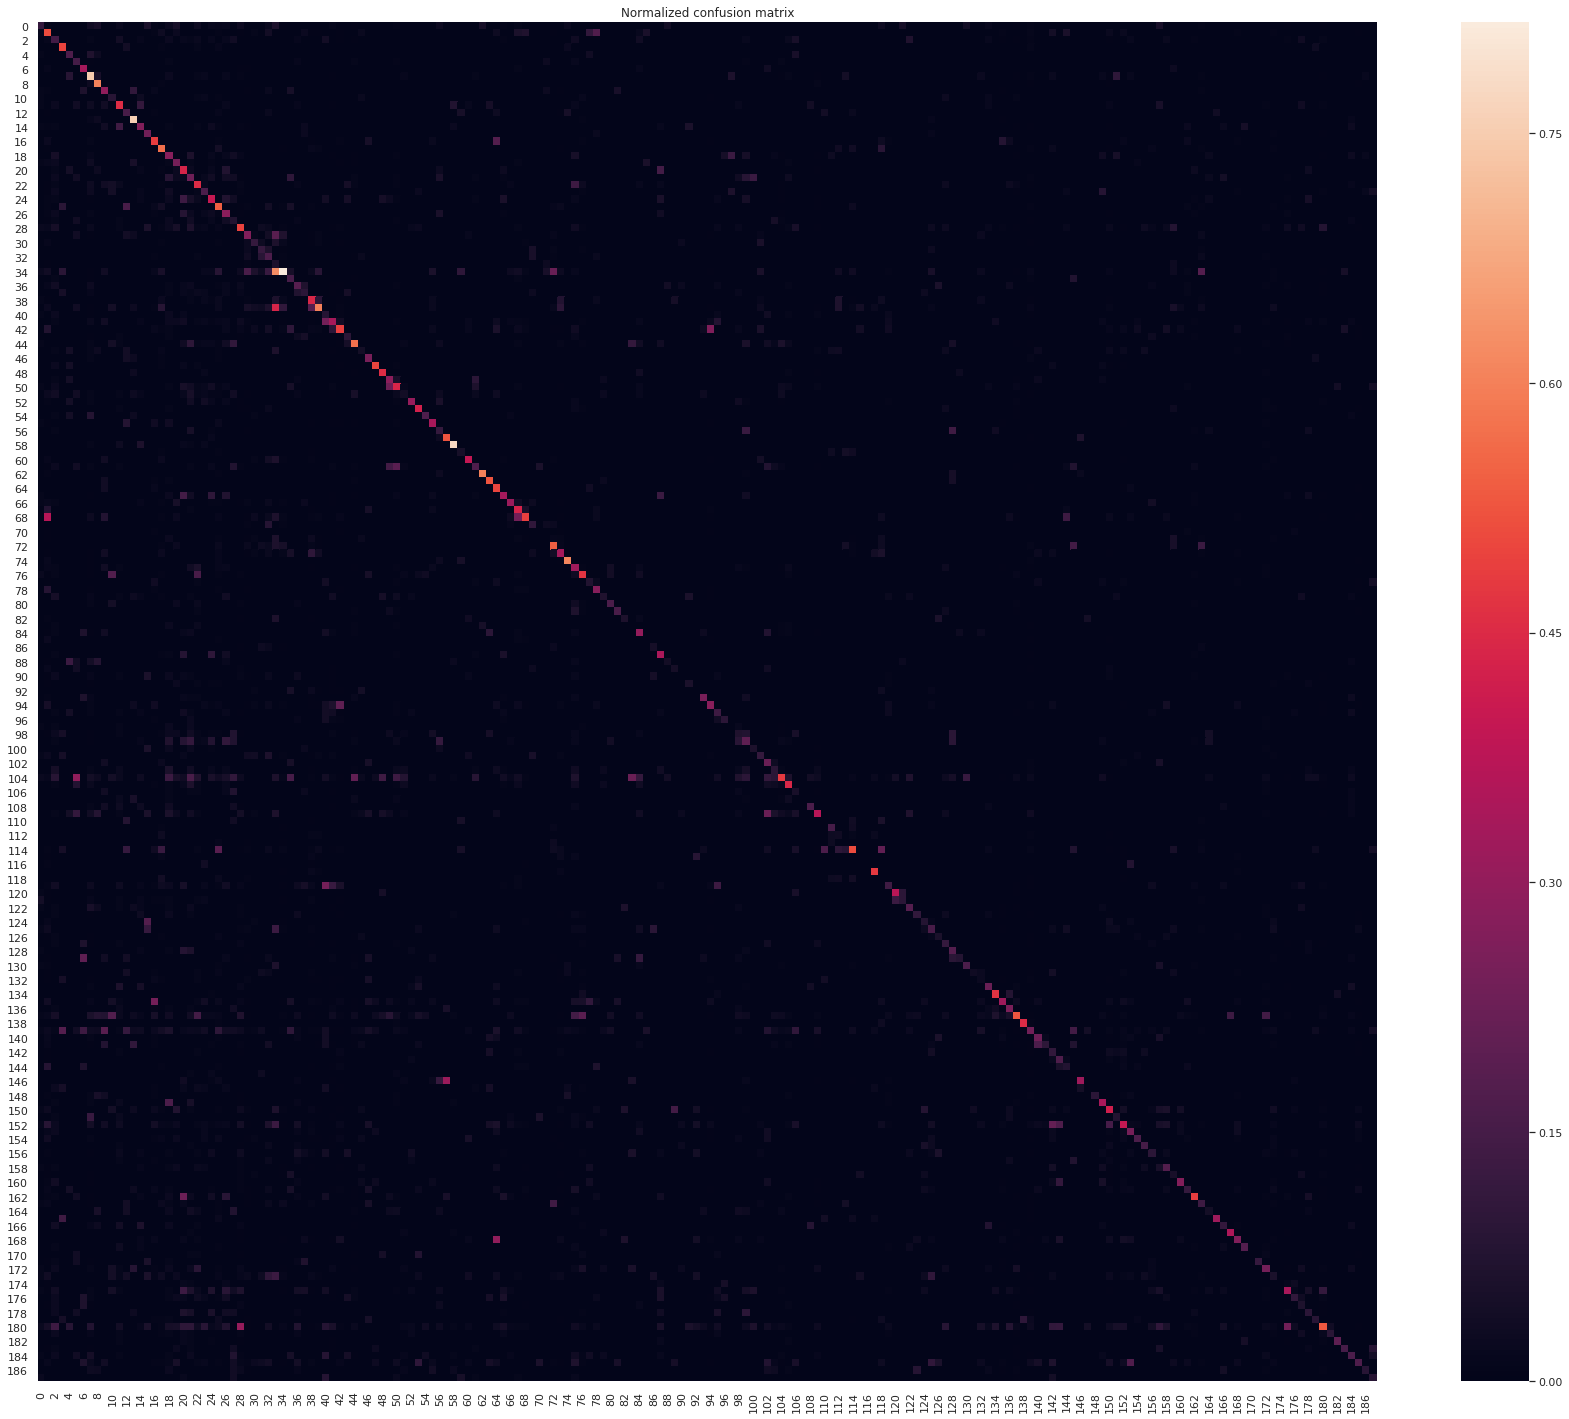

In [470]:
print('F1 score: {:.4f}'.format(knn_f1))
sns.heatmap(knn_cm / knn_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

## Random Forest

In [323]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=25, random_state=42)
rf.fit(train_inputs_vec, dataset.train_targets)
rf_val_predictions = rf.predict(val_inputs_vec)

rf_f1 = f1_score(dataset.val_targets, rf_val_predictions, average='micro')
rf_cm = confusion_matrix(dataset.val_targets, rf_val_predictions)

F1 score: 0.2325


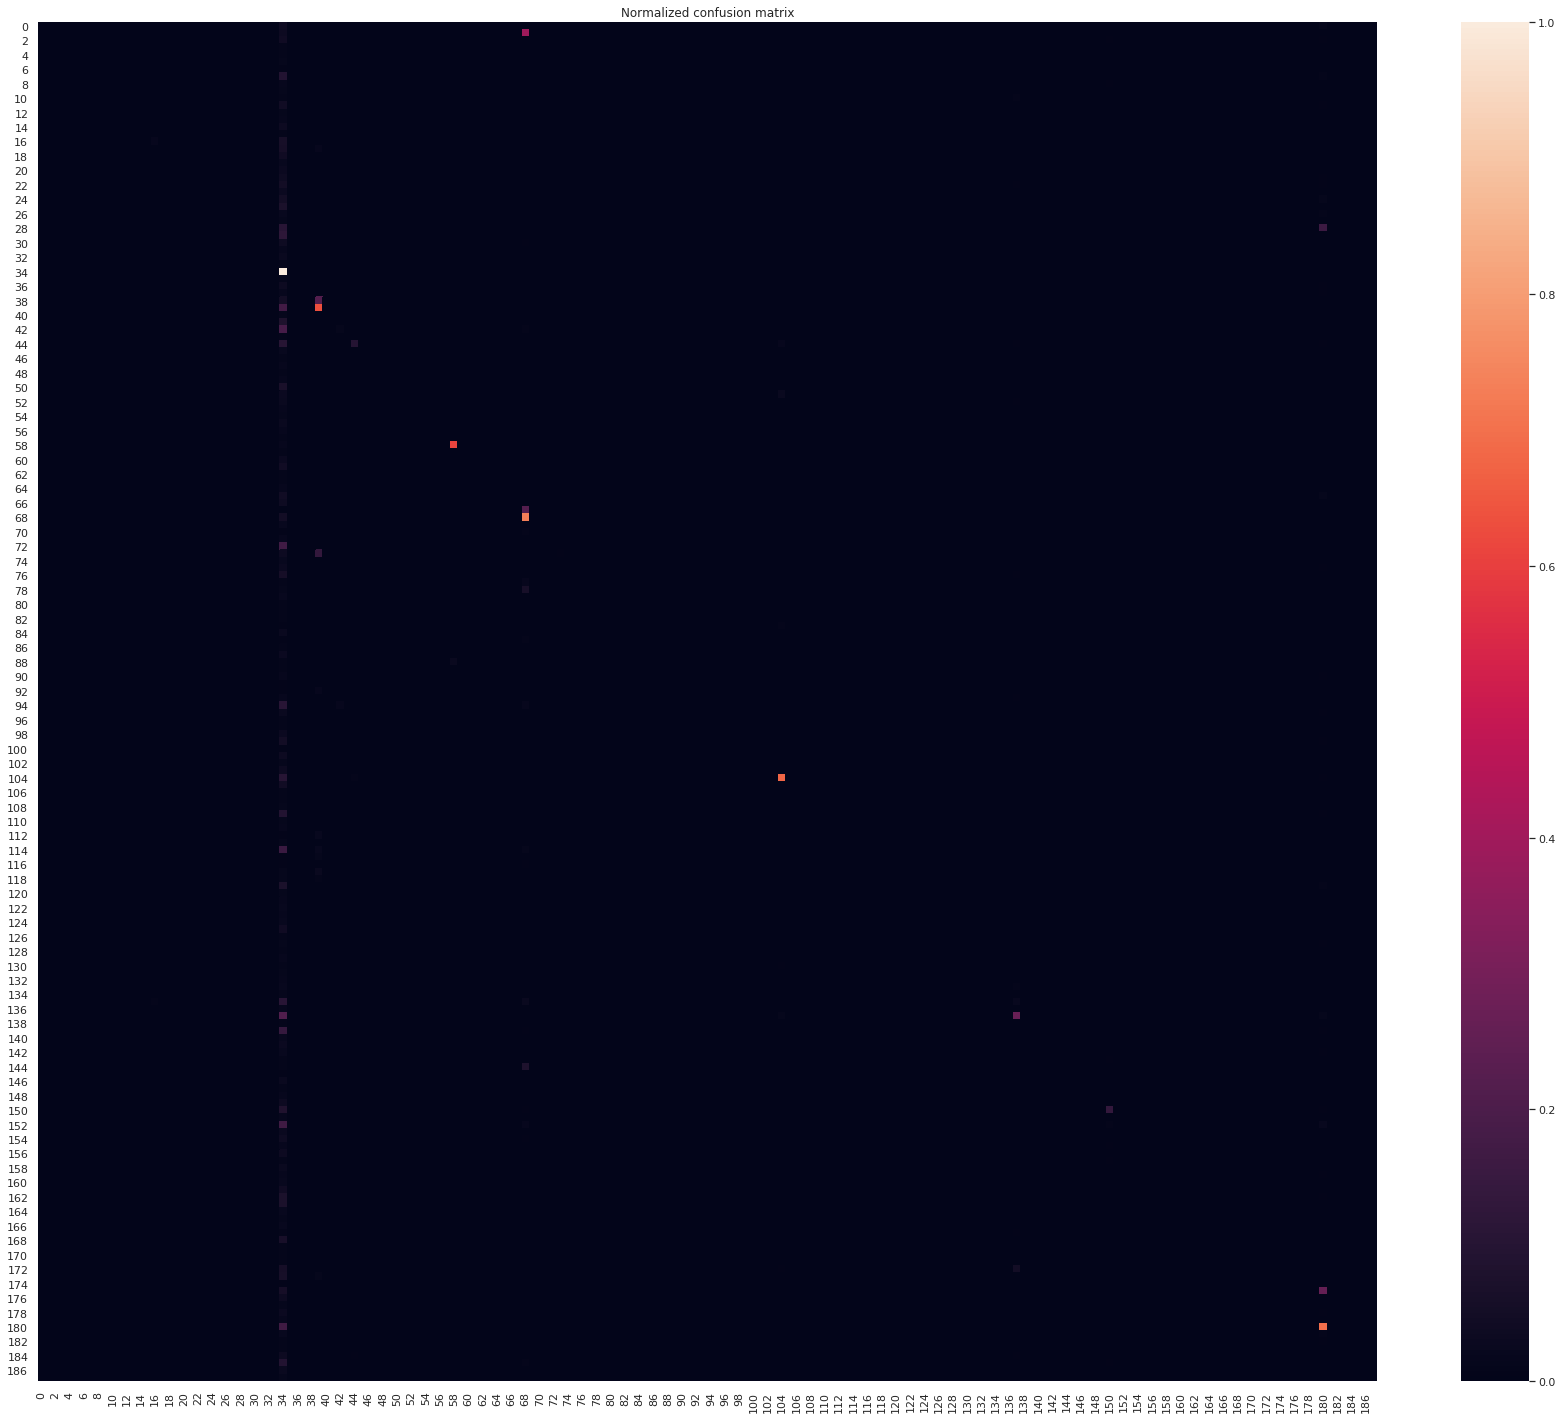

In [471]:
print('F1 score: {:.4f}'.format(rf_f1))
sns.heatmap(rf_cm / rf_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

## MLP

In [321]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128),
                    activation='relu',
                    solver='adam',
                    alpha=0.2,
                    learning_rate_init=0.1,
                    max_iter=50)

mlp.fit(train_inputs_vec, dataset.train_targets)
mlp_val_predictions = mlp.predict(val_inputs_vec)

mlp_f1 = f1_score(dataset.val_targets, mlp_val_predictions, average='micro')
mlp_cm = confusion_matrix(dataset.val_targets, mlp_val_predictions)

F1 score: 0.2891


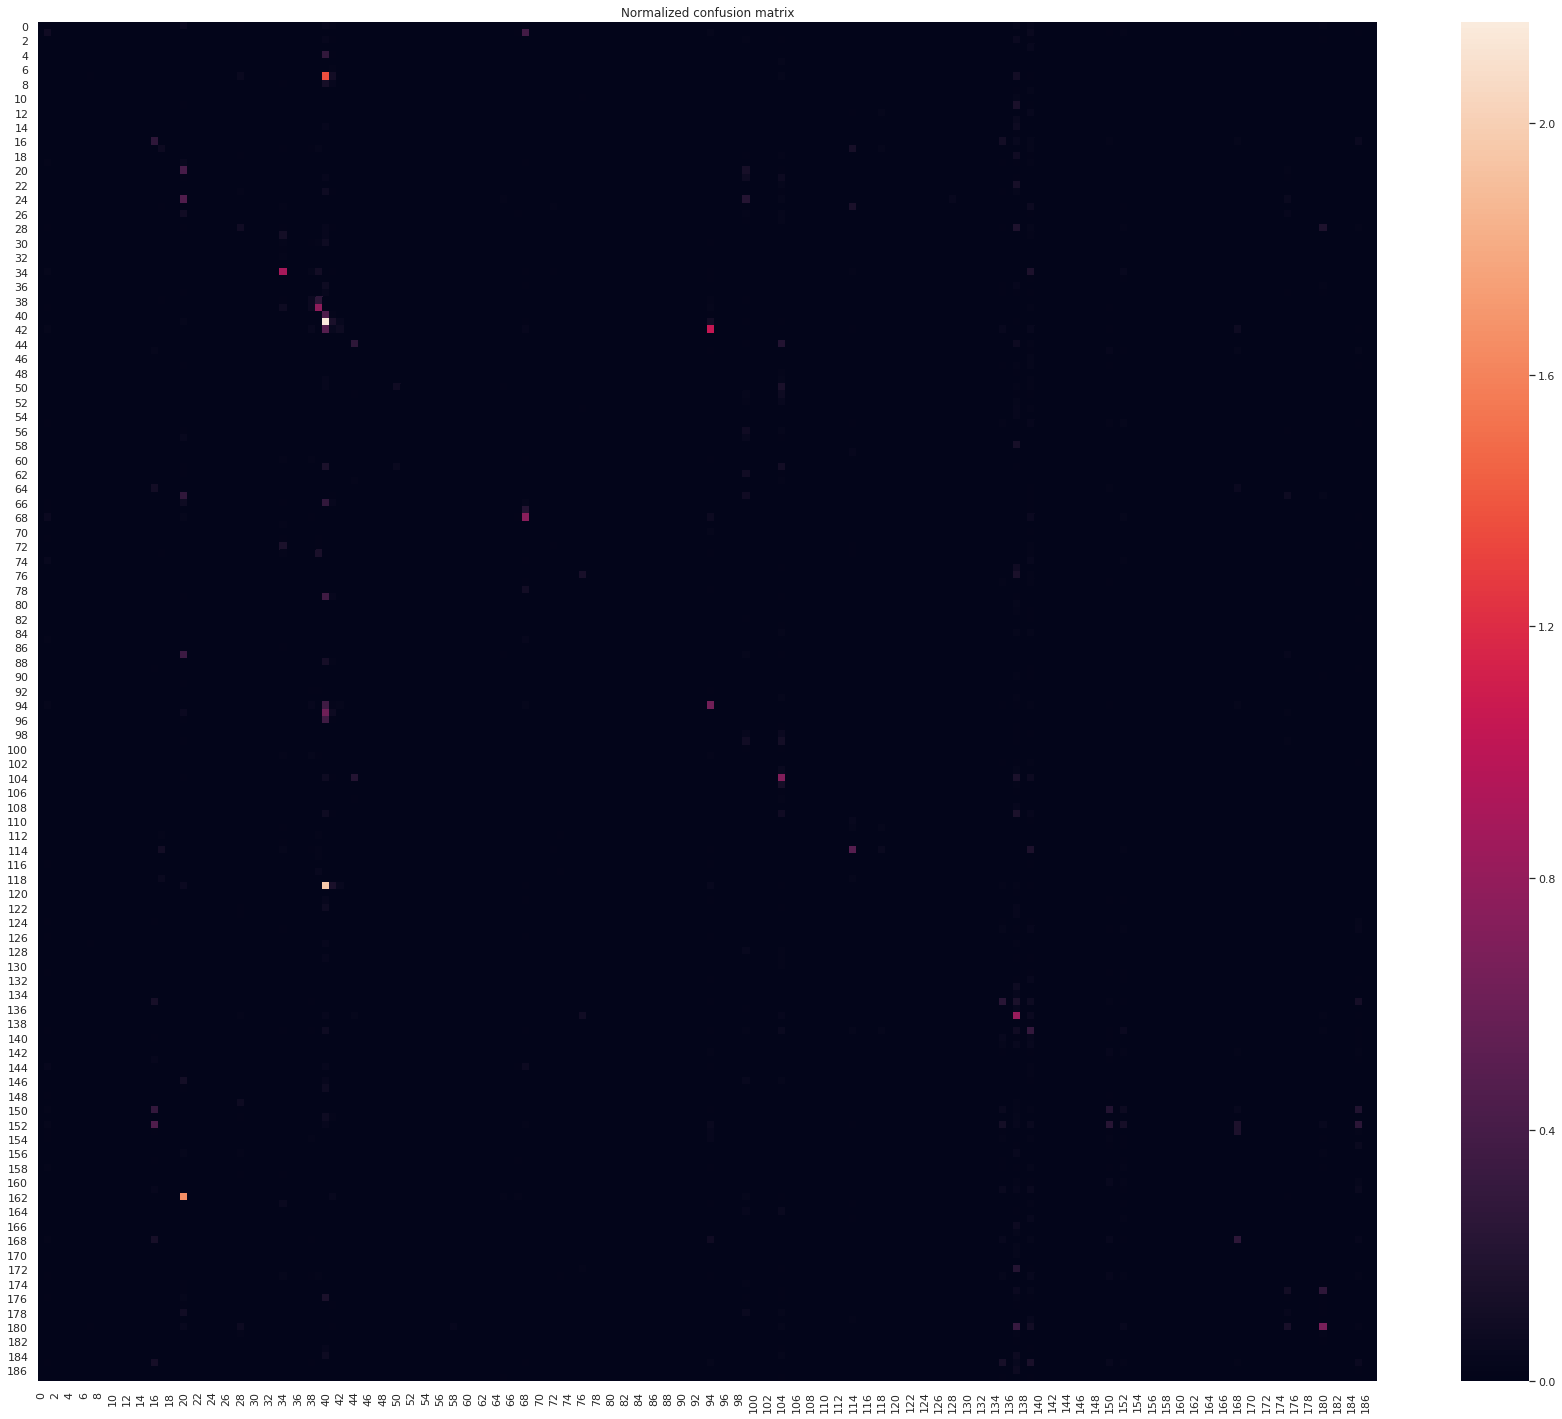

In [472]:
print('F1 score: {:.4f}'.format(mlp_f1))
sns.heatmap(mlp_cm / mlp_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

# LSTM

In [880]:
class LSTMClassifier(nn.Module):
    """
    Args:
        embedding_dim -- 300
        hidden_dim -- hidden state dimensionality
        vocab_size -- vocabulary size
        num_classes -- number of classes
        pretrained_embeddings -- None or [vocab_size, embedding_dim] tensor
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes,
                 pretrained_embeddings=None, device='cpu'):

        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings,
                                                                freeze=False).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2,
                            bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_dim, self.num_classes)
        self.dropout = nn.Dropout(p=0.4)
        self.device = device
        self.to(self.device)

    def forward(self, inputs):
        embeds = rnn.PackedSequence(self.word_embeddings(inputs.data), inputs.batch_sizes)
        h0 = torch.randn(2, inputs.batch_sizes[0], self.hidden_dim//2).to(self.device)
        c0 = torch.randn(2, inputs.batch_sizes[0], self.hidden_dim//2).to(self.device)
        lstm_out, (hidden, cell) = self.lstm(embeds, (h0, c0))
        scores = F.log_softmax(self.cls(self.dropout(hidden.permute(1,0,2)\
                                                     .contiguous()\
                                                     .view(inputs.batch_sizes[0], -1))), dim=1)
        return scores

In [881]:
class AverageMeter(object):
    """Computes and stores the average and current value
    """
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def seq_to_idxs(seq, mapping):
    """Converts a sequence of elements to sequence of indices
       using given mapping

    Args:
        seq -- list of elements
        mapping -- {element: idx} dict
    """
    outs_seq = [torch.tensor(mapping[el], dtype=torch.long) for el in seq]
    outs_seq = torch.stack(outs_seq, 0)
    return outs_seq

def calculate_scores(outputs, targets, num_classes, log=False):
    """Calculate per-class and micro-average precision, recall, F-1 score and F-0.5 score
    
        Args:
            outputs: tensor of log-softmax model outputs for the dataset
            targets: tensor of true class indices for the dataset
            log: whether to print or not
        Returns:
            (micro-average) precision, recall, F-1 score, F-0.5 score
    """    
    def F_score(precision, recall, beta=1):
        return (1 + beta**2) * precision * recall / ((beta**2) * precision + recall + 1e-15)

    pred = outputs.max(dim=1)[1]
    TP, TN = torch.zeros(num_classes), torch.zeros(num_classes)
    FP, FN = torch.zeros(num_classes), torch.zeros(num_classes)
    if log:
        print('Cls\tSize\tPrecision\tRecall\t\tF1\tF0.5')
    for i in range(num_classes):
        TP[i] = (pred[targets==i]==i).sum()
        TN[i] = (pred[targets!=i]!=i).sum()
        FP[i] = (pred[targets!=i]==i).sum()
        FN[i] = (pred[targets==i]!=i).sum()

        precision = float(TP[i] / (TP[i] + FP[i] + 1e-15))
        recall = float(TP[i] / (TP[i] + FN[i] + 1e-15))
        if log:
            print('{}\t{}\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t{:.4f}'.format(i, len(targets[targets==i]),
                                                                    precision, recall,
                                                                    F_score(precision, recall, beta=1),
                                                                    F_score(precision, recall, beta=0.5)))

    MicroAvePrecision = float(TP.sum() / (TP.sum() + FP.sum()))
    MicroAveRecall = float(TP.sum() / (TP.sum() + FN.sum()))
    F1 = F_score(MicroAvePrecision, MicroAveRecall, beta=1)
    F05 = F_score(MicroAvePrecision, MicroAveRecall, beta=0.5)
    if log:
        print('{}\t{}\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t{:.4f}'.format('MICRO', len(targets),
                                                                  MicroAvePrecision,
                                                                  MicroAveRecall,
                                                                  F1, F05))
    return MicroAvePrecision, MicroAveRecall, F1, F05

In [918]:
class Trainer():
    def __init__(self, model, loss_fn, optimizer, word_to_idx, device='cpu'):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.word_to_idx = word_to_idx
        self.device = device
    
    def fit(self, num_epochs,
            train_data, train_batch_size, val_data, val_batch_size,
            log_interval=50):
        for epoch in range(1, num_epochs+1):
            self.__train(epoch, train_data, train_batch_size, log_interval)
            self.__validate(epoch, val_data, val_batch_size)
        
    def __train(self, epoch, train_data, batch_size, log_interval=50):
        losses = AverageMeter()
        batch_time = AverageMeter()
        batch_start = 0
        batch_idx = 0
        while batch_start < len(train_data):
            end = time.time()
            self.optimizer.zero_grad()

            batch = train_data[batch_start:batch_start + batch_size]
            inputs_packed, targets_batch = self._prepare_batch(batch)
            inputs_packed = inputs_packed.to(self.device)
            targets_batch = targets_batch.to(self.device)
            outputs = self.model(inputs_packed)

            loss = self.loss_fn(outputs, targets_batch)
            loss.backward()
            self.optimizer.step()
            
            losses.update(loss.item())
            batch_time.update(time.time() - end)

            batch_start += batch_size
            batch_idx += 1
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {}\t[{:>5}/{:<5}]\tTime: {:.2f} ({:.2f})\tLoss: {:.4f} ({:.4f})'.format(epoch,
                    min(batch_start, len(train_data)), len(train_data),
                    batch_time.val, batch_time.avg,
                    losses.val, losses.avg))
        print('====> Train. {}\tTotal time: {:.2f}\tAverage loss: {:.4f}'.format(
              epoch, batch_time.sum, losses.avg))
            
            
    def __validate(self, epoch, val_data, batch_size):
        losses = AverageMeter()
        batch_time = AverageMeter()
        F1scores = AverageMeter()
        with torch.no_grad():
            batch_start = 0
            batch_idx = 0
            while batch_start < len(val_data):
                end = time.time()

                batch = val_data[batch_start:batch_start + batch_size]
                inputs_packed, targets_batch = self._prepare_batch(batch)
                inputs_packed = inputs_packed.to(self.device)
                targets_batch = targets_batch.to(self.device)
                outputs = self.model(inputs_packed)
                
                loss = self.loss_fn(outputs, targets_batch)
                _, _, F1, _ = calculate_scores(outputs, targets_batch, self.model.num_classes, log=False)
                F1scores.update(F1)

                losses.update(loss.item())
                batch_time.update(time.time() - end)

                batch_start += batch_size
                batch_idx += 1
        print('====> Valid. {}\tTotal time: {:.2f}\tAverage loss: {:.4f}\tF-1: {:.4f}\t'.format(
              epoch, batch_time.sum, losses.avg, F1scores.avg))
            
    def _prepare_batch(self, batch):
        inputs_batch = [seq_to_idxs(seq[0][:100], self.word_to_idx) for seq in batch]
        targets_batch = torch.tensor([seq[1] for seq in batch])
        
        order = sorted(enumerate(inputs_batch), key=lambda x: len(x[1]), reverse=True)
        inputs_batch = [inputs_batch[order_[0]] for order_ in order]

        inputs_packed = rnn.pack_sequence(inputs_batch)
        return inputs_packed, targets_batch
    
    def test(self, test_data):
        with torch.no_grad():
            inputs_packed, targets_batch = self._prepare_batch(test_data)
            inputs_packed = inputs_packed.to(self.device)
            targets_batch = targets_batch.to(self.device)
            outputs = self.model(inputs_packed)
        calculate_scores(outputs, targets_batch, self.model.num_classes, log=True);

In [920]:
train_data = list(zip(train_inputs_tokens, dataset.train_targets))
val_data = list(zip(val_inputs_tokens, dataset.val_targets))

hidden_dim = 256
learning_rate = 0.01

vocab_size = len(word_to_idx)
num_classes = len(dataset.class_to_idx)
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

model = LSTMClassifier(embedding_dim=word_embeddings.shape[1],
                       hidden_dim=hidden_dim,
                       vocab_size=vocab_size,
                       num_classes=num_classes,
                       pretrained_embeddings=word_embeddings,
                       device=device)
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=0.01)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_batch_size = 256
val_batch_size = 256

trainer = Trainer(model, loss_function, optimizer, word_to_idx, device=device)
trainer.fit(20, train_data, train_batch_size, val_data, val_batch_size)
trainer.test(test_data)

In [927]:
inputs, targets = trainer._prepare_batch(val_data)

model = model.to('cpu')
embeds = rnn.PackedSequence(model.word_embeddings(inputs.data), inputs.batch_sizes)
h0 = torch.randn(2, inputs.batch_sizes[0], model.hidden_dim//2).to('cpu')
c0 = torch.randn(2, inputs.batch_sizes[0], model.hidden_dim//2).to('cpu')
lstm_out, (hidden, cell) = model.lstm(embeds, (h0, c0))
scores = F.log_softmax(model.cls(model.dropout(hidden.permute(1,0,2)\
                                             .contiguous()\
                                             .view(inputs.batch_sizes[0], -1))), dim=1)
        
lstm_val_predictions = scores.argmax(1).to('cpu')

lstm_f1 = f1_score(dataset.val_targets, lstm_val_predictions, average='micro')
lstm_cm = confusion_matrix(dataset.val_targets, lstm_val_predictions)

F1 score: 0.0810


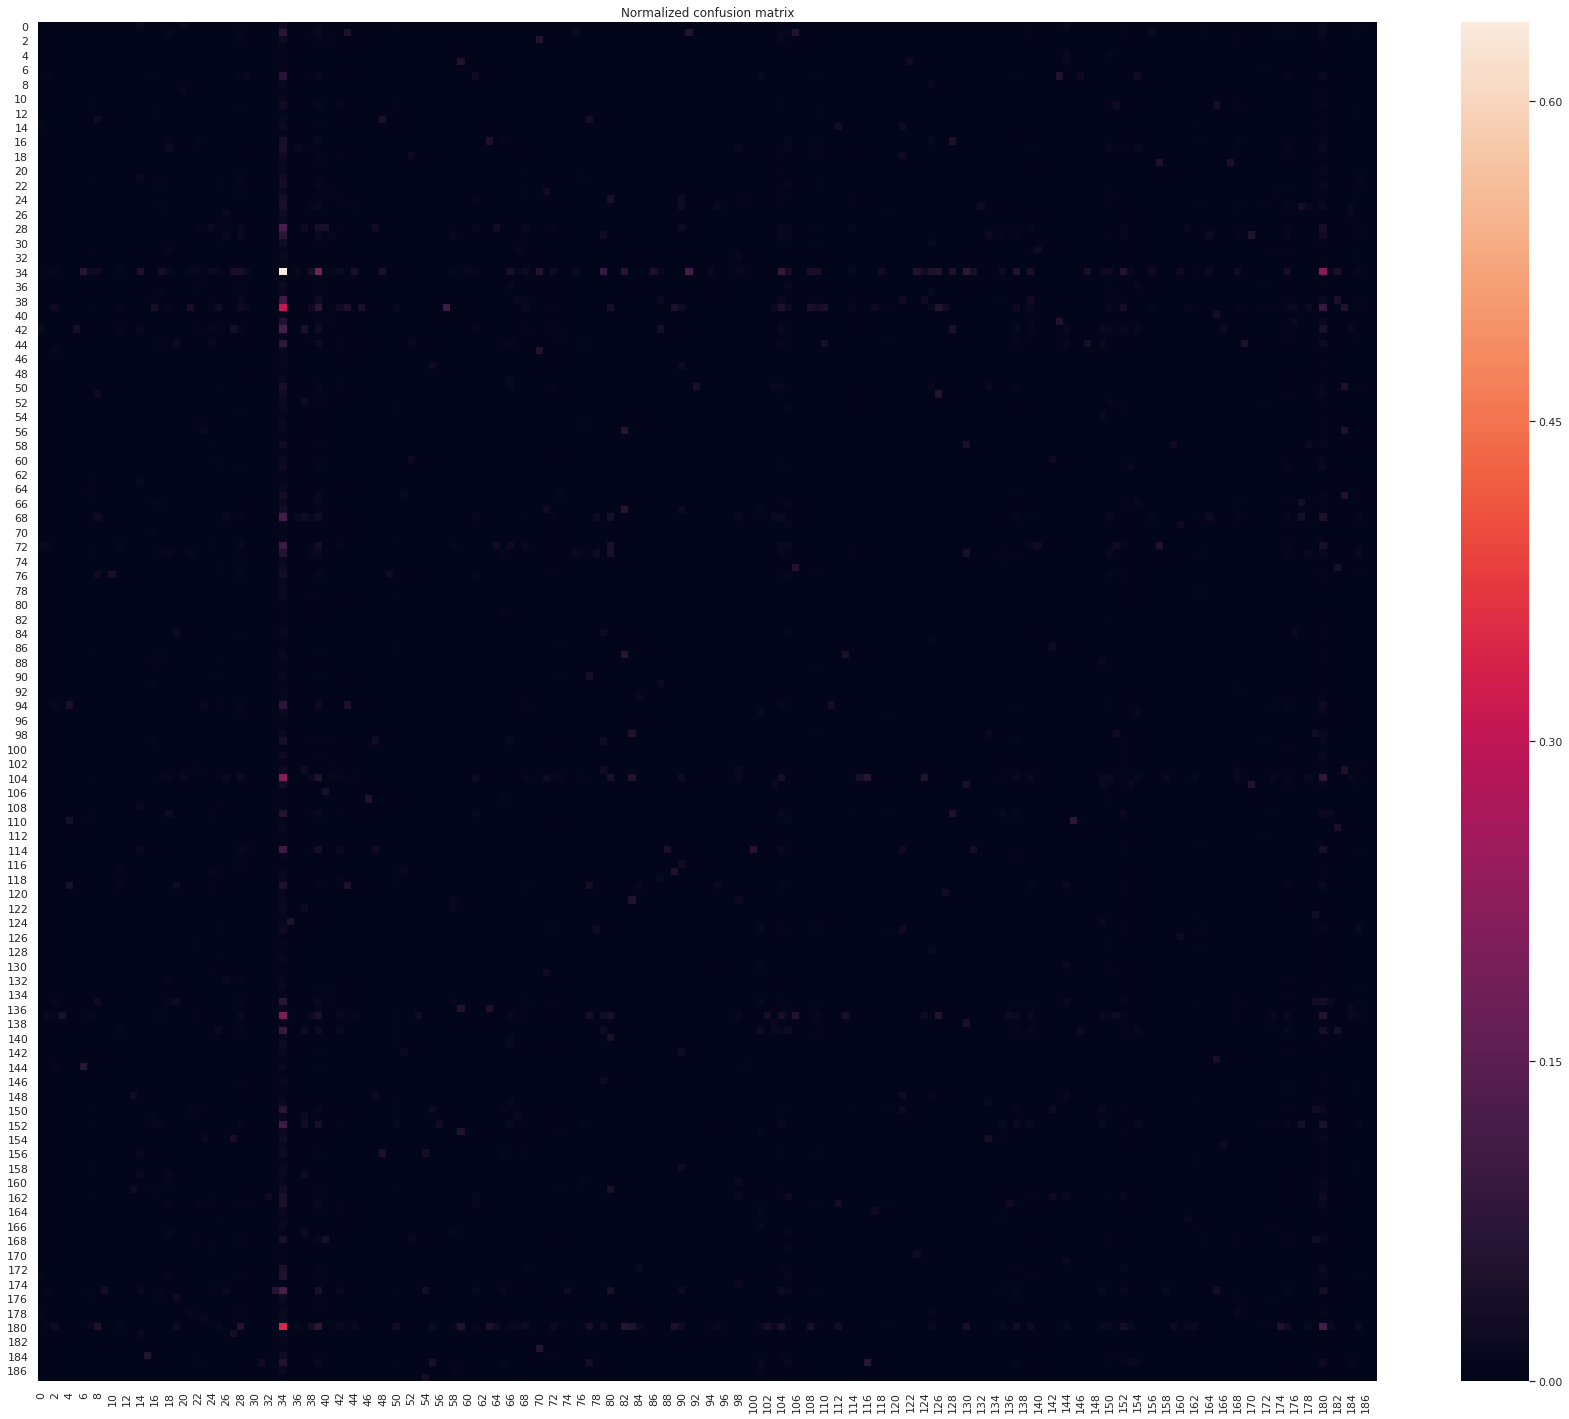

In [928]:
print('F1 score: {:.4f}'.format(lstm_f1))
sns.heatmap(lstm_cm / lstm_cm.sum(1), annot=False)
plt.title('Normalized confusion matrix')
plt.show()

> Unfortunately, the best performed model is the baseline KNN with F1 score 0.4